# Use pytorch to predict high, med or low expression of log TPM HighCu
A relatively simple task: determine from the promoter if the gene should be generally highly or generally lowly expressed. If we can't do this, then we should not expect the model to do anything more complicated. 

In [33]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from sklearn.metrics import r2_score

import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
from skorch import NeuralNetRegressor


In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


## Load 5G logTPM data

In [5]:
cond_file = 'data/conditions_to_include_20221031.txt'
with open(cond_file, 'r') as f:
    conds = [x.strip() for x in f.readlines()]
    
conds

['uMax',
 'lowO2_fast_growth',
 'lowCH4',
 'MeOH',
 'NoCu',
 'medCu',
 'highCu',
 'lowCu',
 'highO2_slow_growth',
 'NO3_lowO2_slow_growth',
 'WithLanthanum',
 'NoLanthanum',
 'LanzaTech',
 'aa3_KO',
 'crotonic_acid',
 'CH4_500ppm',
 'CH4_1000ppm']

In [6]:
sample_file = 'data/sample2condition_20221031.txt'
with open(sample_file, 'r') as f:
    samp2cond = dict([x.strip().split('\t') for x in f.readlines()])
    
samp2cond.keys()

dict_keys(['5GB1_ferm_Ack_QC_tpm', '5GB1_ferm_WT_QC_tpm', '5GB1_FM03_TR1_QC_tpm', '5GB1_FM03_TR2_QC_tpm', '5GB1_FM11_TR1_QC_tpm', '5GB1_FM11_TR2_QC_tpm', '5GB1_FM12_TR1_tpm', '5GB1_FM12_TR1_QC_tpm', '5GB1_FM12_TR2_tpm', '5GB1_FM12_TR2_QC_tpm', '5GB1_FM14_TR1_tpm', '5GB1_FM14_TR1_QC_tpm', '5GB1_FM14_TR2_tpm', '5GB1_FM14_TR2_QC_tpm', '5GB1_FM18_TR1_QC_tpm', '5GB1_FM18_TR2_tpm', '5GB1_FM18_TR2_QC_tpm', '5GB1_FM18_TR3_tpm', '5GB1_FM18_TR3_QC_tpm', '5GB1_FM19_TR1_tpm', '5GB1_FM19_TR1_QC_tpm', '5GB1_FM19_TR1_UW_tpm', '5GB1_FM19_TR3_tpm', '5GB1_FM19_TR3_QC_tpm', '5GB1_FM20_TR1_QC_tpm', '5GB1_FM20_TR2_QC_tpm', '5GB1_FM20_TR3_tpm', '5GB1_FM20_TR3_QC_tpm', '5GB1_FM20_TR3_UW_tpm', '5GB1_FM21_TR1_tpm', '5GB1_FM21_TR1_QC_tpm', '5GB1_FM21_TR2_tpm', '5GB1_FM21_TR2_QC_tpm', '5GB1_FM21_TR2_UW_tpm', '5GB1_FM22_TR1_tpm', '5GB1_FM22_TR1_QC_tpm', '5GB1_FM22_TR3_tpm', '5GB1_FM22_TR3_QC_tpm', '5GB1_FM22_TR3_UW_tpm', '5GB1_FM23_TR3_tpm', '5GB1_FM23_TR3_QC_tpm', '5GB1_FM34_T0_TR1_QC_tpm', '5GB1_FM34_T3_TR3_QC_

In [7]:
samples = [x for x in samp2cond if samp2cond[x] in conds]
print(len(samples))
print(len(samp2cond))


90
102


In [8]:
#locus_info_filename = 'data/locus2info.tsv'
locus_info_filename = 'data/locus2info_20221031.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t').fillna("")
display(locus_info_df.head())
locus2info = u.make_info_dict(locus_info_df)

tpm_data_filename = "data/5GB1_tpms_20221031.tsv"
tpm_df = pd.read_csv(tpm_data_filename,sep='\t').fillna("")

display(tpm_df.head())

print(locus2info['EQU24_RS23150'])
display(tpm_df[tpm_df['locus_tag']=='EQU24_RS23150'])

locus_tag gene_symbol                                         product  \
0  EQU24_RS00005        dnaA  chromosomal replication initiator protein DnaA   
1  EQU24_RS00010        dnaN                 DNA polymerase III subunit beta   
2  EQU24_RS00015        recF             DNA replication/repair protein RecF   
3  EQU24_RS00020        gyrB   DNA topoisomerase (ATP-hydrolyzing) subunit B   
4  EQU24_RS00035                                        hypothetical protein   

  type  
0  CDS  
1  CDS  
2  CDS  
3  CDS  
4  CDS

locus_tag                                         product type  \
0  EQU24_RS00005  chromosomal replication initiator protein DnaA  CDS   
1  EQU24_RS00010                 DNA polymerase III subunit beta  CDS   
2  EQU24_RS00015             DNA replication/repair protein RecF  CDS   
3  EQU24_RS00020   DNA topoisomerase (ATP-hydrolyzing) subunit B  CDS   
4  EQU24_RS00035                            hypothetical protein  CDS   

  gene_symbol          locus  start_coord  end_coord  \
0        dnaA  NZ_CP035467.1            0       1317   
1        dnaN  NZ_CP035467.1         1502       2603   
2        recF  NZ_CP035467.1         3060       4140   
3        gyrB  NZ_CP035467.1         4185       6600   
4              NZ_CP035467.1         7350       7734   

                                                note  gene_len  \
0  Derived by automated computational analysis us...      1318   
1  Derived by automated computational analysis us...      1102   
2  Derived by automated computational analysis us...      1081   
3  Derived by automated computational analysis us...      2416   
4  Derived by automated computational analysis us...       385   

   5GB1_ferm_Ack_QC_tpm  ...  5GB1C-5G-N-BR1_tpm  5GB1C-5G-N-BR2_tpm  \
0              2.920380  ...           38.638102           31.867873   
1              1.600865  ...           45.092244           45.889651   
2              1.409423  ...           21.362765           20.976809   
3              3.186309  ...           57.478160           61.623220   
4              8.852007  ...          118.910610          106.287739   

   5GB1C-JG15-La-BR1_tpm  5GB1C-JG15-La-BR2_tpm  5GB1C-JG15-N-BR1_tpm  \
0              30.546267              36.840627             29.198516   
1              34.824076              44.661748             35.864388   
2              17.355043              21.854708             18.734014   
3              52.941842              63.050677             55.592843   
4             102.200487             116.972791            105.924563   

   5GB1C-JG15-N-BR2_tpm  5GB1C_CH4_500ppm-Rep1_tpm  5GB1C_CH4_500ppm-Rep2_tpm  \
0             35.405768                  56.747208                  55.734395   
1             45.409001                  32.721559                  33.467532   
2             25.608242                  26.409599                  23.529439   
3             58.631387                  48.167231                  51.249206   
4            129.975893                  86.942252                  83.059104   

   5GB1C_CH4_1000ppm-Rep2_tpm  5GB1C_CH4_1000ppm-Rep1_tpm  
0                   46.812595                   35.325741  
1                   34.906928                   30.020538  
2                   21.368579                   16.896055  
3                   61.811500                   54.226180  
4                  118.967455                   94.451247  

[5 rows x 111 columns]

{'gene': 'hxlB', 'product': '6-phospho-3-hexuloisomerase', 'type': 'CDS'}


locus_tag                      product type gene_symbol  \
4183  EQU24_RS23150  6-phospho-3-hexuloisomerase  CDS        hxlB   

              locus  start_coord  end_coord  \
4183  NZ_CP035467.1      4877125    4877659   

                                                   note  gene_len  \
4183  Derived by automated computational analysis us...       535   

      5GB1_ferm_Ack_QC_tpm  ...  5GB1C-5G-N-BR1_tpm  5GB1C-5G-N-BR2_tpm  \
4183             39.344956  ...         2365.689931         2769.139632   

      5GB1C-JG15-La-BR1_tpm  5GB1C-JG15-La-BR2_tpm  5GB1C-JG15-N-BR1_tpm  \
4183            1243.677654            1770.553275           2378.489135   

      5GB1C-JG15-N-BR2_tpm  5GB1C_CH4_500ppm-Rep1_tpm  \
4183           2178.110269                 1520.59018   

      5GB1C_CH4_500ppm-Rep2_tpm  5GB1C_CH4_1000ppm-Rep2_tpm  \
4183                 1588.76192                 2084.454046   

      5GB1C_CH4_1000ppm-Rep1_tpm  
4183                 1961.803703  

[1 rows x 111 columns]

In [9]:
log_tpm_df = pd.read_csv("data/XY_logTPM_opFilt_20221031.tsv",sep='\t')
log_tpm_df

og_index      locus_tag  \
0            0  EQU24_RS00005   
1            1  EQU24_RS00010   
2            2  EQU24_RS00015   
3            4  EQU24_RS00035   
4            9  EQU24_RS00060   
...        ...            ...   
2206      4182  EQU24_RS23145   
2207      4184  EQU24_RS23155   
2208      4186  EQU24_RS23165   
2209      4187  EQU24_RS23170   
2210      4188  EQU24_RS23175   

                                        upstream_region       uMax  \
0     ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...   5.478624   
1     GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...   5.690592   
2     TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...   4.863056   
3     GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...   6.236072   
4     GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...   4.553060   
...                                                 ...        ...   
2206  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  11.237420   
2207  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  11.240275   
2208  TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...  11.245186   
2209  AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...   5.687342   
2210  GACAACAAATGAACATGATTCGTCATCTGAACGAAAGCGTAAAGCT...   2.986357   

      lowO2_fast_growth     lowCH4      MeOH       NoCu      medCu     highCu  \
0              5.057673   4.896853  4.490890   5.145182   5.397970   5.405936   
1              5.327593   5.018030  4.187744   5.511274   5.929589   6.122296   
2              4.668366   4.159345  4.151060   4.498207   4.786031   4.885784   
3              6.078456   6.178559  5.400475   6.042533   6.231928   6.387618   
4              4.663626   3.639238  3.367896   4.379804   4.595742   4.686595   
...                 ...        ...       ...        ...        ...        ...   
2206          11.335500  10.863092  9.018391  10.617199  10.788779  11.118496   
2207          11.332696  10.861885  9.015633  10.630280  10.784309  11.113859   
2208          11.327803  10.873490  9.044817  10.639739  10.811677  11.125770   
2209           5.279725   4.821525  5.208461   5.082854   5.068202   5.311955   
2210           2.730569   2.235119  2.911585   2.795251   2.727666   2.446135   

          lowCu  highO2_slow_growth  NO3_lowO2_slow_growth  WithLanthanum  \
0      5.192777            5.969066               4.930030       5.027548   
1      5.687118            6.581135               5.375959       5.266481   
2      4.585745            5.439145               4.344218       4.249195   
3      6.075307            6.562648               5.781786       6.685816   
4      4.444783            4.238753               4.453061       4.918992   
...         ...                 ...                    ...            ...   
2206  10.625349           10.234527              12.057299      11.594911   
2207  10.624571           10.255792              12.052196      11.583235   
2208  10.655103           10.317302              12.046530      11.539422   
2209   4.899572            5.240644               4.812318       4.849694   
2210   2.377007            3.107326               1.950644       1.580081   

      NoLanthanum  LanzaTech     aa3_KO  crotonic_acid  CH4_500ppm  \
0        4.964473   4.628472   4.672580       5.203285    5.813802   
1        5.349840   5.748453   5.432198       5.643963    5.048957   
2        4.431874   3.510871   3.507901       4.979830    4.642674   
3        6.608930   5.090150   5.577019       6.052065    6.409572   
4        5.002460   3.663770   4.354762       4.450588    4.012562   
...           ...        ...        ...            ...         ...   
2206    12.181570  11.319127  12.194560      11.395111   11.080633   
2207    12.178662  11.331736  12.203430      11.391490   11.064205   
2208    12.082225  11.348469  12.160149      11.409383   10.671998   
2209     5.189988   5.348046   4.212482       5.896935    4.837302   
2210     0.974049   2.469011   1.313992       2.970741    0.101289   

      CH4_1000ppm  
0        

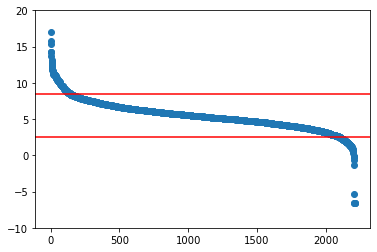

In [10]:
hicu = sorted(log_tpm_df['highCu'].values, reverse=True)

x,y = list(zip(*enumerate(hicu)))
plt.scatter(x,y)
#plt.yscale('log')
plt.ylim(-10,20)
plt.axhline(8.5,c='red')
plt.axhline(2.5,c='red')
plt.show()

In [11]:
uppert = 8.5
lowert = 2.5
hi_hicu = log_tpm_df[log_tpm_df['highCu']>uppert]
med_hicu = log_tpm_df[log_tpm_df['highCu'].between(lowert, uppert)]
low_hicu = log_tpm_df[log_tpm_df['highCu']<lowert]

In [12]:
print(hi_hicu.shape)
print(med_hicu.shape)
print(low_hicu.shape)

(143, 20)
(1959, 20)
(109, 20)


In [13]:
# calculate the mean across all samples, and the log of that number
tpm_df['overall_mean_tpm'] = tpm_df.apply(lambda row: np.mean(row[samples]) ,axis=1)
tpm_df['log_overall_mean_tpm'] = tpm_df['overall_mean_tpm'].apply(lambda x: np.log2(x))
tpm_df

locus_tag                                            product type  \
0     EQU24_RS00005     chromosomal replication initiator protein DnaA  CDS   
1     EQU24_RS00010                    DNA polymerase III subunit beta  CDS   
2     EQU24_RS00015                DNA replication/repair protein RecF  CDS   
3     EQU24_RS00020      DNA topoisomerase (ATP-hydrolyzing) subunit B  CDS   
4     EQU24_RS00035                               hypothetical protein  CDS   
...             ...                                                ...  ...   
4184  EQU24_RS23155                    3-hexulose-6-phosphate synthase  CDS   
4185  EQU24_RS23160                        6-phospho-3-hexuloisomerase  CDS   
4186  EQU24_RS23165                    3-hexulose-6-phosphate synthase  CDS   
4187  EQU24_RS23170                                        transposase  CDS   
4188  EQU24_RS23175  type II toxin-antitoxin system RelE/ParE famil...  CDS   

     gene_symbol          locus  start_coord  end_coord  \
0           dnaA  NZ_CP035467.1            0       1317   
1           dnaN  NZ_CP035467.1         1502       2603   
2           recF  NZ_CP035467.1         3060       4140   
3           gyrB  NZ_CP035467.1         4185       6600   
4                 NZ_CP035467.1         7350       7734   
...          ...            ...          ...        ...   
4184        hxlA  NZ_CP035467.1      4877662    4878310   
4185        hxlB  NZ_CP035467.1      4882314    4882848   
4186        hxlA  NZ_CP035467.1      4882851    4883499   
4187              NZ_CP035467.1      4918898    4919603   
4188              NZ_CP035467.1      4919710    4919809   

                                                   note  gene_len  \
0     Derived by automated computational analysis us...      1318   
1     Derived by automated computational analysis us...      1102   
2     Derived by automated computational analysis us...      1081   
3     Derived by automated computational analysis us...      2416   
4     Derived by automated computational analysis us...       385   
...                                                 ...       ...   
4184  Derived by automated computational analysis us...       649   
4185  Derived by automated computational analysis us...       535   
4186  Derived by automated computational analysis us...       649   
4187  Derived by automated computational analysis us...       706   
4188  Derived by automated computational analysis us...       100   

      5GB1_ferm_Ack_QC_tpm  ...  5GB1C-JG15-La-BR1_tpm  5GB1C-JG15-La-BR2_tpm  \
0                 2.920380  ...              30.546267              36.840627   
1                 1.600865  ...              34.824076              44.661748   
2                 1.409423  ...              17.355043              21.854708   
3                 3.186309  ...              52.941842              63.050677   
4                 8.852007  ...             102.200487             116.972791   
...                    ...  ...                    ...                    ...   
4184             54.488824  ...            2972.807778            3975.569016   
4185             39.120128  ...            1240.700959            1765.269056   
4186             49.546527  ...            2831.473500            3738.866442   
4187              5.792673  ...              23.052263              30.934037   
4188              1.202832  ...               0.776845               2.149225   

      5GB1C-JG15-N-BR1_tpm  5GB1C-JG15-N-BR2_tpm  5GB1C_CH4_500ppm-Rep1_tpm  \
0                29.198516             35.405768                  56.747208   
1                35.864388             45.409001                  32.721559   
2                18.734014             25.608242                  26.409599   
3                55.592843             58.631387                  48.167231   
4               105.924563            129.975893                  86.942252   
...                    ...                   ...                        ... 

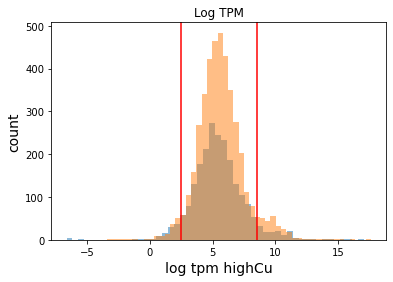

In [14]:
# Log TPM - mean log tpm column
plt.hist(log_tpm_df['highCu'].values,bins=50,alpha=0.5)
plt.hist(tpm_df['log_overall_mean_tpm'].values,bins=50,alpha=0.5)

plt.xlabel("log tpm highCu",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.axvline(uppert,c='red')
plt.axvline(lowert,c='red')
plt.title("Log TPM")
plt.show()

## Add classification labels

In [15]:
def set_reg_class_HML(df, col,uppert,lowert):
    '''
    Given a dataframe of log TPMS, add a column splitting genes into categories
    * Below lowert: class 0
    * Between lowert:uppert: class 1
    * Above uppert: class 2
    '''
    def get_class(val):
        if val < lowert:
            return 0
        elif val > uppert:
            return 2
        else:
            return 1
    
    class_col = f"{col}_HML"
    df[class_col] = df[col].apply(lambda x: get_class(x))

In [16]:
set_reg_class_HML(log_tpm_df, 'highCu',uppert,lowert)
log_tpm_df[['highCu','highCu_HML']]

highCu  highCu_HML
0      5.405936           1
1      6.122296           1
2      4.885784           1
3      6.387618           1
4      4.686595           1
...         ...         ...
2206  11.118496           2
2207  11.113859           2
2208  11.125770           2
2209   5.311955           1
2210   2.446135           0

[2211 rows x 2 columns]

In [17]:
log_tpm_df['highCu_HML'].value_counts()

1    1959
2     143
0     109
Name: highCu_HML, dtype: int64

### *This is the distribution I'm trying to predict*

## Train/test split

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_stratified_TVT_splits(df,seq_col,value_col,split_size=0.2):
    # define single splitter
    sss = StratifiedShuffleSplit(n_splits=1,test_size=split_size,random_state=0)

    # use to split full train and test
    sp1 = sss.split(df[seq_col].values, df[value_col].values)
    # extract from the generator
    full_train_idx,test_idx = [(a,b) for a,b in sp1][0]

    # retrieve full_train and test dfs
    full_train_df = df.iloc[full_train_idx]
    test_df = df.iloc[test_idx]

    # now split the full train into train and val
    sp2 = sss.split(full_train_df[seq_col].values, full_train_df[value_col].values)
    # extract from the generator
    train_idx,val_idx = [(a,b) for a,b in sp2][0]

    # retrieve train and val dfs
    train_df = full_train_df.iloc[train_idx]
    val_df = full_train_df.iloc[val_idx]
    
    assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])
    
    return full_train_df, test_df, train_df, val_df
    

def plot_train_test_stacks(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores in categories, sanity check that its not skewed'''
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    temp_df = pd.concat([train_df,test_df])
    if val_df is not None:
        val_df['set'] = 'val'
        temp_df = pd.concat([temp_df,val_df])
        
    temp_df = temp_df.value_counts([score_col,'set']).to_frame('count').reset_index()
        
    #temp_df = pd.melt(temp_df[['locus_tag',score_col,'set']],id_vars['locus_tag'])
    sns.barplot(x=score_col, y = 'count', data = temp_df, hue = "set")
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()
    

In [19]:
full_train_df,test_df,train_df,val_df = get_stratified_TVT_splits(log_tpm_df,'upstream_region','highCu_HML')

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

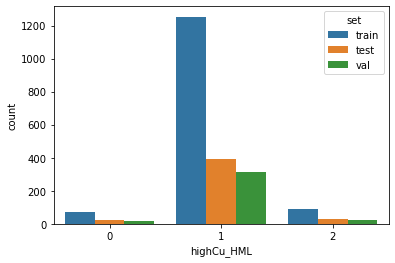

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

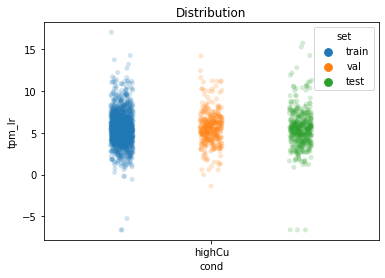

In [20]:
plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='highCu_HML')
view_train_test_dist(train_df, test_df,["highCu"],val_df=val_df,id_col='locus_tag')


## Load 5G seqs into data loaders

In [21]:
dataset_types = [
    DatasetSpec('ohe'),
#     DatasetSpec('kmer',k=3),
#     DatasetSpec('kmer',k=6),
]

In [22]:
# Dfs for the full train/test split
final_dls = tu.build_dataloaders_single(
    full_train_df, 
    test_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu_HML'
    #target_col='log_overall_mean_tpm'
)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu_HML'
    #target_col='log_overall_mean_tpm'
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

## run model 

In [38]:
def collect_model_stats(model_name,seq_len,encoding,
                        train_dl,val_dl,
                        lr=0.001,ep=1000,pat=100,opt=None,model=None):
    
    if not model:
        model = m.DNA_2CNN_2FC_Multi(
            seq_len,
            3, # num tasks
        )
    model.to(DEVICE)

    #loss_func = torch.nn.MSELoss() 
    loss_func = torch.nn.CrossEntropyLoss()
    
    if opt:
        opt = opt(model.parameters(), lr=lr)

    # pass in
    #train_dl,val_dl = dls[encoding] 
    
    train_losses, \
    val_losses, \
    epoch_stop, \
    best_val_score = tu.run_model(
        train_dl,
        val_dl, 
        model, 
        loss_func, 
        DEVICE,
        lr=lr, 
        epochs=ep, 
        opt=opt,
        patience=pat,
        #load_best=True # comment out to see overfitting in parity plots
    )

    # to plot loss
    data_label = [((train_losses,val_losses),model_name,epoch_stop,best_val_score)]
    tu.quick_loss_plot(data_label,loss_func=str(loss_func))
    
    return {
        'model_name':model_name,
        'model':model,
        'train_losses':train_losses,
        'val_losses':val_losses,
        'epoch_stop':epoch_stop,
        'best_val_score':best_val_score,
        'data_label':data_label
    }

In [24]:
model_res = {}
seq_len = len(train_df['upstream_region'].values[0])

1---------
2---------


E:1784 | train loss:0.324 | val loss: 0.426:  36%|███▌      | 1783/5000 [01:31<02:39, 20.20it/s]

EarlyStopping counter: 125 out of 500


E:1909 | train loss:0.293 | val loss: 0.428:  38%|███▊      | 1908/5000 [01:38<02:34, 19.96it/s]

EarlyStopping counter: 250 out of 500


E:2034 | train loss:0.268 | val loss: 0.440:  41%|████      | 2034/5000 [01:44<02:27, 20.06it/s]

EarlyStopping counter: 375 out of 500


E:2155 | train loss:0.243 | val loss: 0.462:  43%|████▎     | 2155/5000 [01:50<02:25, 19.54it/s]


EarlyStopping counter: 500 out of 500
Early stopping


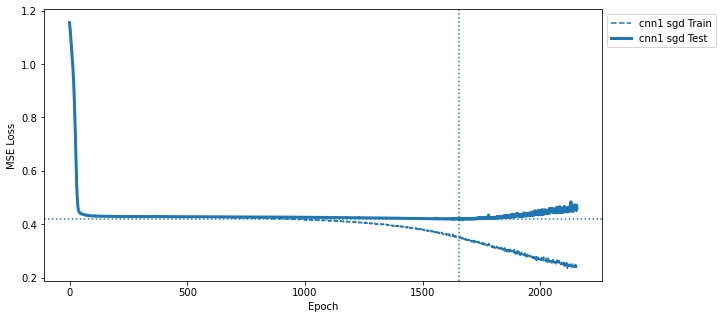

In [25]:
cnn1_name = 'cnn1 sgd'
model_res[cnn1_name] = collect_model_stats(
    cnn1_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
)

## View resulting conf matrix

In [26]:
def get_tensors_from_df(df,seq_col='upstream_region',target_cols=['highCu','noCu']):
    '''
    Make (potenitally) multi-task X,y matrix,vec for predicting from a model
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float().to(DEVICE), labels.float().to(DEVICE)

In [27]:
Xtrain,ytrain = get_tensors_from_df(train_df,target_cols=['highCu_HML'])
Xtest,ytest = get_tensors_from_df(test_df,target_cols=['highCu_HML'])
Xval,yval = get_tensors_from_df(val_df,target_cols=['highCu_HML'])

In [28]:
Xtrain.shape
ytrain.shape
print(Xval.shape)
print(yval.shape)

torch.Size([354, 300, 4])
torch.Size([354, 1])


In [136]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
def alt_cls_summary2(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('class:O'),
        y=alt.Y('metric:O'),
        color=alt.Color('score:Q',scale=alt.Scale(domain=(0.0,1.0))),
        tooltip=['metric:N','score:Q']
    ).properties(width=200)

    support = alt.Chart(df).mark_bar().encode(
        x=alt.X('class:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        y='support:Q',
        tooltip=['support:Q']
    ).properties(width=200,height=50)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def plot_raw_norm_confusion(model,model_name,splits):
    '''Get class predictions and plot confusion matrix'''
    dfs = {}
    model.eval()
    print(f"Running {model_name}")
    
    f, axes = plt.subplots(len(splits), 2, figsize=(8, len(splits)*4))#, sharey='row')
    #axes = list(axes)
    
    for k,split in enumerate(splits):
        print("split:",split)
        
        Xs,ys = splits[split]
        mats = []
        #y_preds = model(Xs)
        y_out = [x.topk(1) for x in model(Xs)]
        
        y_preds = []
        for i in range(len(y_out)):
            prob,cls = [x.item() for x in y_out[i]]
            y_preds.append(cls) # append the predicted class
        
        # raw conf matrix
        c = confusion_matrix(ys.cpu(),y_preds)
        mats.append((c,f"raw counts"))
        # normed conf matrix
        cp = np.zeros(c.shape)
        for i,row in enumerate(c):
            rowsum = sum(row)
            for j,item in enumerate(row):
                val = item/rowsum
                cp[i][j] = val

        mats.append((cp,f"normed counts"))
        
        

        for i,(mat,title) in enumerate(mats):
            disp = ConfusionMatrixDisplay(confusion_matrix=mat)
            #disp.plot(ax=axes.pop(0))
            disp.plot(ax=axes[k][i])
            disp.ax_.set_title(f"{split} {title}")

        
        
        cls_rep = classification_report(ys.cpu(), y_preds,target_names=[0,1,2],output_dict=True)
        # conver the dict into a df for viewing
        cls_df = pd.DataFrame.from_dict(cls_rep).T
        cls_df.index.name='class'
        cls_df = cls_df.reset_index()

        # drop the micro/macro average colums
        cls_df = cls_df.drop(cls_df[~cls_df['class'].isin([0,1,2])].index)
        # convert to int for sorting
        cls_df['class'] = cls_df['class'].apply(lambda x: int(x))
        
        #return cls_df

        # melt the df for altair
        cls_melt = cls_df.melt(
            id_vars=['class','support'],
            value_vars=['precision','recall','f1-score'],
            var_name='metric',
            value_name='score')

        #alt_cls_summary(cls_melt)
        display(alt_cls_summary2(cls_melt))
    
    f.suptitle(f"{model_name}",fontsize=20)
    plt.tight_layout()


        

In [137]:
split_dfs = {
    'train':(Xtrain,ytrain),
    'val':(Xval,yval)
}

Running cnn1 sgd
split: train


alt.VConcatChart(...)

split: val


alt.VConcatChart(...)

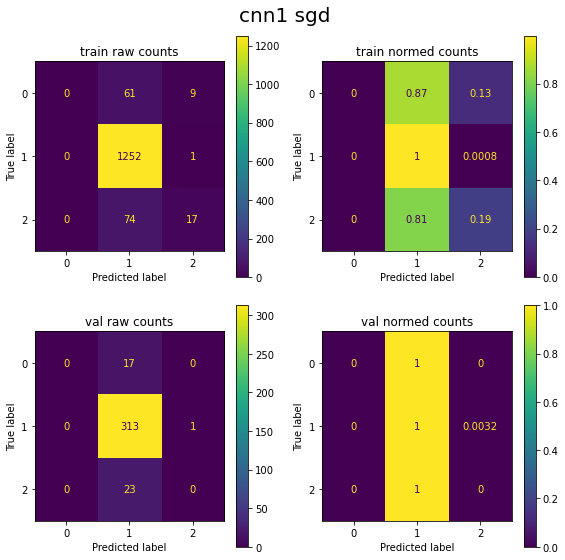

In [138]:

plot_raw_norm_confusion(
    model_res[cnn1_name]['model'],
    cnn1_name,
    split_dfs
)


1---------
2---------


E:151 | train loss:0.001 | val loss: 1.441:   3%|▎         | 152/5000 [00:08<04:18, 18.75it/s]

EarlyStopping counter: 125 out of 500


E:276 | train loss:0.007 | val loss: 1.422:   6%|▌         | 276/5000 [00:14<04:05, 19.21it/s]

EarlyStopping counter: 250 out of 500


E:401 | train loss:0.001 | val loss: 1.969:   8%|▊         | 402/5000 [00:21<04:03, 18.86it/s]

EarlyStopping counter: 375 out of 500


E:523 | train loss:0.000 | val loss: 2.352:  10%|█         | 523/5000 [00:27<03:58, 18.79it/s]


EarlyStopping counter: 500 out of 500
Early stopping


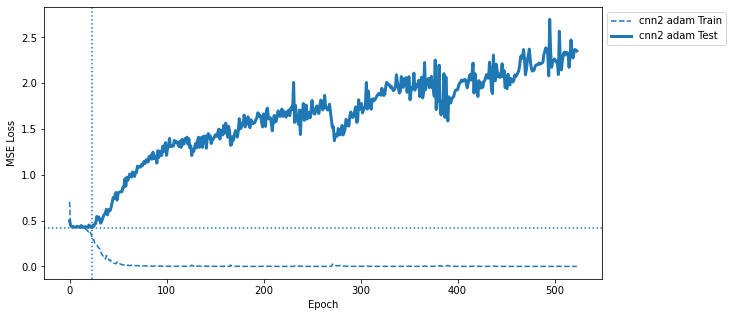

In [34]:
cnn2_name = 'cnn2 adam'
model_res[cnn2_name] = collect_model_stats(
    cnn2_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

Running cnn1 sgd


alt.VConcatChart(...)

Running cnn2 adam


alt.VConcatChart(...)

Running cnn1 sgd


alt.VConcatChart(...)

Running cnn2 adam


alt.VConcatChart(...)

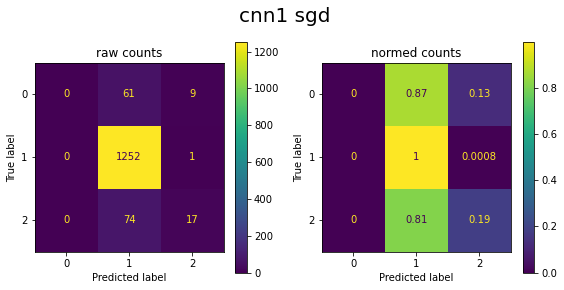

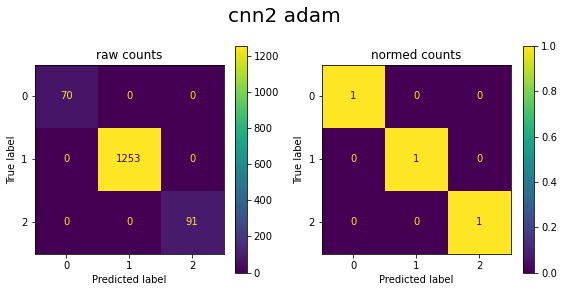

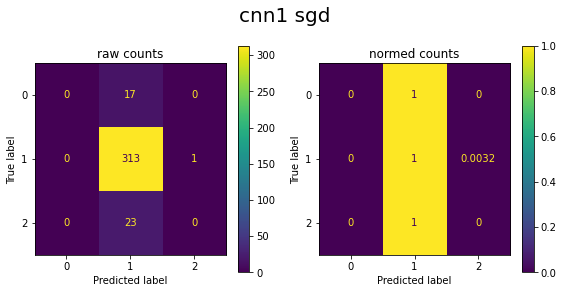

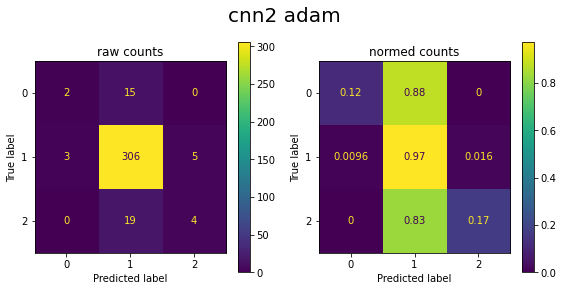

In [81]:
models = [
    (cnn1_name,model_res[cnn1_name]['model']),
    (cnn2_name,model_res[cnn2_name]['model']),
]

plot_raw_norm_confusion(models,Xtrain,ytrain)
plot_raw_norm_confusion(models,Xval,yval)

E:823 | train loss:0.710 | val loss: 5.040:  16%|█▋        | 824/5000 [00:43<03:41, 18.81it/s]

EarlyStopping counter: 750 out of 3000


E:1573 | train loss:0.394 | val loss: 4.527:  31%|███▏      | 1574/5000 [01:23<03:01, 18.83it/s]

EarlyStopping counter: 1500 out of 3000


E:2323 | train loss:0.320 | val loss: 4.219:  46%|████▋     | 2324/5000 [02:03<02:22, 18.80it/s]

EarlyStopping counter: 2250 out of 3000


E:3070 | train loss:0.224 | val loss: 3.924:  61%|██████▏   | 3070/5000 [02:43<01:42, 18.77it/s]


EarlyStopping counter: 3000 out of 3000
Early stopping


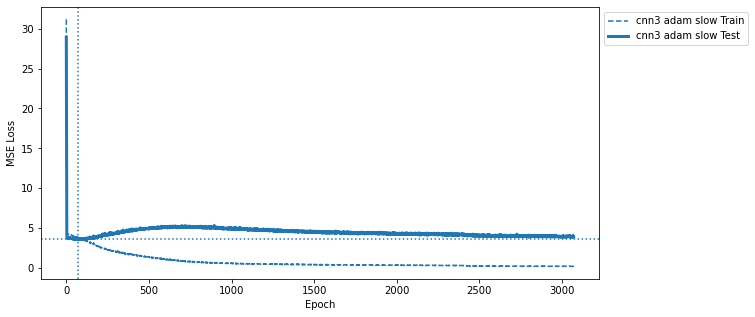

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn3 adam slow
val split
Running cnn3 adam slow
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn3 adam slow


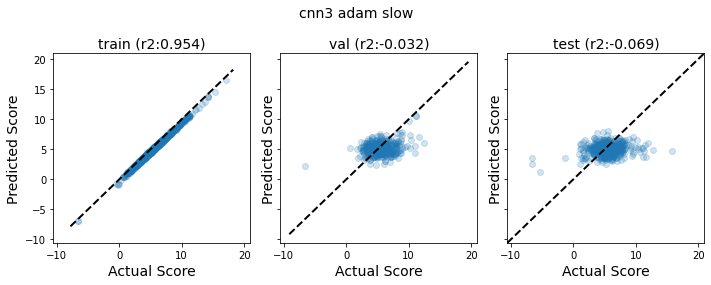

In [50]:
cnn3_name = 'cnn3 adam slow'
model_res[cnn3_name] = collect_model_stats(
    cnn3_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=3000,
    opt=torch.optim.Adam
)

parity_pred_by_split(cnn3_name,
                     DEVICE,
                     seq_col='upstream_region',
                     #target_col='log_overall_mean_tpm',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

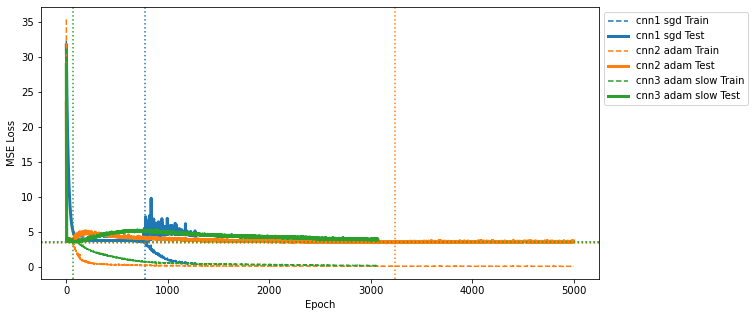

In [51]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

### ok so overfitting is happening... move away from this with data aug

# Data Augmentation

In [36]:
def augment_mutate(df,n,seq_col='upstream_region',mutation_rate=0.1):
    '''
    Given a dataframe of training data, augment it by adding 
    mutated versions back into the data frame
    '''
    mutation_dict = {
        'A':['C','G','T'],
        'C':['G','T','A'],
        'G':['T','A','C'],
        'T':['A','C','G'],
        'N':['N'] # no signal, just ignore
    }
    new_rows = []
    # for each row in the original df
    for i,row in df.iterrows():
        seq = row[seq_col]
                
        # generate n mutants
        for j in range(n):
            new_row = copy.deepcopy(row)
            new_seq = list(seq)
            mutate_vec = [random.random() for x in range(len(seq))]
            
            # loop through mutation values along length of the seq
            for k in range(len(seq)):
                # if random value is below mutation rate, then make a change
                if mutate_vec[k] < mutation_rate:
                    cur_base = seq[k]
                    # select new base randomly
                    new_base = random.choice(mutation_dict[cur_base])
                    new_seq[k] = new_base
            
            new_row[seq_col] = ''.join(new_seq)
            new_row['seq_version'] = j+1
            new_rows.append(new_row.values)

    # put new rows into a df
    new_rows = pd.DataFrame(new_rows,columns=new_row.index)
    # add version to og df 
    df['seq_version'] = 0
    
    return pd.concat([df,new_rows])



In [37]:
n=10
aug_train_df = augment_mutate(train_df,n,seq_col='upstream_region')

In [38]:
aug_train_df

level_0  index  og_index      locus_tag  \
0            1      1         1  EQU24_RS00010   
1            2      2         2  EQU24_RS00015   
2            4      4         9  EQU24_RS00060   
4            6      6        13  EQU24_RS00085   
5            7      7        17  EQU24_RS00105   
...        ...    ...       ...            ...   
14135     2210   2210      4188  EQU24_RS23175   
14136     2210   2210      4188  EQU24_RS23175   
14137     2210   2210      4188  EQU24_RS23175   
14138     2210   2210      4188  EQU24_RS23175   
14139     2210   2210      4188  EQU24_RS23175   

                                         upstream_region      uMax  \
0      GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...  5.690592   
1      TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...  4.863056   
2      GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...  4.553060   
4      TTACCGGGCCGGATTTTTTGACATAGTTCGTTTAGGGTTGGCAATT...  5.889536   
5      GACGAGCAACCGCCTAATCCGAGCAAAATCATTTCCATCGGCCGCG...  7.323624   
...                                                  ...       ...   
14135  GACAACAAATGAACATGAATCGTCATCTGAACGAAGGCGTAAAGCT...  2.986357   
14136  GAGAATAAATGAACTTGATTCGACATCTGAACGAAGGCGTAAGACT...  2.986357   
14137  CATAACAAAGGAACATGATTCGTCATCTGATCGAATGCGTAAAGCT...  2.986357   
14138  GACTACAAATGAACATGATTGGTCATCTGAACTGAAGCGTAACGCT...  2.986357   
14139  GACAACAAATGAACATGCTTCGACATCTGAACGAAAGCGTAAAGCT...  2.986357   

       lowO2_fast_growth    lowCH4      MeOH      NoCu  ...  \
0               5.327593  5.018030  4.187744  5.511274  ...   
1               4.668366  4.159345  4.151060  4.498207  ...   
2               4.663626  3.639238  3.367896  4.379804  ...   
4               5.238740  5.182750  4.729318  5.149217  ...   
5               6.777283  6.919297  5.584686  7.221879  ...   
...                  ...       ...       ...       ...  ...   
14135           2.730569  2.235119  2.911585  2.795251  ...   
14136           2.730569  2.235119  2.911585  2.795251  ...   
14137           2.730569  2.235119  2.911585  2.795251  ...   
14138           2.730569  2.235119  2.911585  2.795251  ...   
14139           2.730569  2.235119  2.911585  2.795251  ...   

       NO3_lowO2_slow_growth  WithLanthanum  NoLanthanum  LanzaTech    aa3_KO  \
0                   5.375959       5.266481     5.349840   5.748453  5.432198   
1                   4.344218       4.249195     4.431874   3.510871  3.507901   
2                   4.453061       4.918992     5.002460   3.663770  4.354762   
4                   5.303460       5.429320     5.657644   5.294725  5.401099   
5                   6.431481       5.907536     6.304866   4.983319  6.452877   
...                      ...            ...          ...        ...       ...   
14135               1.950644       1.580081     0.974049   2.469011  1.313992   
14136               1.950644       1.580081     0.974049   2.469011  1.313992   
14137               1.950644       1.580081     0.974049   2.469011  1.313992   
14138               1.950644       1.580081     0.974049   2.469011  1.313992   
14139               1.950644       1.580081     0.974049   2.469011  1.313992   

       crotonic_acid  CH4_500ppm  CH4_1000ppm    set  seq_version  
0           5.643963    5.048957     5.021201  train            0  
1           4.979830    4.642674     4.258694  train            0  
2           4.450588    4.012562     4.059889  train            0  
4           6.276210    4.992318     4.985268  train            0  
5           6.589512    4.028126     4.143753  train            0  
...              ...         ...          ...    ...          ...  
14135       2.970741    0.101289    -0.419729  train            6  
14136       2.970741    0.101289    -0.419729  train            7  
14137       2.970741    0.101289    -0.419729  train            8  
14138       2.970741    0.101289    -0.419729  train            9  
14139       2.970741    0.101289    -0.419729  train           10  

[15554 rows x 24 c

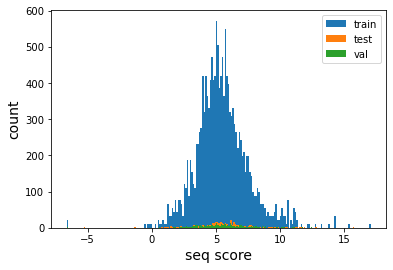

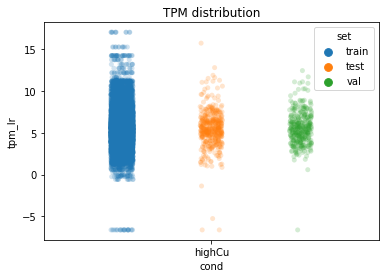

In [46]:
plot_train_test_hist(aug_train_df, test_df,score_col='highCu',bins=200,val_df=val_df)
view_train_test_dist(aug_train_df, test_df,["highCu"],"TPM",val_df=val_df)

In [39]:
# Dfs from further spliting train into train and val
aug_dls = tu.build_dataloaders_single(
    aug_train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu'
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
aug_ohe_train_dl,aug_ohe_val_dl = aug_dls['ohe']

E:2347 | train loss:0.173 | val loss: 3.498:  47%|████▋     | 2348/5000 [18:26<20:50,  2.12it/s]

EarlyStopping counter: 750 out of 3000


E:3699 | train loss:0.161 | val loss: 3.552:  74%|███████▍  | 3700/5000 [29:04<10:11,  2.12it/s]

EarlyStopping counter: 750 out of 3000


E:4449 | train loss:0.158 | val loss: 3.510:  89%|████████▉ | 4450/5000 [34:58<04:18,  2.12it/s]

EarlyStopping counter: 1500 out of 3000


E:4999 | train loss:0.155 | val loss: 3.549: 100%|██████████| 5000/5000 [39:17<00:00,  2.12it/s]


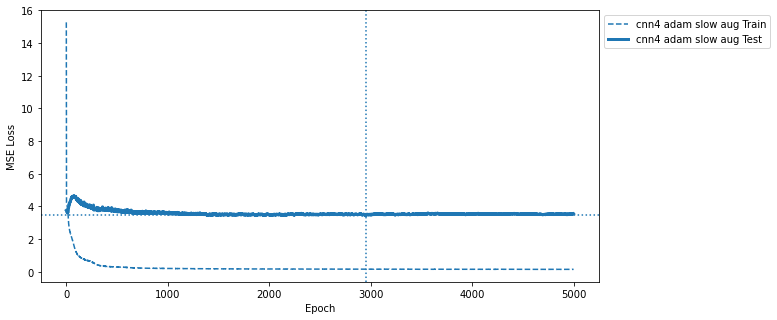

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn4 adam slow aug
val split
Running cnn4 adam slow aug
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn4 adam slow aug


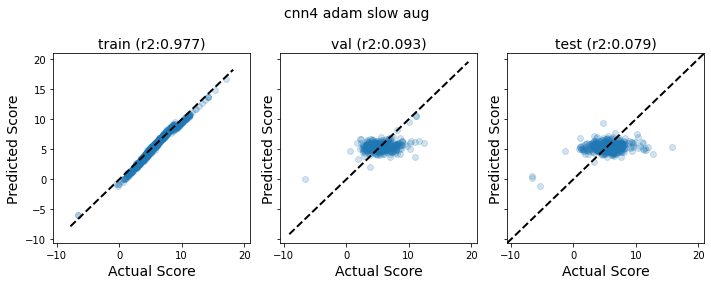

{'train':           locus_tag      truth       pred
 0     EQU24_RS00010   6.122296   6.402067
 1     EQU24_RS00015   4.885784   4.841495
 2     EQU24_RS00060   4.686595   4.445457
 4     EQU24_RS00085   5.970764   5.815013
 5     EQU24_RS00105   7.522305   7.655580
 ...             ...        ...        ...
 1761  EQU24_RS23115   3.946725   3.586574
 1762  EQU24_RS23135  11.118995  10.594329
 1765  EQU24_RS23165  11.125770  10.638550
 1766  EQU24_RS23170   5.311955   5.108074
 1767  EQU24_RS23175   2.446135   1.992045
 
 [1414 rows x 3 columns],
 'val':           locus_tag      truth       pred
 3     EQU24_RS00080   3.017367   5.104706
 9     EQU24_RS00180   3.675214   5.556727
 11    EQU24_RS00195   4.976946   5.177328
 19    EQU24_RS00260   4.506654   5.445475
 23    EQU24_RS00290   4.940403   5.089313
 ...             ...        ...        ...
 1744  EQU24_RS22820   5.662292   5.518509
 1755  EQU24_RS23040   0.580298   4.716613
 1760  EQU24_RS23105   6.632523   5.862070
 1763  EQU

In [40]:
cnn4_name = 'cnn4 adam slow aug'
model_res[cnn4_name] = collect_model_stats(
    cnn4_name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=3000,
    opt=torch.optim.Adam
)

parity_pred_by_split(cnn4_name,
                     DEVICE,
                     seq_col='upstream_region',
                     #target_col='log_overall_mean_tpm',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn4 adam slow aug
val split
Running cnn4 adam slow aug
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn4 adam slow aug


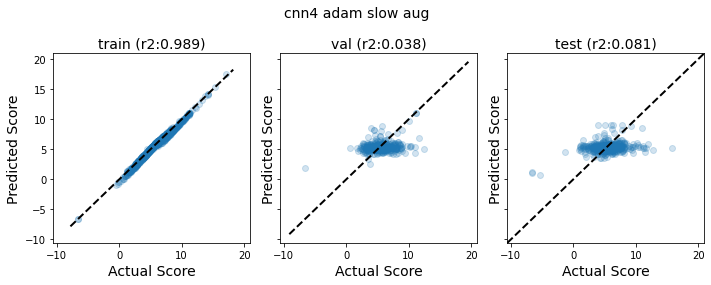

In [78]:
cnn4_pred_df = parity_pred_by_split(cnn4_name,
                     DEVICE,
                     seq_col='upstream_region',
                     #target_col='log_overall_mean_tpm',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

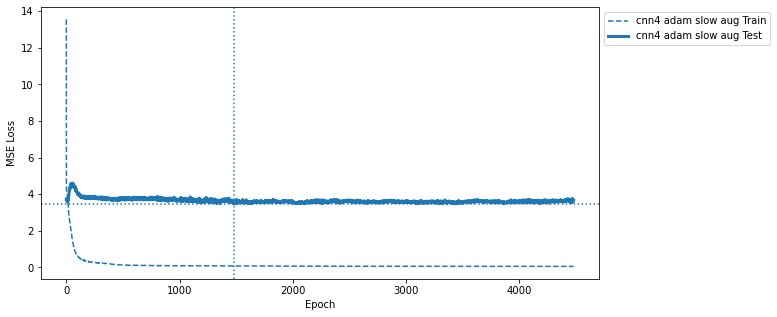

In [72]:
tu.quick_loss_plot(model_res[cnn4_name]['data_label'])

In [82]:
v = cnn4_pred_df['val']

In [84]:
v['gene'] = v['locus_tag'].apply(lambda x: locus2info[x]['gene'])
v['product'] = v['locus_tag'].apply(lambda x: locus2info[x]['product'])
v['type'] = v['locus_tag'].apply(lambda x: locus2info[x]['type'])

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [85]:
v

locus_tag      truth       pred  gene  \
3     EQU24_RS00080   3.017367   4.492002         
9     EQU24_RS00180   3.675214   4.146608         
11    EQU24_RS00195   4.976946   4.306906         
19    EQU24_RS00260   4.506654   4.676203         
23    EQU24_RS00290   4.940403   4.900714         
...             ...        ...        ...   ...   
1744  EQU24_RS22820   5.662292   6.283999         
1755  EQU24_RS23040   0.580298   5.168717         
1760  EQU24_RS23105   6.632523   5.008402  glgA   
1763  EQU24_RS23145  11.118496  10.984937  hxlA   
1764  EQU24_RS23155  11.113859  10.984937  hxlA   

                                product type  
3                  2OG-Fe(II) oxygenase  CDS  
9            ISAzo13 family transposase  CDS  
11    DUF4338 domain-containing protein  CDS  
19                 hypothetical protein  CDS  
23                 hypothetical protein  CDS  
...                                 ...  ...  
1744  DUF4338 domain-containing protein  CDS  
1755               hypothetical protein  CDS  
1760             glycogen synthase GlgA  CDS  
1763    3-hexulose-6-phosphate synthase  CDS  
1764    3-hexulose-6-phosphate synthase  CDS  

[354 rows x 6 columns]

In [86]:
alt.Chart(v).mark_circle(size=60).encode(
    x='truth:Q',
    y='pred:Q',
    color='type:N',
    tooltip=['locus_tag:N','gene:N','product:N']
).interactive()

alt.Chart(...)

In [87]:
t = cnn4_pred_df['test']
t['gene'] = t['locus_tag'].apply(lambda x: locus2info[x]['gene'])
t['product'] = t['locus_tag'].apply(lambda x: locus2info[x]['product'])
t['type'] = t['locus_tag'].apply(lambda x: locus2info[x]['type'])

alt.Chart(t).mark_circle(size=60).encode(
    x='truth:Q',
    y='pred:Q',
    color='type:N',
    tooltip=['locus_tag:N','gene:N','product:N']
).interactive()

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

alt.Chart(...)

## ** Some of the genes higher in the cloud and close to correct are fae and mxaB...

In [41]:
# smaller model?

E:272 | train loss:3.125 | val loss: 3.711:   5%|▌         | 273/5000 [02:12<38:23,  2.05it/s]

EarlyStopping counter: 250 out of 1000


E:761 | train loss:2.800 | val loss: 3.729:  15%|█▌        | 762/5000 [06:11<34:28,  2.05it/s]

EarlyStopping counter: 250 out of 1000


E:1011 | train loss:2.607 | val loss: 3.954:  20%|██        | 1012/5000 [08:13<32:29,  2.05it/s]

EarlyStopping counter: 500 out of 1000


E:1261 | train loss:2.450 | val loss: 3.773:  25%|██▌       | 1262/5000 [10:15<30:42,  2.03it/s]

EarlyStopping counter: 750 out of 1000


E:1511 | train loss:2.418 | val loss: 3.736:  30%|███       | 1511/5000 [12:17<28:22,  2.05it/s]

EarlyStopping counter: 1000 out of 1000
Early stopping


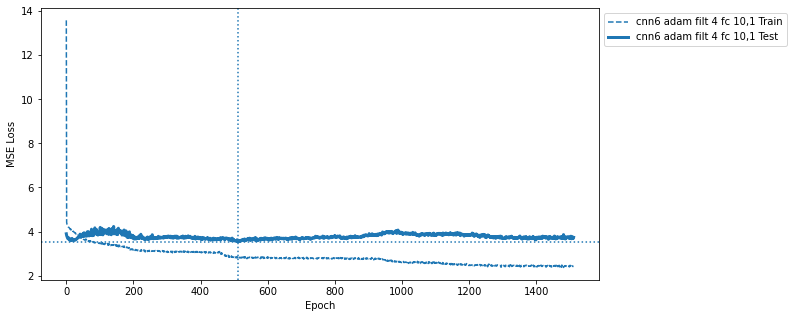

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn6 adam filt 4 fc 10,1
val split
Running cnn6 adam filt 4 fc 10,1
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn6 adam filt 4 fc 10,1


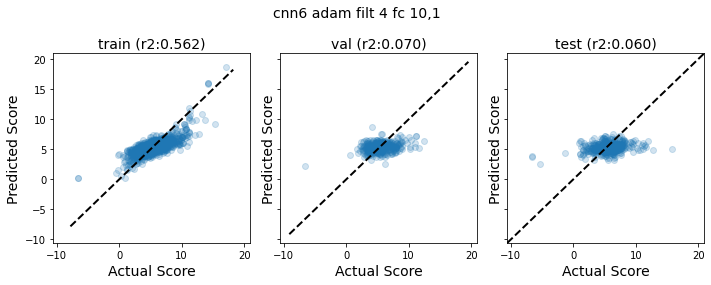

In [44]:
name = 'cnn6 adam filt 4 fc 10,1'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=4,
    num_filters2=4,
    conv_pool_size1=3,
    fc_node_num1=10,
    fc_node_num2=1
)

model_res[name] = collect_model_stats(
    name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model
)

pred_dfs = parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

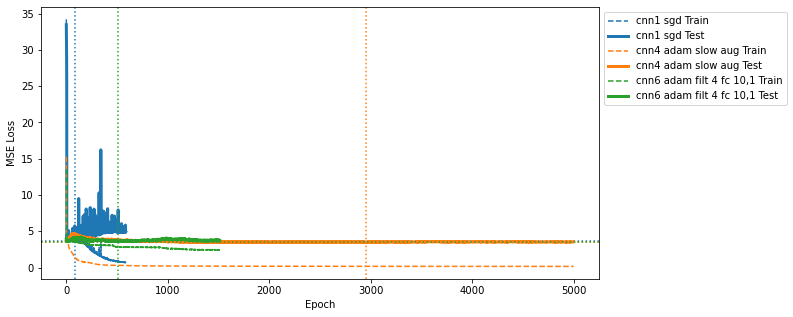

In [47]:
tu.quick_loss_plot(
    model_res[cnn1_name]['data_label'] +\
    model_res[cnn4_name]['data_label'] +\
    #model_res['cnn5 adam filt 16']['data_label'] +\
    model_res['cnn6 adam filt 4 fc 10,1']['data_label'],
    
)

In [ ]:
name = 'cnn7 adam filt 32,16'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=32,
    num_filters2=16,
    conv_pool_size1=2,
)

model_res[name] = collect_model_stats(
    name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model
)

pred_dfs = parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

E:439 | train loss:0.545 | val loss: 3.672:   9%|▉         | 440/5000 [04:26<45:47,  1.66it/s]

In [46]:
# ok so overfitting is happening... move away from this with smaller models?

E:339 | train loss:1.552 | val loss: 3.247:   7%|▋         | 340/5000 [00:18<04:10, 18.60it/s]

EarlyStopping counter: 250 out of 1000


E:589 | train loss:1.087 | val loss: 3.493:  12%|█▏        | 590/5000 [00:31<03:54, 18.80it/s]

EarlyStopping counter: 500 out of 1000


E:839 | train loss:0.901 | val loss: 3.882:  17%|█▋        | 840/5000 [00:45<03:43, 18.61it/s]

EarlyStopping counter: 750 out of 1000


E:1086 | train loss:0.805 | val loss: 3.942:  22%|██▏       | 1086/5000 [00:58<03:32, 18.43it/s]


EarlyStopping counter: 1000 out of 1000
Early stopping


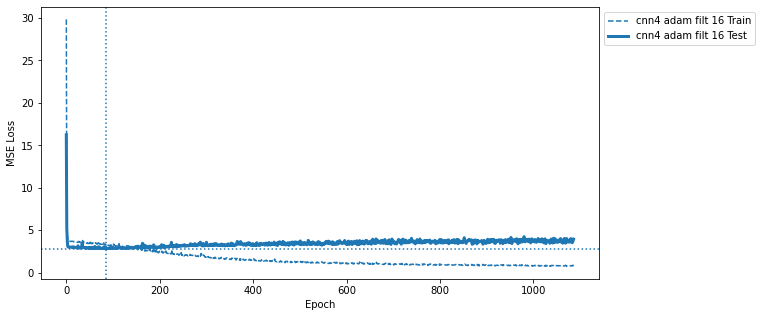

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn4 adam filt 16
val split
Running cnn4 adam filt 16
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn4 adam filt 16


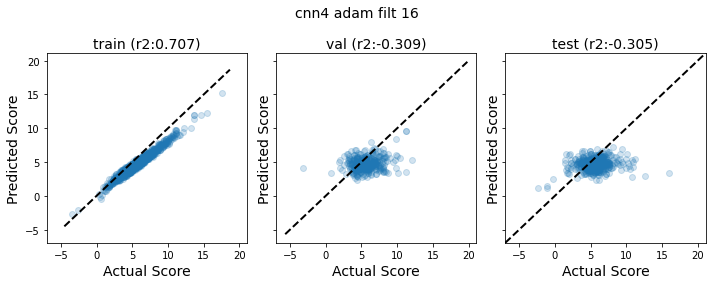

In [49]:
name = 'cnn4 adam filt 16'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=16,
    num_filters2=16,
    conv_pool_size1=3
)

model_res[name] = collect_model_stats(
    name,
    seq_len,
    'ohe',
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model
)

parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='log_overall_mean_tpm',
                     splits=['train','val','test']
                    )

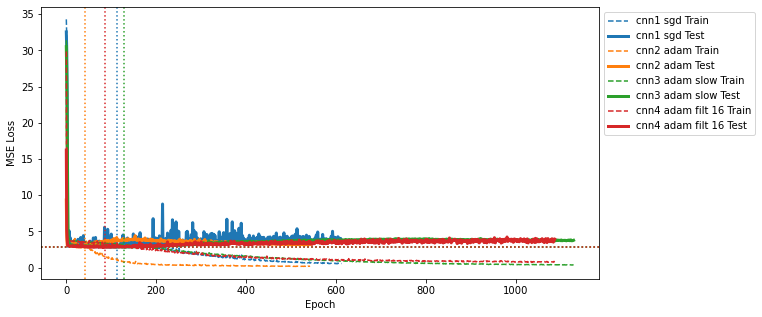

In [50]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

E:439 | train loss:2.325 | val loss: 3.143:   9%|▉         | 440/5000 [00:23<04:05, 18.59it/s]

EarlyStopping counter: 250 out of 1000


E:689 | train loss:1.999 | val loss: 3.669:  14%|█▍        | 690/5000 [00:37<03:53, 18.46it/s]

EarlyStopping counter: 500 out of 1000


E:939 | train loss:1.654 | val loss: 4.417:  19%|█▉        | 940/5000 [00:50<03:38, 18.59it/s]

EarlyStopping counter: 750 out of 1000


E:1186 | train loss:1.225 | val loss: 4.190:  24%|██▎       | 1186/5000 [01:04<03:25, 18.52it/s]


EarlyStopping counter: 1000 out of 1000
Early stopping


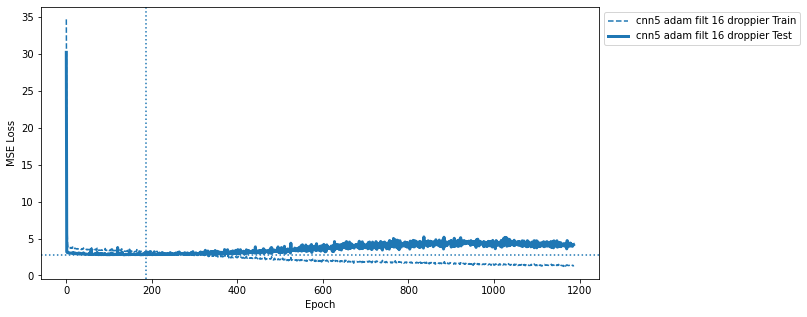

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn5 adam filt 16 droppier
val split
Running cnn5 adam filt 16 droppier
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn5 adam filt 16 droppier


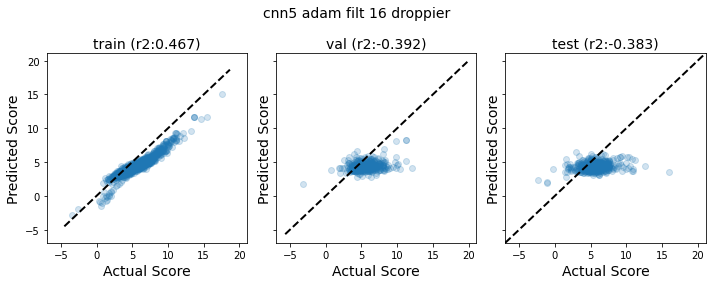

In [51]:
name = 'cnn5 adam filt 16 droppier'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=16,
    num_filters2=16,
    conv_pool_size1=3,
    dropout1=0.4,
    dropout2=0.4,
    
)

model_res[name] = collect_model_stats(
    name,
    seq_len,
    'ohe',
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model
)

parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='log_overall_mean_tpm',
                     splits=['train','val','test']
                    )

In [52]:
print('hi')

hi


## now try random search with some params

In [119]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform,uniform
from random import randint

from skorch.helper import predefined_split
from sklearn.model_selection import train_test_split
from skorch.dataset import Dataset

In [120]:
Xtrain, ytrain = make_skorch_dfs(aug_train_df, seq_col='upstream_region',target_col='highCu')
Xval, yval = make_skorch_dfs(val_df, seq_col='upstream_region',target_col='highCu')
print("Xtrain:",Xtrain.shape)
print("ytrain:",ytrain.shape)
print("Xval:",Xval.shape)
print("yval:",yval.shape)



Xtrain: torch.Size([15554, 300, 4])
ytrain: torch.Size([15554, 1])
Xval: torch.Size([354, 300, 4])
yval: torch.Size([354, 1])


In [121]:
valid_ds = Dataset(Xval, yval)

In [122]:
net_search = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi,
    module__seq_len=seq_len,
    module__n_tasks=1,
    max_epochs=5000,
    #lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[
        EarlyStopping(patience=1000),
        #Checkpoint(dirname='testcheck_search',f_pickle='model.pkl')
    ],
    train_split=predefined_split(valid_ds)

)

In [123]:
params = {
    'lr': [0.001, 0.0001],#0.00001],#loguniform(0.0001, 0.01)
    
    'module__num_filters1': [16,32,64,128], # uniform(8,128), #
    'module__num_filters2': [16,32,64,128], # uniform(8,128), #
    'module__kernel_size1': [4,8,16,32],
    'module__kernel_size2': [4,8,16,32],
    'module__fc_node_num1': [10, 25, 50,100], #randint(10,100), #
    'module__dropout1':[0.0,0.2,0.4],
    'module__dropout2':[0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.RMSprop],#torch.optim.AdamW,
}

In [124]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=50, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=1,
    verbose=2
)

In [126]:
search.fit(Xtrain,ytrain)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 491.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 3028.1min finished


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.9466        4.0618  0.9224
      2        4.3126        4.0915  0.9162
      3        4.2887        4.0515  0.9199
      4        4.2707        3.9794  0.9196
      5        4.2362        3.9990  0.9146
      6        4.1981        3.9761  0.9166
      7        4.1616        3.9557  0.9162
      8        4.1208        3.9046  0.9150
      9        4.0729        3.8921  0.9153
     10        4.0208        3.8661  0.9130
     11        3.9757        3.8384  0.9187
     12        3.9225        3.8210  0.9176
     13        3.8658        3.7909  0.9183
     14        3.8276        3.7968  0.9162
     15        3.7668        3.7771  0.9172
     16        3.7161        3.7891  0.9176
     17        3.6744        3.7848  0.9185
     18        3.6105        3.7888  0.9164
     19        3.5676        3.8021  0.9177
     20        3.5147        3.7979  0.9183
     21        3.4875        3.8

    157        0.2674        3.6614  0.9158
    158        0.2662        3.6930  0.9197
    159        0.2593        3.6895  0.9155
    160        0.2530        3.6067  0.9127
    161        0.2619        3.7732  0.9129
    162        0.2500        3.6550  0.9175
    163        0.2404        3.7306  0.9168
    164        0.2537        3.6546  0.9227
    165        0.2595        3.7097  0.9263
    166        0.2324        3.7438  0.9210
    167        0.2474        3.6792  0.9373
    168        0.2485        3.6119  0.9182
    169        0.2366        3.9225  0.9229
    170        0.2265        3.6144  0.9199
    171        0.2481        3.6779  0.9253
    172        0.2228        3.6092  0.9274
    173        0.2349        3.6068  0.9276
    174        0.2388        3.5867  0.9274
    175        0.2244        3.6009  0.9197
    176        0.2253        3.6607  0.9235
    177        0.2211        3.6318  0.9230
    178        0.2189        3.6230  0.9212
    179        0.2147        3.6

    334        0.1097        3.5378  0.9167
    335        0.1128        3.5291  0.9184
    336        0.1159        3.5867  0.9200
    337        0.1093        3.5661  0.9257
    338        0.1163        3.5549  0.9163
    339        0.1172        3.5556  0.9167
    340        0.1054        3.5530  0.9146
    341        0.1155        3.5554  0.9239
    342        0.1173        3.5288  0.9262
    343        0.1081        3.5281  0.9185
    344        0.1149        3.5424  0.9200
    345        0.1136        3.5223  0.9188
    346        0.1057        3.6779  0.9246
    347        0.1097        3.5845  0.9189
    348        0.1124        3.5318  0.9191
    349        0.1045        3.5818  0.9172
    350        0.1164        3.7040  0.9194
    351        0.1063        3.5835  0.9192
    352        0.1088        3.5994  0.9172
    353        0.1106        3.5561  0.9212
    354        0.1044        3.5546  0.9199
    355        0.1078        3.7062  0.9190
    356        0.1045        3.5

    516        0.0760        3.5649  0.9144
    517        0.0764        3.5249  0.9189
    518        0.0750        3.5040  0.9226
    519        0.0792        3.5193  0.9181
    520        0.0791        3.5453  0.9140
    521        0.0725        3.5290  0.9134
    522        0.0796        3.5227  0.9145
    523        0.0757        3.5370  0.9149
    524        0.0747        3.5699  0.9172
    525        0.0728        3.5438  0.9155
    526        0.0760        3.5769  0.9153
    527        0.0742        3.5124  0.9158
    528        0.0777        3.5917  0.9161
    529        0.0784        3.5314  0.9168
    530        0.0682        3.5671  0.9172
    531        0.0731        3.5580  0.9174
    532        0.0782        3.5477  0.9175
    533        0.0737        3.5990  0.9159
    534        0.0741        3.6714  0.9132
    535        0.0747        3.5207  0.9128
    536        0.0752        3.5681  0.9128
    537        0.0761        3.5365  0.9167
    538        0.0729        3.5

    700        0.0606        3.5502  0.9196
    701        0.0540        3.6516  0.9188
    702        0.0551        3.5533  0.9154
    703        0.0593        3.5943  0.9147
    704        0.0556        3.5506  0.9173
    705        0.0545        3.5834  0.9162
    706        0.0575        3.5812  0.9167
    707        0.0544        3.5725  0.9175
    708        0.0534        3.5608  0.9158
    709        0.0595        3.6451  0.9161
    710        0.0560        3.5460  0.9141
    711        0.0538        3.5660  0.9179
    712        0.0542        3.5659  0.9159
    713        0.0552        3.6369  0.9174
    714        0.0546        3.5612  0.9126
    715        0.0547        3.5957  0.9178
    716        0.0567        3.5579  0.9134
    717        0.0607        3.5448  0.9152
    718        0.0537        3.5657  0.9154
    719        0.0525        3.5587  0.9131
    720        0.0561        3.5499  0.9150
    721        0.0542        3.5594  0.9200
    722        0.0577        3.5

    884        0.0425        3.5521  0.9335
    885        0.0424        3.5658  0.9271
    886        0.0489        3.5928  0.9249
    887        0.0426        3.5509  0.9245
    888        0.0458        3.5514  0.9378
    889        0.0452        3.5391  0.9299
    890        0.0409        3.5415  0.9257
    891        0.0434        3.6003  0.9262
    892        0.0442        3.5568  0.9235
    893        0.0440        3.5555  0.9245
    894        0.0437        3.5579  0.9226
    895        0.0452        3.5413  0.9270
    896        0.0402        3.5870  0.9276
    897        0.0427        3.6322  0.9226
    898        0.0417        3.5594  0.9249
    899        0.0447        3.5638  0.9218
    900        0.0419        3.5611  0.9267
    901        0.0427        3.5502  0.9260
    902        0.0471        3.5821  0.9260
    903        0.0416        3.5607  0.9294
    904        0.0415        3.5649  0.9251
    905        0.0428        3.5551  0.9305
    906        0.0408        3.5

   1067        0.0368        3.5494  0.9341
   1068        0.0341        3.5464  0.9254
   1069        0.0359        3.5592  0.9282
   1070        0.0350        3.5461  0.9264
   1071        0.0330        3.5978  0.9279
   1072        0.0366        3.5405  0.9319
   1073        0.0365        3.5666  0.9280
   1074        0.0347        3.5973  0.9269
   1075        0.0372        3.5533  0.9325
   1076        0.0343        3.5548  0.9270
   1077        0.0345        3.5546  0.9284
   1078        0.0352        3.6510  0.9430
   1079        0.0367        3.5722  0.9342
   1080        0.0331        3.5323  0.9349
   1081        0.0347        3.5696  0.9356
   1082        0.0369        3.5490  0.9360
   1083        0.0330        3.5696  0.9326
   1084        0.0372        3.5383  0.9346
   1085        0.0337        3.5433  0.9309
   1086        0.0357        3.5439  0.9273
   1087        0.0344        3.5351  0.9283
   1088        0.0362        3.5651  0.9242
   1089        0.0339        3.6

   1252        0.0316        3.5737  0.9210
   1253        0.0263        3.5724  0.9240
   1254        0.0301        3.5578  0.9206
   1255        0.0303        3.5754  0.9219
   1256        0.0285        3.5841  0.9217
   1257        0.0286        3.6441  0.9173
   1258        0.0308        3.5688  0.9194
   1259        0.0295        3.5549  0.9213
   1260        0.0292        3.5573  0.9260
   1261        0.0294        3.6076  0.9202
   1262        0.0293        3.6006  0.9211
   1263        0.0295        3.5444  0.9203
   1264        0.0290        3.6107  0.9237
   1265        0.0299        3.5675  0.9212
   1266        0.0294        3.5864  0.9238
   1267        0.0303        3.5865  0.9256
   1268        0.0290        3.6225  0.9215
   1269        0.0290        3.5579  0.9227
   1270        0.0282        3.5766  0.9249
   1271        0.0293        3.5892  0.9211
   1272        0.0313        3.5604  0.9176
   1273        0.0305        3.5663  0.9255
   1274        0.0277        3.6

   1436        0.0243        3.6257  0.9212
   1437        0.0246        3.5731  0.9249
   1438        0.0273        3.6243  0.9236
   1439        0.0229        3.5851  0.9232
   1440        0.0249        3.5732  0.9194
   1441        0.0255        3.6425  0.9163
   1442        0.0257        3.5879  0.9275
   1443        0.0268        3.5612  0.9299
   1444        0.0239        3.6785  0.9255
   1445        0.0249        3.5885  0.9243
   1446        0.0230        3.5705  0.9216
   1447        0.0250        3.5703  0.9234
   1448        0.0267        3.5821  0.9223
   1449        0.0241        3.5650  0.9213
   1450        0.0248        3.6292  0.9191
   1451        0.0252        3.6370  0.9224
   1452        0.0249        3.5611  0.9251
   1453        0.0239        3.6117  0.9226
   1454        0.0232        3.5502  0.9228
   1455        0.0271        3.6441  0.9293
   1456        0.0240        3.5688  0.9233
   1457        0.0254        3.6175  0.9249
   1458        0.0250        3.5

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'models.DNA_2CNN_2FC_Multi'>,
  module__n_tasks=1,
  module__seq_len=300,
),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'lr': [0.001, 0.0001],
                                        'module__dropout1': [0.0, 0.2, 0.4],
                                        'module__dropout2': [0.0, 0.2, 0.4],
                                        'module__fc_node_num1': [10, 25, 50,
                                                                 100],
                                        'module__kernel_size1': [4, 8, 16, 32],
                                        'module__kernel_size2': [4, 8, 16, 32],
                                        'module__num_filters1': [16, 32, 64,
                                                                 128],
                                        'module__num_filters2': [16, 32, 64,


In [127]:
# why is this going so fast? somethin is wrong
# ok now it's slow maybe? wth
#running above cell when gonig to bed

In [128]:
print(search.best_params_)
#print(search.best_estimator_)

{'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__num_filters2': 16, 'module__num_filters1': 128, 'module__kernel_size2': 16, 'module__kernel_size1': 4, 'module__fc_node_num1': 100, 'module__dropout2': 0.4, 'module__dropout1': 0.0, 'lr': 0.0001}


In [131]:
e,v = get_ep_val_best_from_skorch_history(search.best_estimator_.history)
se_sk_train_loss = search.best_estimator_.history[:, 'train_loss']
se_sk_valid_loss = search.best_estimator_.history[:, 'valid_loss']

se_skorch_cnn_data_label = [((se_sk_train_loss,se_sk_valid_loss),'CNN(skorch search)',e,v)]

best val loss: 3.5039588825850836
epoch of best val loss: 518


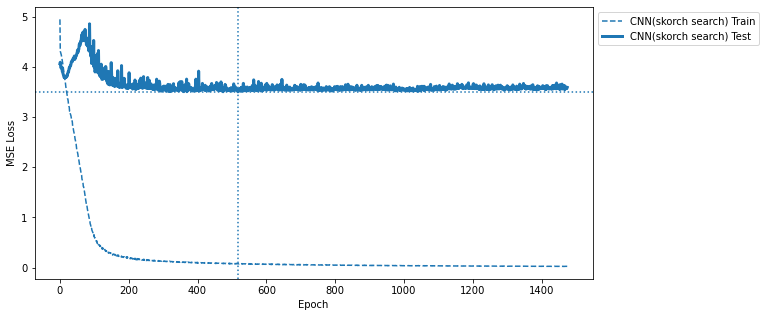

In [132]:
#tu.quick_loss_plot(cnn_data_label+se_skorch_cnn_data_label)
tu.quick_loss_plot(se_skorch_cnn_data_label)

TRAIN
Running 2cnn2fc skorch search


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:580: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


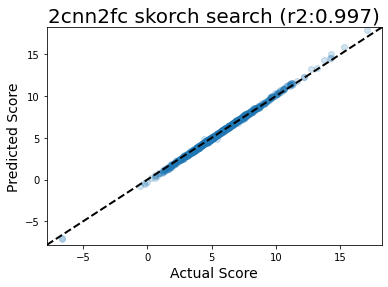

VAL
Running 2cnn2fc skorch search


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:580: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


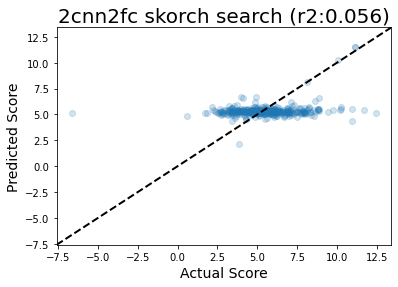

TEST
Running 2cnn2fc skorch search


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:580: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


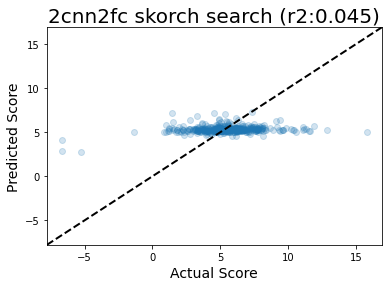

In [134]:
models = [
    #("2cnn2fc",model_cnn),
    #("2cnn2fc skorch",net_regr.module_)
    ("2cnn2fc skorch search",search.best_estimator_.module_)
]

print("TRAIN")
train_dfs = tu.parity_pred_loci(models,train_df,DEVICE,seq_col='upstream_region',target_col='highCu')
print("VAL")
val_dfs = tu.parity_pred_loci(models,val_df,DEVICE,seq_col='upstream_region',target_col='highCu')
print("TEST")
test_dfs  = tu.parity_pred_loci(models,test_df,DEVICE,seq_col='upstream_region',target_col='highCu')


In [135]:
# what is going on here?

In [136]:
print('done')

done


In [146]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df.to_csv('hyp_search_result_logTPMhighCu.tsv',sep='\t')



In [147]:
res_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_optimizer', 'param_module__num_filters2',
       'param_module__num_filters1', 'param_module__kernel_size2',
       'param_module__kernel_size1', 'param_module__fc_node_num1',
       'param_module__dropout2', 'param_module__dropout1', 'param_lr',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score', 'opt_name'],
      dtype='object')

In [148]:
sm_res_df = res_df[["rank_test_score","mean_test_score","param_module__num_filters1","param_module__num_filters2","param_module__kernel_size1","param_module__kernel_size2","param_lr","param_module__fc_node_num1","param_module__dropout1","param_module__dropout2","opt_name"]]



In [149]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N'),#scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [150]:
alt.Chart(sm_res_df).mark_point().encode(
    x='param_module__num_filters1:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N'),#scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size1:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__fc_node_num1:N"]
    
).interactive()

alt.Chart(...)

In [151]:
top_df = sm_res_df.sort_values('rank_test_score').head(100)

alt.Chart(top_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__kernel_size1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [152]:
alt.Chart(top_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__num_filters2:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [153]:
alt.Chart(top_df).mark_point(size=100).encode(
    x=alt.X('param_module__dropout1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__dropout2:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [ ]:
# STOPPED EHRE

Running 2cnn2fc


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


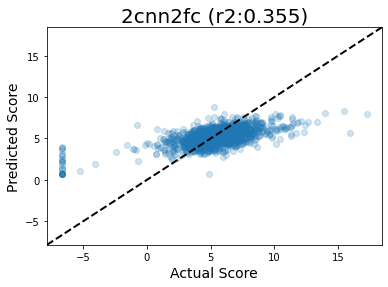

Running 2cnn2fc


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


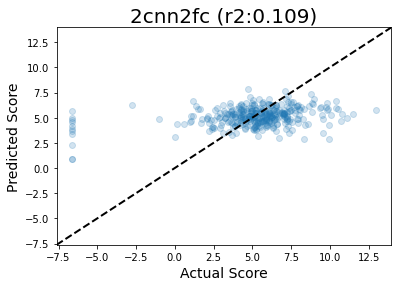

Running 2cnn2fc


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


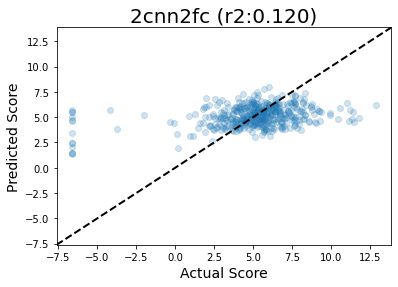

In [16]:
models = [
    ("2cnn2fc",model_cnn)
]

train_dfs = tu.parity_pred_loci(models,log_train_df,DEVICE,seq_col='upstream_region',target_col='highCu')
val_dfs = tu.parity_pred_loci(models,log_val_df,DEVICE,seq_col='upstream_region',target_col='highCu')
test_dfs  = tu.parity_pred_loci(models,log_test_df,DEVICE,seq_col='upstream_region',target_col='highCu')


## try fitting with skorch instead

In [103]:
def make_skorch_dfs(df,seq_col='seq',target_col='score'):
    '''
    Make basic X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    # had to unsqueeze here or else errors later
    
    return ohe_seqs.float(), labels.float()

In [18]:
X, y = make_skorch_dfs(log_full_train_df, seq_col='upstream_region',target_col='highCu')
print("X:",X.shape)
print("y:",y.shape)

X: torch.Size([1763, 300, 4])
y: torch.Size([1763, 1])


In [102]:
from skorch.callbacks import EarlyStopping,Checkpoint,LoadInitState

In [48]:
# Make a skorch regressor object
patience= 500
net_regr = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=1,
    max_epochs=5000,
    lr=0.001, # this is passed to the skorch fit, i think
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[EarlyStopping(patience=patience),Checkpoint(dirname='testcheck')]
)

In [49]:
# Just call fit!
net_regr.fit(X, y)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       29.5976       17.2151     +  0.0789
      2        9.3181       11.5839     +  0.0788
      3        7.6932       11.6101        0.0802
      4        7.6922       11.0863     +  0.0664
      5        7.6361       11.6947        0.0661
      6        7.6555       10.9969     +  0.0666
      7        7.6019       11.1316        0.0608
      8        7.5900       10.8508     +  0.0606
      9        7.5706       11.1595        0.0602
     10        7.6024       10.9887        0.0572
     11        7.5457       10.7897     +  0.0583
     12        7.5062       11.0450        0.0637
     13        7.5031       10.5972     +  0.0566
     14        7.4483       10.4520     +  0.0561
     15        7.4481       10.1970     +  0.0560
     16        7.4270        9.8129     +  0.0568
     17        7.3719        9.7207     +  0.0574
     18        7.3579        9.7704        0.0579


    140        4.1531        6.9776        0.0577
    141        4.0829        6.4011        0.0565
    142        4.0396        6.3967        0.0562
    143        4.0485        7.3621        0.0559
    144        4.4466        6.9246        0.0560
    145        3.9857        6.5039        0.0559
    146        3.9574        6.5865        0.0557
    147        3.9825        7.1090        0.0558
    148        3.9391        6.5032        0.0559
    149        3.8649        6.6239        0.0568
    150        3.9111        6.7198        0.0569
    151        3.7863        6.5249        0.0564
    152        3.7194        6.9365        0.0560
    153        4.1450        7.0142        0.0568
    154        3.8296        6.5825        0.0563
    155        3.7628        6.4631        0.0569
    156        3.8899        6.8431        0.0564
    157        3.6927        6.7209        0.0557
    158        3.7021        8.8138        0.0557
    159        3.9783        8.4961        0.0561


    296        2.0373        6.9392        0.0562
    297        1.8504        6.7590        0.0563
    298        1.8203        6.8621        0.0563
    299        1.7845        9.1464        0.0558
    300        2.0096        7.3129        0.0555
    301        1.8377        7.9594        0.0555
    302        2.1210        8.3320        0.0553
    303        1.9030        7.0832        0.0556
    304        1.9084        7.9583        0.0554
    305        2.1293       11.5824        0.0555
    306        2.1951        6.7769        0.0553
    307        1.8114        6.7816        0.0561
    308        1.6361        8.6996        0.0565
    309        1.8162        9.2994        0.0560
    310        2.4172        8.2343        0.0561
    311        1.7737        6.8526        0.0566
    312        1.6776        8.2362        0.0563
    313        1.7832        7.4114        0.0562
    314        1.8149        9.2031        0.0565
    315        1.8988        6.6955        0.0566


    455        1.1227        6.4739        0.0563
    456        0.8959        9.3608        0.0564
    457        1.1081        6.2100        0.0560
    458        0.8542        6.6780        0.0567
    459        0.8502        6.3122        0.0571
    460        0.7826        6.4572        0.0562
    461        0.8375        6.2809        0.0569
    462        0.8545        6.5608        0.0558
    463        0.8351        6.3125        0.0560
    464        0.7972        6.3560        0.0559
    465        0.8293        6.3583        0.0559
    466        0.8818        6.6524        0.0564
    467        0.8795        7.1026        0.0567
    468        0.8283        6.6184        0.0568
    469        0.8211        6.2662        0.0584
    470        0.8148        7.6809        0.0575
    471        1.1490        6.6461        0.0564
    472        0.8509        6.6611        0.0562
    473        0.9257        6.7391        0.0567
    474        0.8380        6.2587        0.0564


    616        0.8289        7.3991        0.0562
    617        0.6940        5.9243        0.0561
    618        0.6916        6.5201        0.0560
    619        0.6365        6.4980        0.0561
    620        0.6653        6.0010        0.0561
    621        0.6762        5.8708     +  0.0566
    622        0.6314        6.7384        0.0567
    623        0.6798        6.2368        0.0560
    624        0.6566        5.9734        0.0570
    625        0.6032        5.8853        0.0567
    626        0.6598        6.0661        0.0566
    627        0.6744        6.2199        0.0561
    628        0.6359        5.9476        0.0569
    629        0.6683        6.3409        0.0569
    630        0.6768        6.0644        0.0559
    631        0.6391        6.0865        0.0568
    632        0.6232        6.9660        0.0567
    633        0.6817        6.2440        0.0566
    634        0.6318        6.3627        0.0566
    635        0.7762        6.2174        0.0567


    778        0.6137        5.7697        0.0576
    779        0.5693        6.5021        0.0579
    780        0.5910        5.7434     +  0.0581
    781        0.5605        5.7411     +  0.0580
    782        0.5937        6.2684        0.0573
    783        0.5478        7.3215        0.0559
    784        0.6237        5.7986        0.0564
    785        0.5843        5.8220        0.0562
    786        0.5698        6.0411        0.0562
    787        0.5512        6.3026        0.0561
    788        0.5645        6.1841        0.0560
    789        0.6904        8.0606        0.0561
    790        0.7026        5.8595        0.0559
    791        0.5838        5.8252        0.0558
    792        0.5758        6.0947        0.0563
    793        0.5232        6.4981        0.0562
    794        0.5857        6.0050        0.0559
    795        0.5302        5.7752        0.0561
    796        0.5735        5.8996        0.0561
    797        0.5199        5.8290        0.0563


    939        0.4977        6.0076        0.0570
    940        0.4885        6.1238        0.0571
    941        0.5172        5.6915        0.0572
    942        0.4724        6.4864        0.0583
    943        0.5200        5.6641        0.0576
    944        0.4688        5.7264        0.0582
    945        0.4934        6.6488        0.0585
    946        0.5584        5.8630        0.0570
    947        0.4472        6.5650        0.0572
    948        0.5615        5.8118        0.0571
    949        0.5092        5.6727        0.0578
    950        0.4417        5.9753        0.0574
    951        0.5318        6.1719        0.0571
    952        0.5048        5.6107     +  0.0570
    953        0.4717        5.7070        0.0590
    954        0.4386        5.6825        0.0566
    955        0.4904        6.0619        0.0570
    956        0.4584        6.1074        0.0571
    957        0.4768        5.8526        0.0572
    958        0.5335        6.2794        0.0572


   1100        0.4270        5.4851     +  0.0567
   1101        0.4654        5.9580        0.0582
   1102        0.4523        5.5009        0.0573
   1103        0.4694        6.7120        0.0569
   1104        0.4936        5.4927        0.0563
   1105        0.4678        5.6192        0.0561
   1106        0.4547        6.0359        0.0561
   1107        0.4684        5.9515        0.0563
   1108        0.4731        5.5078        0.0574
   1109        0.4272        5.4710     +  0.0559
   1110        0.4523        6.0489        0.0579
   1111        0.4423        5.6590        0.0564
   1112        0.4265        5.5674        0.0567
   1113        0.4486        5.6371        0.0567
   1114        0.4371        5.7087        0.0567
   1115        0.4113        5.5636        0.0562
   1116        0.4173        5.4551     +  0.0567
   1117        0.4513        5.5648        0.0577
   1118        0.4110        6.1552        0.0566
   1119        0.4642        5.4790        0.0563


   1261        0.4126        5.9061        0.0570
   1262        0.4114        5.4241        0.0572
   1263        0.4105        5.6553        0.0569
   1264        0.3700        5.4534        0.0584
   1265        0.3847        5.3921        0.0576
   1266        0.3992        5.8268        0.0567
   1267        0.4067        5.6202        0.0566
   1268        0.4078        5.8201        0.0563
   1269        0.3971        5.3782     +  0.0563
   1270        0.3736        5.4144        0.0603
   1271        0.3878        5.5169        0.0593
   1272        0.3807        5.6411        0.0568
   1273        0.3989        5.4627        0.0566
   1274        0.3862        5.6889        0.0566
   1275        0.4459        5.3804        0.0575
   1276        0.3813        5.9197        0.0571
   1277        0.4150        5.5128        0.0571
   1278        0.4800        5.8287        0.0565
   1279        0.4018        5.3940        0.0573
   1280        0.4245        5.5185        0.0574


   1424        0.3680        5.6167        0.0569
   1425        0.3563        5.3365        0.0572
   1426        0.3668        5.7280        0.0573
   1427        0.3799        5.3548        0.0582
   1428        0.3638        5.3185        0.0565
   1429        0.3749        5.3149     +  0.0560
   1430        0.3604        5.6506        0.0605
   1431        0.3626        5.4244        0.0563
   1432        0.3783        5.4483        0.0560
   1433        0.3859        5.3330        0.0569
   1434        0.3709        5.4908        0.0571
   1435        0.3619        5.6965        0.0562
   1436        0.3919        5.3239        0.0564
   1437        0.3688        5.6740        0.0569
   1438        0.3804        5.3016     +  0.0566
   1439        0.3912        5.6988        0.0580
   1440        0.3828        5.4172        0.0563
   1441        0.3898        5.3554        0.0562
   1442        0.3795        5.4132        0.0575
   1443        0.3726        5.4492        0.0566


   1587        0.3719        5.4620        0.0568
   1588        0.3330        5.2583     +  0.0579
   1589        0.3458        5.5527        0.0586
   1590        0.3514        5.2793        0.0564
   1591        0.3406        5.3687        0.0570
   1592        0.3722        5.3540        0.0575
   1593        0.3491        5.3640        0.0571
   1594        0.3359        5.3304        0.0569
   1595        0.3439        5.5962        0.0575
   1596        0.3589        5.3016        0.0586
   1597        0.3551        5.3175        0.0568
   1598        0.3438        5.4333        0.0573
   1599        0.3484        5.3673        0.0578
   1600        0.3381        5.4288        0.0568
   1601        0.3534        5.3412        0.0577
   1602        0.3728        5.4253        0.0567
   1603        0.3341        5.5585        0.0569
   1604        0.3334        5.3002        0.0573
   1605        0.3520        5.3335        0.0566
   1606        0.3871        5.5979        0.0571


   1750        0.3500        5.3408        0.0574
   1751        0.3380        5.2919        0.0565
   1752        0.3322        5.2454        0.0569
   1753        0.3181        5.2138     +  0.0576
   1754        0.3427        5.6305        0.0594
   1755        0.3521        5.2383        0.0566
   1756        0.3512        5.2955        0.0581
   1757        0.3368        5.2291        0.0575
   1758        0.3095        5.2949        0.0569
   1759        0.3592        5.7635        0.0571
   1760        0.3699        5.3251        0.0570
   1761        0.3047        5.2376        0.0572
   1762        0.3406        5.5876        0.0573
   1763        0.3490        5.3545        0.0568
   1764        0.3370        5.2256        0.0578
   1765        0.3288        5.2353        0.0569
   1766        0.3512        5.2653        0.0570
   1767        0.3199        5.7220        0.0578
   1768        0.3428        5.2397        0.0566
   1769        0.3273        5.4548        0.0572


   1913        0.3478        5.3504        0.0571
   1914        0.3051        5.2065        0.0571
   1915        0.3543        5.1978        0.0573
   1916        0.3602        5.2605        0.0569
   1917        0.3397        5.3763        0.0572
   1918        0.3178        5.2740        0.0572
   1919        0.3277        5.2002        0.0571
   1920        0.3171        5.6739        0.0576
   1921        0.3654        5.4210        0.0576
   1922        0.3268        5.2260        0.0566
   1923        0.3264        5.3584        0.0571
   1924        0.3143        5.2899        0.0576
   1925        0.3109        5.3409        0.0582
   1926        0.3247        5.2348        0.0566
   1927        0.3396        5.4508        0.0572
   1928        0.3416        5.1992        0.0567
   1929        0.3221        5.6709        0.0570
   1930        0.3355        5.2555        0.0567
   1931        0.3779        5.2025        0.0563
   1932        0.3346        5.1855        0.0573


   2077        0.3115        5.2930        0.0572
   2078        0.2939        5.2105        0.0580
   2079        0.3008        5.3598        0.0572
   2080        0.2914        5.5343        0.0570
   2081        0.3255        5.1913        0.0572
   2082        0.3081        5.1799        0.0588
   2083        0.3637        5.2843        0.0574
   2084        0.2760        5.3167        0.0573
   2085        0.3020        5.2567        0.0586
   2086        0.3079        5.1677        0.0582
   2087        0.3306        5.2126        0.0570
   2088        0.2933        5.4014        0.0574
   2089        0.3203        5.2027        0.0571
   2090        0.3179        5.5868        0.0571
   2091        0.3103        5.1749        0.0567
   2092        0.3142        5.2288        0.0572
   2093        0.2993        5.2204        0.0571
   2094        0.2853        5.3495        0.0573
   2095        0.3240        5.2054        0.0583
   2096        0.2975        5.1625        0.0590


   2240        0.2886        5.1391        0.0572
   2241        0.3139        5.3970        0.0572
   2242        0.3301        5.1393        0.0573
   2243        0.3070        5.1796        0.0566
   2244        0.2875        5.2362        0.0572
   2245        0.2970        5.2376        0.0585
   2246        0.2809        5.3476        0.0587
   2247        0.3240        5.1365        0.0577
   2248        0.3026        5.3864        0.0591
   2249        0.3070        5.1171     +  0.0573
   2250        0.2988        5.2527        0.0597
   2251        0.3153        5.2072        0.0605
   2252        0.3214        5.1340        0.0594
   2253        0.2956        5.4302        0.0578
   2254        0.3070        5.1793        0.0573
   2255        0.2957        5.1180        0.0576
   2256        0.3063        5.2793        0.0572
   2257        0.3022        5.1972        0.0575
   2258        0.2788        5.1888        0.0564
   2259        0.2844        5.1440        0.0571


   2404        0.2789        5.3758        0.0585
   2405        0.3042        5.1388        0.0590
   2406        0.2768        5.1212        0.0586
   2407        0.3004        5.1632        0.0577
   2408        0.2952        5.3840        0.0584
   2409        0.3214        5.1395        0.0574
   2410        0.2637        5.1280        0.0580
   2411        0.2863        5.1784        0.0582
   2412        0.2807        5.1937        0.0583
   2413        0.3009        5.2567        0.0582
   2414        0.2740        5.1794        0.0594
   2415        0.2687        5.2850        0.0581
   2416        0.2919        5.1311        0.0580
   2417        0.2795        5.1240        0.0577
   2418        0.2734        5.1437        0.0584
   2419        0.2948        5.1467        0.0584
   2420        0.2777        5.4270        0.0587
   2421        0.3025        5.1566        0.0602
   2422        0.2803        5.2383        0.0605
   2423        0.2634        5.1314        0.0591


   2567        0.2781        5.1140        0.0600
   2568        0.2700        5.2698        0.0603
   2569        0.2848        5.1670        0.0576
   2570        0.2782        5.1203        0.0580
   2571        0.2792        5.1955        0.0578
   2572        0.2789        5.1786        0.0573
   2573        0.2747        5.1298        0.0573
   2574        0.3025        5.1047        0.0575
   2575        0.2906        5.4488        0.0581
   2576        0.2955        5.1956        0.0576
   2577        0.2875        5.2350        0.0580
   2578        0.2566        5.0990        0.0579
   2579        0.2743        5.1901        0.0586
   2580        0.2654        5.1082        0.0578
   2581        0.2736        5.1014        0.0585
   2582        0.2988        5.1078        0.0575
   2583        0.2971        5.2141        0.0573
   2584        0.2744        5.2352        0.0580
   2585        0.2726        5.2214        0.0576
   2586        0.2955        5.1082        0.0573


   2731        0.2727        5.0956        0.0577
   2732        0.2743        5.0871        0.0573
   2733        0.2775        5.1656        0.0578
   2734        0.2785        5.1885        0.0580
   2735        0.2508        5.0712        0.0574
   2736        0.2621        5.5996        0.0581
   2737        0.3171        5.0730        0.0580
   2738        0.2602        5.0582     +  0.0573
   2739        0.2747        5.0680        0.0623
   2740        0.2540        5.0694        0.0595
   2741        0.2669        5.0814        0.0592
   2742        0.2733        5.2815        0.0591
   2743        0.2724        5.0945        0.0588
   2744        0.2703        5.1578        0.0589
   2745        0.2969        5.0696        0.0582
   2746        0.3057        5.3010        0.0574
   2747        0.3005        5.0696        0.0575
   2748        0.2755        5.0914        0.0596
   2749        0.2730        5.1383        0.0575
   2750        0.2529        5.1349        0.0573


   2894        0.2767        5.1102        0.0587
   2895        0.2979        5.1568        0.0581
   2896        0.2673        5.1222        0.0585
   2897        0.2891        5.2457        0.0582
   2898        0.2527        5.0580        0.0596
   2899        0.2601        5.0965        0.0570
   2900        0.2617        5.0858        0.0583
   2901        0.2837        5.0901        0.0594
   2902        0.2536        5.1393        0.0608
   2903        0.2455        5.2980        0.0595
   2904        0.2844        5.0681        0.0576
   2905        0.2769        5.1587        0.0580
   2906        0.2558        5.0645        0.0580
   2907        0.2830        5.2521        0.0570
   2908        0.2790        5.0717        0.0579
   2909        0.2949        5.2046        0.0584
   2910        0.2666        5.0776        0.0588
   2911        0.2781        5.0812        0.0589
   2912        0.2524        5.1543        0.0574
   2913        0.2851        5.1113        0.0575


   3058        0.2565        5.2068        0.0588
   3059        0.2637        5.0510        0.0573
   3060        0.2444        5.1150        0.0584
   3061        0.2677        5.0588        0.0576
   3062        0.2610        5.2469        0.0586
   3063        0.2586        5.1249        0.0574
   3064        0.2456        5.1390        0.0574
   3065        0.2435        5.0473        0.0576
   3066        0.2785        5.0639        0.0576
   3067        0.2784        5.2775        0.0573
   3068        0.2711        5.0462        0.0571
   3069        0.2733        5.0453        0.0584
   3070        0.2498        5.0518        0.0578
   3071        0.2556        5.2725        0.0581
   3072        0.2982        5.1354        0.0580
   3073        0.2727        5.0712        0.0583
   3074        0.2703        5.0902        0.0576
   3075        0.2564        5.1503        0.0582
   3076        0.2560        5.1502        0.0576
   3077        0.2588        5.0474        0.0576


   3222        0.2561        5.0283     +  0.0586
   3223        0.2623        5.0781        0.0592
   3224        0.2454        5.0660        0.0576
   3225        0.2570        5.0467        0.0578
   3226        0.2743        5.0424        0.0583
   3227        0.2598        5.0907        0.0585
   3228        0.2487        5.0578        0.0582
   3229        0.2510        5.0306        0.0578
   3230        0.2755        5.0623        0.0579
   3231        0.2712        5.1108        0.0579
   3232        0.2498        5.1144        0.0573
   3233        0.2530        5.1814        0.0577
   3234        0.2682        5.0655        0.0583
   3235        0.2647        5.0733        0.0572
   3236        0.2509        5.0248     +  0.0579
   3237        0.2538        5.0463        0.0595
   3238        0.2378        5.1481        0.0576
   3239        0.2703        5.2133        0.0579
   3240        0.2524        5.0405        0.0575
   3241        0.2372        5.0359        0.0573


   3385        0.2774        5.0369        0.0580
   3386        0.2520        5.0579        0.0577
   3387        0.2579        5.1288        0.0587
   3388        0.2434        5.1430        0.0592
   3389        0.2348        5.0356        0.0581
   3390        0.2409        5.1452        0.0600
   3391        0.2349        5.0046     +  0.0583
   3392        0.2532        5.1660        0.0589
   3393        0.2427        5.0149        0.0588
   3394        0.2506        5.0277        0.0580
   3395        0.2500        5.0345        0.0584
   3396        0.2463        5.3653        0.0596
   3397        0.2981        5.0380        0.0590
   3398        0.2457        5.0970        0.0581
   3399        0.2708        5.0992        0.0583
   3400        0.2316        5.0181        0.0585
   3401        0.2518        5.0174        0.0576
   3402        0.2689        5.1534        0.0586
   3403        0.2656        5.0086        0.0585
   3404        0.2473        5.0335        0.0577


   3549        0.2689        5.0310        0.0578
   3550        0.2570        5.0975        0.0579
   3551        0.2474        5.0472        0.0574
   3552        0.2319        5.0269        0.0584
   3553        0.2591        5.0156        0.0573
   3554        0.2489        5.0637        0.0589
   3555        0.2492        5.0892        0.0581
   3556        0.2389        5.0245        0.0594
   3557        0.2577        5.0259        0.0582
   3558        0.2346        5.1904        0.0580
   3559        0.2683        5.0359        0.0578
   3560        0.2591        5.0119        0.0580
   3561        0.2628        5.0727        0.0583
   3562        0.2441        5.0331        0.0584
   3563        0.2496        5.0681        0.0578
   3564        0.2466        5.0303        0.0577
   3565        0.2348        5.1244        0.0580
   3566        0.2238        5.0774        0.0574
   3567        0.2424        5.0554        0.0585
   3568        0.2491        5.0244        0.0580


   3713        0.2245        5.0489        0.0590
   3714        0.2222        5.0963        0.0578
   3715        0.2648        5.0334        0.0580
   3716        0.2492        5.0109        0.0582
   3717        0.2372        5.1025        0.0576
   3718        0.2414        5.0089        0.0580
   3719        0.2514        5.0792        0.0577
   3720        0.2445        5.0529        0.0588
   3721        0.2359        5.0009        0.0581
   3722        0.2410        5.0164        0.0576
   3723        0.2395        5.0138        0.0587
   3724        0.2571        4.9945     +  0.0588
   3725        0.2386        5.0152        0.0586
   3726        0.2542        5.0484        0.0578
   3727        0.2442        5.0403        0.0575
   3728        0.2477        4.9985        0.0587
   3729        0.2486        5.0481        0.0588
   3730        0.2483        5.0089        0.0594
   3731        0.2414        4.9918     +  0.0584
   3732        0.2391        5.0449        0.0599


   3876        0.2539        5.0218        0.0581
   3877        0.2373        5.0022        0.0581
   3878        0.2187        4.9882        0.0584
   3879        0.2223        4.9911        0.0603
   3880        0.2279        5.1797        0.0586
   3881        0.2419        5.0139        0.0576
   3882        0.2331        5.0053        0.0587
   3883        0.2542        5.0459        0.0592
   3884        0.2575        5.0138        0.0591
   3885        0.2292        5.0233        0.0586
   3886        0.2269        5.0892        0.0584
   3887        0.2622        5.0467        0.0589
   3888        0.2267        5.0137        0.0580
   3889        0.2232        5.0639        0.0589
   3890        0.2315        5.0141        0.0581
   3891        0.2358        5.1002        0.0592
   3892        0.2261        5.0021        0.0591
   3893        0.2608        4.9976        0.0588
   3894        0.2196        4.9930        0.0583
   3895        0.2469        5.1163        0.0594


   4040        0.2415        5.0490        0.0604
   4041        0.2370        4.9893        0.0600
   4042        0.2336        5.0329        0.0609
   4043        0.2343        5.0349        0.0601
   4044        0.2417        5.0047        0.0593
   4045        0.2264        4.9991        0.0607
   4046        0.2194        4.9855        0.0588
   4047        0.2171        4.9859        0.0590
   4048        0.2235        5.0043        0.0593
   4049        0.2560        5.0793        0.0581
   4050        0.2388        4.9805        0.0595
   4051        0.2364        5.0812        0.0597
   4052        0.2403        5.0109        0.0597
   4053        0.2597        5.0385        0.0602
   4054        0.2391        5.0775        0.0624
   4055        0.2253        5.1285        0.0606
   4056        0.2490        5.0150        0.0605
   4057        0.2398        5.0147        0.0637
   4058        0.2329        5.0266        0.0610
   4059        0.2310        5.0523        0.0595


   4203        0.2327        4.9623        0.0579
   4204        0.2294        5.0031        0.0594
   4205        0.2313        4.9643        0.0583
   4206        0.2299        5.0210        0.0581
   4207        0.2237        4.9630        0.0584
   4208        0.2328        4.9724        0.0579
   4209        0.2472        4.9840        0.0584
   4210        0.2321        5.0233        0.0590
   4211        0.2348        4.9492        0.0582
   4212        0.2248        4.9644        0.0591
   4213        0.2428        4.9414     +  0.0594
   4214        0.2219        4.9688        0.0608
   4215        0.2404        4.9433        0.0585
   4216        0.2519        5.0201        0.0587
   4217        0.2334        4.9525        0.0579
   4218        0.2359        4.9740        0.0584
   4219        0.2338        4.9466        0.0594
   4220        0.2243        4.9407     +  0.0587
   4221        0.2439        5.1148        0.0593
   4222        0.2489        5.0726        0.0581


   4366        0.2398        5.0357        0.0591
   4367        0.2351        4.9482        0.0604
   4368        0.2313        4.9685        0.0603
   4369        0.2254        4.9833        0.0581
   4370        0.2522        4.9517        0.0595
   4371        0.2323        5.0608        0.0589
   4372        0.2352        4.9618        0.0582
   4373        0.2266        4.9569        0.0585
   4374        0.2285        4.9736        0.0585
   4375        0.2222        4.9623        0.0597
   4376        0.2288        4.9857        0.0593
   4377        0.2373        4.9500        0.0581
   4378        0.2273        4.9578        0.0579
   4379        0.2311        4.9428        0.0593
   4380        0.2369        5.0213        0.0587
   4381        0.2147        4.9413        0.0599
   4382        0.2533        5.0025        0.0589
   4383        0.2263        5.0761        0.0591
   4384        0.2455        4.9532        0.0590
   4385        0.2408        4.9443        0.0583


   4529        0.2257        4.9525        0.0591
   4530        0.2325        4.9389        0.0585
   4531        0.2201        4.9427        0.0595
   4532        0.2226        4.9454        0.0619
   4533        0.2324        5.0098        0.0589
   4534        0.2209        4.9359        0.0596
   4535        0.2275        4.9540        0.0596
   4536        0.2283        4.9366        0.0600
   4537        0.2588        4.9777        0.0591
   4538        0.2405        4.9483        0.0593
   4539        0.2297        4.9671        0.0605
   4540        0.2253        4.9557        0.0607
   4541        0.2232        4.9752        0.0592
   4542        0.2414        4.9444        0.0591
   4543        0.2092        5.0059        0.0597
   4544        0.2305        4.9420        0.0586
   4545        0.2275        4.9331        0.0580
   4546        0.2449        4.9919        0.0589
   4547        0.2422        4.9320        0.0591
   4548        0.2298        4.9369        0.0602


   4693        0.2389        4.9404        0.0598
   4694        0.2325        4.9364        0.0609
   4695        0.2345        4.9491        0.0590
   4696        0.2212        4.9271        0.0597
   4697        0.2381        4.9285        0.0614
   4698        0.2110        5.0590        0.0604
   4699        0.2402        4.9341        0.0592
   4700        0.2262        4.9406        0.0598
   4701        0.2171        4.9302        0.0598
   4702        0.2330        4.9404        0.0591
   4703        0.2202        4.9310        0.0590
   4704        0.2212        4.9487        0.0597
   4705        0.2131        4.9447        0.0605
   4706        0.2215        4.9202     +  0.0613
   4707        0.2175        4.9737        0.0615
   4708        0.2262        4.9297        0.0600
   4709        0.2267        4.9658        0.0596
   4710        0.2052        4.9388        0.0591
   4711        0.2349        4.9201     +  0.0601
   4712        0.2227        4.9942        0.0611


   4857        0.2320        4.9157        0.0588
   4858        0.2335        4.9334        0.0607
   4859        0.2204        4.9263        0.0612
   4860        0.2207        4.9387        0.0586
   4861        0.2211        4.9216        0.0592
   4862        0.2261        4.9333        0.0615
   4863        0.2131        4.9466        0.0594
   4864        0.2250        4.9291        0.0594
   4865        0.2181        4.9621        0.0589
   4866        0.2262        4.9876        0.0607
   4867        0.2226        4.9335        0.0591
   4868        0.2157        4.9543        0.0600
   4869        0.2270        4.9479        0.0599
   4870        0.2064        4.9179        0.0598
   4871        0.2258        4.9449        0.0607
   4872        0.2121        4.9229        0.0593
   4873        0.2272        4.9265        0.0594
   4874        0.2251        4.9315        0.0592
   4875        0.2298        4.9662        0.0606
   4876        0.2254        4.9179        0.0592


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=9152, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=10, bias=True)
      (11): ReLU()
      (12): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [130]:
def get_ep_val_best_from_skorch_history(history):
    for x in history[::-1]:
        ep = x['epoch']
        if x['valid_loss_best'] == True:
            best_val_loss = x['valid_loss']
            print("best val loss:",best_val_loss)
            print("epoch of best val loss:",ep)

            return ep, best_val_loss
    else:
        raise ValueError("Nothing had the best valid loss?? HOw?")



In [41]:
e,v = get_ep_val_best_from_skorch_history(net_regr.history)
sk_train_loss = net_regr.history[:, 'train_loss']
sk_valid_loss = net_regr.history[:, 'valid_loss']

skorch_cnn_data_label = [((sk_train_loss,sk_valid_loss),'CNN(skorch)',e,v)]


NameError: name 'net_regr' is not defined

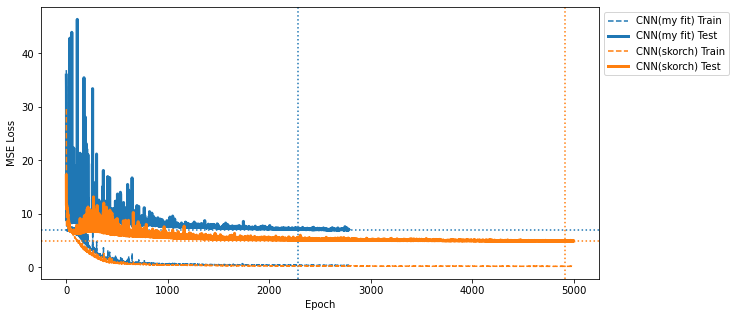

In [61]:
tu.quick_loss_plot(cnn_data_label+skorch_cnn_data_label)

In [64]:
#y_pred = net_regr.predict(X[:5])
y_pred = net_regr.predict(X)
y_pred = torch.tensor(y_pred).to(DEVICE)

net_regr.get_loss(y_pred, y)


tensor(1.0685, device='cuda:0')

TRAIN
Running 2cnn2fc
<class 'list'>


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


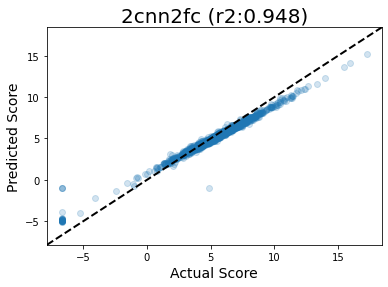

Running 2cnn2fc skorch
<class 'list'>


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


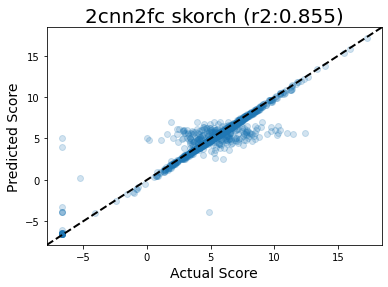

VAL
Running 2cnn2fc
<class 'list'>


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


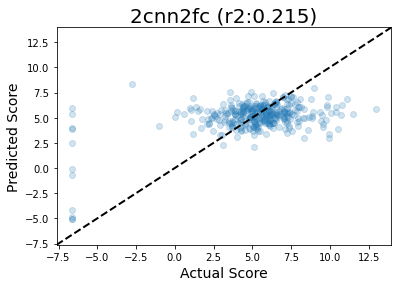

/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


Running 2cnn2fc skorch
<class 'list'>


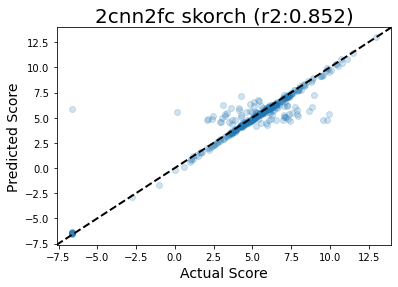

TEST
Running 2cnn2fc
<class 'list'>


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


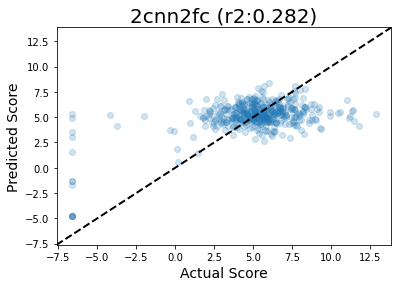

/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


Running 2cnn2fc skorch
<class 'list'>


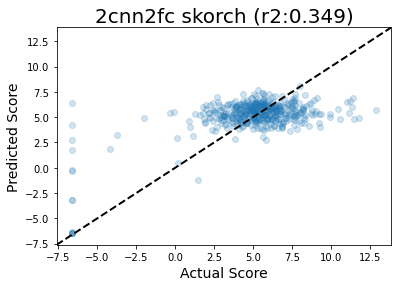

In [67]:
models = [
    ("2cnn2fc",model_cnn),
    ("2cnn2fc skorch",net_regr.module_)
]

print("TRAIN")
train_dfs = tu.parity_pred_loci(models,log_train_df,DEVICE,seq_col='upstream_region',target_col='highCu')
print("VAL")
val_dfs = tu.parity_pred_loci(models,log_val_df,DEVICE,seq_col='upstream_region',target_col='highCu')
print("TEST")
test_dfs  = tu.parity_pred_loci(models,log_test_df,DEVICE,seq_col='upstream_region',target_col='highCu')


TRAIN
Running 2cnn2fc skorch search


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


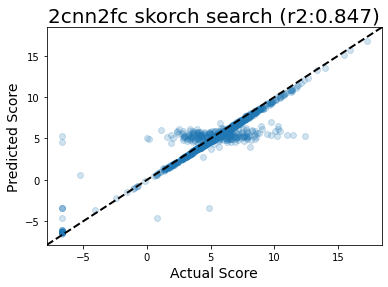

VAL
Running 2cnn2fc skorch search


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


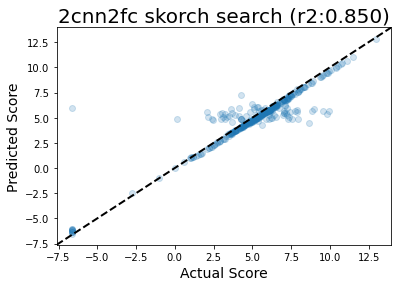

TEST
Running 2cnn2fc skorch search


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


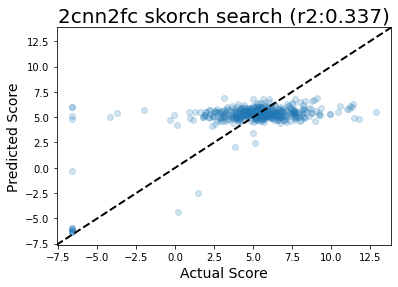

In [45]:
models = [
    #("2cnn2fc",model_cnn),
    #("2cnn2fc skorch",net_regr.module_)
    ("2cnn2fc skorch search",search.best_estimator_.module_)
]

print("TRAIN")
train_dfs = tu.parity_pred_loci(models,log_train_df,DEVICE,seq_col='upstream_region',target_col='highCu')
print("VAL")
val_dfs = tu.parity_pred_loci(models,log_val_df,DEVICE,seq_col='upstream_region',target_col='highCu')
print("TEST")
test_dfs  = tu.parity_pred_loci(models,log_test_df,DEVICE,seq_col='upstream_region',target_col='highCu')


## Compare some scores of the model combos tested

In [46]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       938.771109    337.646361         0.028403        0.001497   
1       705.801808    338.047381         0.030491        0.005556   
2       310.998677    251.366559         0.024290        0.003364   
3       748.583678     73.815758         0.054438        0.007465   
4       410.571679    330.833965         0.024324        0.001039   
..             ...           ...              ...             ...   
295     412.846778    102.414406         0.025207        0.003069   
296     178.531110     10.385877         0.023729        0.004155   
297     230.921245     13.109617         0.019103        0.003201   
298     141.601910     32.358291         0.022476        0.002962   
299     436.717302     85.932255         0.017879        0.005208   

                           param_optimizer param_module__num_filters2  \
0    <class 'torch.optim.rmsprop.RMSprop'>                         64   
1            <class 'torch.optim.sgd.SGD'>                        128   
2            <class 'torch.optim.sgd.SGD'>                         64   
3    <class 'torch.optim.rmsprop.RMSprop'>                        128   
4          <class 'torch.optim.adam.Adam'>                         64   
..                                     ...                        ...   
295        <class 'torch.optim.adam.Adam'>                         64   
296      <class 'torch.optim.adamw.AdamW'>                         64   
297      <class 'torch.optim.adamw.AdamW'>                         32   
298        <class 'torch.optim.adam.Adam'>                         64   
299      <class 'torch.optim.adamw.AdamW'>                         32   

    param_module__num_filters1 param_module__kernel_size2  \
0                           64                         32   
1                           16                         16   
2                           16                          8   
3                          128                         32   
4                           16                         16   
..                         ...                        ...   
295                         64                         16   
296                         16                         32   
297                         16                          8   
298                         32                         16   
299                         64                         32   

    param_module__kernel_size1 param_module__fc_node_num1  ...  \
0                            4                         10  ...   
1                           32                        100  ...   
2                            4                         25  ...   
3                           16                        100  ...   
4                           32                         10  ...   
..                         ...                        ...  ...   
295                         16                         50  ...   
296                          8                         50  ...   
297                          8                         25  ...   
298                         16                         25  ...   
299                          4                        100  ...   

    param_module__dropout1 param_lr  \
0                      0.4  0.00001   
1                      0.0  0.00001   
2                      0.0    0.001   
3                      0.2  0.00001   
4                      0.2   0.0001   
..                     ...      ...   
295                    0.0  0.00001   
296                    0.0   0.0001   
297                    0.2  0.00001   
298                    0.0   0.0001   
299                    0.2    0.001   

                                                params split0_test_score  \
0    {'optimizer': <class 'torch.optim.rmsprop.RMSp...         -7.208943   
1    {'optimizer': <class 'torch.optim.sgd.SGD'>, '...         -6.206729   
2    {'optimizer': <class 'torch.optim.sgd.SGD'>, '...         -6.319531   


In [48]:
sm_res_df = res_df[["rank_test_score","mean_test_score","param_module__num_filters1","param_module__num_filters2","param_module__kernel_size1","param_module__kernel_size2","param_lr","param_module__fc_node_num1","param_module__dropout1","param_module__dropout2","opt_name"]]

# Now try with log ratio Copper values

In [58]:
lr_data_filename = "data/XY_lr_noCu_opFilt.tsv"
XY_lr = pd.read_csv(lr_data_filename,sep='\t')

display(XY_lr.head())

og_index      locus_tag                                    upstream_region  \
0         0  EQU24_RS00005  ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...   
1         1  EQU24_RS00010  GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...   
2         2  EQU24_RS00015  TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...   
3         4  EQU24_RS00025  GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...   
4        11  EQU24_RS00060  GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...   

       uMax  lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  \
0  0.230893          -0.311506 -0.524588 -0.926510   0.0  0.018495  0.109974   
1  0.008729          -0.466359 -0.830462 -1.656433   0.0  0.124663  0.407828   
2  0.263911          -0.048943 -0.612371 -0.615279   0.0  0.057550  0.246420   
3 -0.034904          -0.574712 -0.655377 -1.555096   0.0 -0.032478 -0.034485   
4  0.002609           0.003625 -1.075138 -1.341292   0.0 -0.076037  0.095018   

      lowCu  highO2_slow_growth  NO3_lowO2_slow_growth  WithLanthanum  \
0 -0.045442            0.546757              -0.468551      -0.322610   
1  0.037725            0.731449              -0.449818      -0.512788   
2  0.028300            0.666104              -0.404861      -0.453445   
3  0.032271            0.643267              -0.257761      -0.540832   
4 -0.064943           -0.476696              -0.238368       0.268194   

   NoLanthanum  
0    -0.407143  
1    -0.448725  
2    -0.286782  
3    -0.234343  
4     0.339613

In [59]:
XY_log.head()

og_index      locus_tag                                    upstream_region  \
0         0  EQU24_RS00005  ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...   
1         1  EQU24_RS00010  GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...   
2         2  EQU24_RS00015  TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...   
3         4  EQU24_RS00025  GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...   
4        11  EQU24_RS00060  GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...   

       uMax  lowO2_fast_growth    lowCH4      MeOH      NoCu     medCu  \
0  5.701712           5.159314  4.946232  4.544309  5.470820  5.489315   
1  5.906680           5.431592  5.067489  4.241518  5.897951  6.022614   
2  5.085045           4.772192  4.208764  4.205855  4.821135  4.878684   
3  5.604311           5.064503  4.983838  4.084119  5.639215  5.606737   
4  4.766245           4.767261  3.688497  3.422344  4.763636  4.687598   

     highCu     lowCu  highO2_slow_growth  NO3_lowO2_slow_growth  \
0  5.580793  5.425377            6.017577               5.002269   
1  6.305779  5.935676            6.629400               5.448133   
2  5.067555  4.849435            5.487238               4.416274   
3  5.604730  5.671486            6.282482               5.381454   
4  4.858654  4.698693            4.286940               4.525268   

   WithLanthanum  NoLanthanum  gene  \
0       5.148210     5.063677  dnaA   
1       5.385163     5.449226   NaN   
2       4.367689     4.534353  recF   
3       5.098383     5.404872   NaN   
4       5.031830     5.103249   NaN   

                                             product  
0     chromosomal replication initiator protein DnaA  
1                    DNA polymerase III subunit beta  
2                DNA replication/repair protein RecF  
3                               hypothetical protein  
4  bifunctional diguanylate cyclase/phosphodieste...

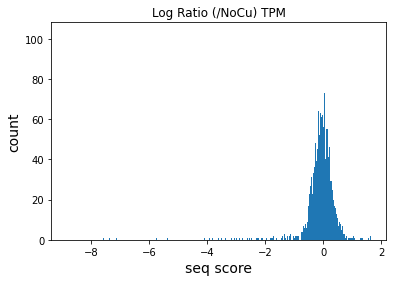

In [62]:
# Log TPM - highCu column
plt.hist(XY_lr['highCu'].values,bins=500)
plt.title("score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("Log Ratio (/NoCu) TPM")
plt.show()

In [63]:
# LOG
lr_full_train_df,lr_test_df = tu.quick_split(XY_lr)
lr_train_df, lr_val_df = tu.quick_split(lr_full_train_df)

print(lr_full_train_df.shape)
print(lr_test_df.shape)
print(lr_train_df.shape)
print(lr_val_df.shape)

assert(lr_train_df.shape[0] + lr_val_df.shape[0] == lr_full_train_df.shape[0])

(1763, 16)
(441, 16)
(1410, 17)
(353, 17)


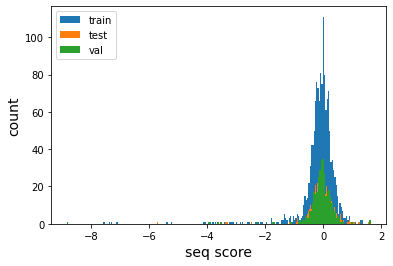

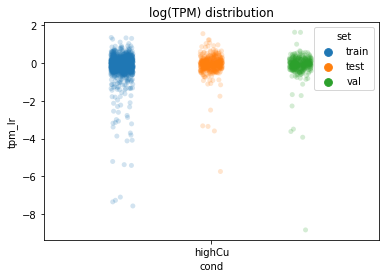

In [64]:
plot_train_test_hist(lr_train_df, lr_test_df, val_df=lr_val_df,score_col='highCu',bins=200)
view_train_test_dist(lr_train_df, lr_test_df,["highCu"],"log(TPM)",val_df=lr_val_df)

In [65]:
# Dfs for the full train/test split
lr_final_dls = tu.build_dataloaders_single(
    lr_full_train_df, 
    lr_test_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu')

# Dfs from further spliting train into train and val
lr_dls = tu.build_dataloaders_single(
    lr_train_df, 
    lr_val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu'
)

lr_kmer6_train_dl,lr_kmer6_val_dl = lr_dls['kmer_6']
lr_kmer3_train_dl,lr_kmer3_val_dl = lr_dls['kmer_3']
lr_ohe_train_dl,lr_ohe_val_dl = lr_dls['ohe']

E:264 | train loss:0.466 | val loss: 0.451:   5%|▌         | 263/5000 [00:13<04:00, 19.73it/s]

EarlyStopping counter: 125 out of 500


E:1119 | train loss:0.414 | val loss: 0.448:  22%|██▏       | 1119/5000 [00:57<03:16, 19.72it/s]

EarlyStopping counter: 125 out of 500


E:1244 | train loss:0.394 | val loss: 0.450:  25%|██▍       | 1245/5000 [01:03<03:10, 19.76it/s]

EarlyStopping counter: 250 out of 500


E:1369 | train loss:0.369 | val loss: 0.455:  27%|██▋       | 1369/5000 [01:09<03:03, 19.75it/s]

EarlyStopping counter: 375 out of 500


E:1491 | train loss:0.336 | val loss: 0.473:  30%|██▉       | 1491/5000 [01:15<02:58, 19.63it/s]


EarlyStopping counter: 500 out of 500
Early stopping


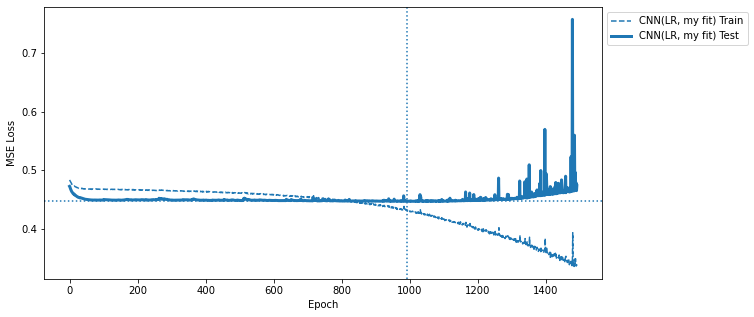

In [66]:
seq_len = len(lr_train_df['upstream_region'].values[0])
model_cnn = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
)
model_cnn.to(DEVICE)

loss_func = torch.nn.MSELoss() 

train_losses_cnn, \
val_losses_cnn, \
epoch_stop, \
best_val_score = tu.run_model(
    lr_ohe_train_dl,
    lr_ohe_val_dl, 
    model_cnn, 
    loss_func, 
    DEVICE,
    lr=0.001, 
    epochs=5000, 
    opt=None,
    patience=500)

# to plot loss
cnn_data_label = [((train_losses_cnn,val_losses_cnn),'CNN(LR, my fit)',epoch_stop,best_val_score)]
tu.quick_loss_plot(cnn_data_label)

Running 2cnn2fc


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


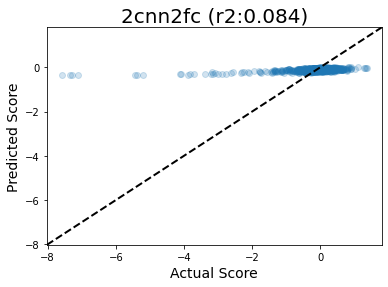

Running 2cnn2fc


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


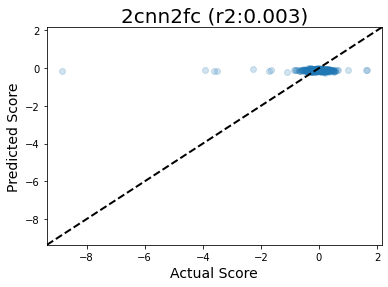

Running 2cnn2fc


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


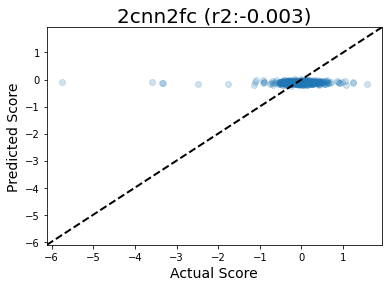

In [67]:
models = [
    ("2cnn2fc",model_cnn)
]

train_dfs = tu.parity_pred_loci(models,lr_train_df,DEVICE,seq_col='upstream_region',target_col='highCu')
val_dfs = tu.parity_pred_loci(models,lr_val_df,DEVICE,seq_col='upstream_region',target_col='highCu')
test_dfs  = tu.parity_pred_loci(models,lr_test_df,DEVICE,seq_col='upstream_region',target_col='highCu')


In [68]:
X, y = make_skorch_dfs(lr_full_train_df, seq_col='upstream_region',target_col='highCu')
print("X:",X.shape)
print("y:",y.shape)

X: torch.Size([1763, 300, 4])
y: torch.Size([1763, 1])


In [73]:
# Make a skorch regressor object
patience= 500
net_regr = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    module__seq_len=seq_len, # pass arg to pytorch model
    module__n_tasks=1,
    max_epochs=5000,
    lr=0.001, # this is passed to the skorch fit, i think
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[EarlyStopping(patience=patience),Checkpoint(dirname='testcheck')]
)

In [74]:
net_regr.fit(X, y)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.6309        0.3412     +  0.0811
      2        0.6228        0.3358     +  0.0787
      3        0.6157        0.3311     +  0.0720
      4        0.6089        0.3268     +  0.0695
      5        0.6032        0.3228     +  0.0693
      6        0.5971        0.3192     +  0.0637
      7        0.5917        0.3158     +  0.0647
      8        0.5868        0.3125     +  0.0628
      9        0.5816        0.3096     +  0.0598
     10        0.5768        0.3068     +  0.0598
     11        0.5722        0.3042     +  0.0582
     12        0.5679        0.3019     +  0.0574
     13        0.5641        0.2998     +  0.0578
     14        0.5604        0.2979     +  0.0581
     15        0.5571        0.2962     +  0.0589
     16        0.5540        0.2947     +  0.0572
     17        0.5510        0.2933     +  0.0588
     18        0.5483        0.2920     +  0.0565


    141        0.5066        0.2862        0.0565
    142        0.5070        0.2862        0.0573
    143        0.5069        0.2862        0.0576
    144        0.5069        0.2862        0.0583
    145        0.5069        0.2862        0.0582
    146        0.5071        0.2862        0.0569
    147        0.5071        0.2862        0.0573
    148        0.5067        0.2863        0.0576
    149        0.5063        0.2863        0.0573
    150        0.5063        0.2863        0.0569
    151        0.5065        0.2863        0.0562
    152        0.5066        0.2863        0.0560
    153        0.5066        0.2863        0.0565
    154        0.5067        0.2863        0.0561
    155        0.5070        0.2863        0.0562
    156        0.5066        0.2863        0.0569
    157        0.5069        0.2863        0.0570
    158        0.5067        0.2863        0.0572
    159        0.5063        0.2863        0.0577
    160        0.5065        0.2862        0.0571


    300        0.5015        0.2877        0.0578
    301        0.5014        0.2875        0.0584
    302        0.5019        0.2876        0.0583
    303        0.5015        0.2874        0.0583
    304        0.5029        0.2875        0.0574
    305        0.5016        0.2874        0.0571
    306        0.5016        0.2874        0.0564
    307        0.5015        0.2875        0.0573
    308        0.5007        0.2876        0.0569
    309        0.5011        0.2877        0.0585
    310        0.5008        0.2877        0.0569
    311        0.5011        0.2878        0.0576
    312        0.5015        0.2877        0.0570
    313        0.5017        0.2878        0.0576
    314        0.5019        0.2876        0.0574
    315        0.5005        0.2874        0.0578
    316        0.5006        0.2875        0.0569
    317        0.5013        0.2876        0.0580
    318        0.5012        0.2875        0.0565
    319        0.5012        0.2876        0.0578


    458        0.4885        0.2875        0.0581
    459        0.4864        0.2876        0.0581
    460        0.4865        0.2875        0.0595
    461        0.4865        0.2878        0.0588
    462        0.4879        0.2883        0.0585
    463        0.4873        0.2886        0.0569
    464        0.4852        0.2885        0.0564
    465        0.4852        0.2887        0.0572
    466        0.4855        0.2881        0.0572
    467        0.4854        0.2884        0.0561
    468        0.4862        0.2886        0.0560
    469        0.4861        0.2880        0.0568
    470        0.4846        0.2880        0.0569
    471        0.4844        0.2879        0.0578
    472        0.4842        0.2880        0.0578
    473        0.4834        0.2881        0.0574
    474        0.4834        0.2880        0.0582
    475        0.4845        0.2880        0.0571
    476        0.4834        0.2876        0.0567
    477        0.4833        0.2879        0.0582


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=9152, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=10, bias=True)
      (11): ReLU()
      (12): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [75]:
e,v = get_ep_val_best_from_skorch_history(net_regr.history)
sk_train_loss = net_regr.history[:, 'train_loss']
sk_valid_loss = net_regr.history[:, 'valid_loss']

skorch_cnn_data_label = [((sk_train_loss,sk_valid_loss),'CNN(LR, skorch)',e,v)]


best val loss: 0.2821469601591991
epoch of best val loss: 43


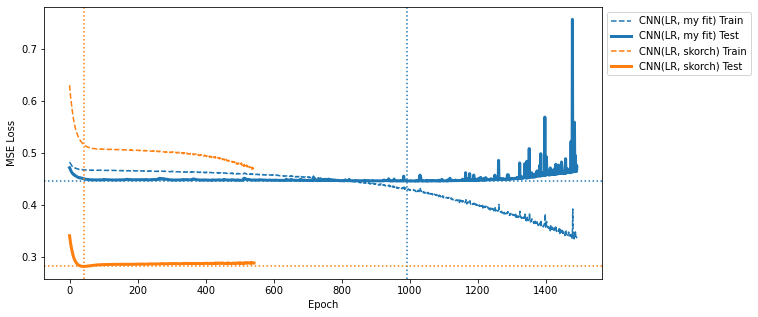

In [76]:
tu.quick_loss_plot(cnn_data_label+skorch_cnn_data_label)

Running 2cnn2fc


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


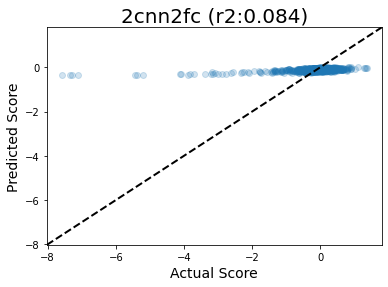

/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Running 2cnn2fc skorch


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


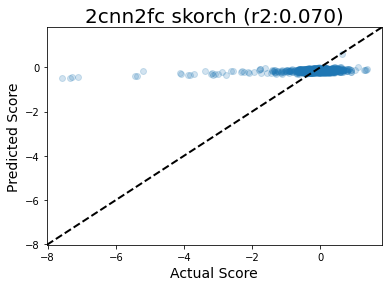

Running 2cnn2fc


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


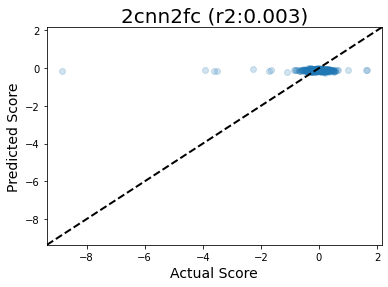

/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


Running 2cnn2fc skorch


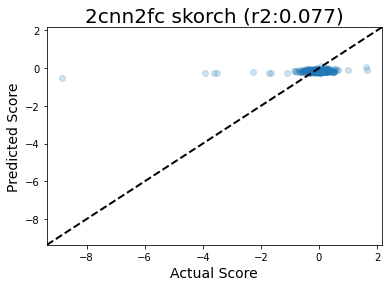

Running 2cnn2fc


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


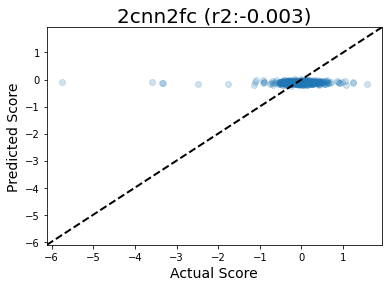

/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


Running 2cnn2fc skorch


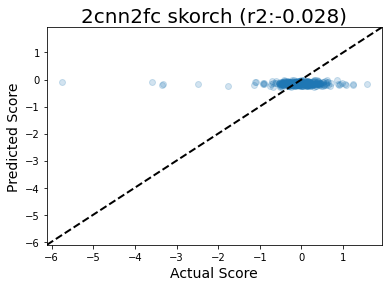

In [77]:
models = [
    ("2cnn2fc",model_cnn),
    ("2cnn2fc skorch",net_regr.module_)
]

train_dfs = tu.parity_pred_loci(models,lr_train_df,DEVICE,seq_col='upstream_region',target_col='highCu')
val_dfs = tu.parity_pred_loci(models,lr_val_df,DEVICE,seq_col='upstream_region',target_col='highCu')
test_dfs  = tu.parity_pred_loci(models,lr_test_df,DEVICE,seq_col='upstream_region',target_col='highCu')


In [78]:
# Make a skorch regressor object
patience= 500
net_regr2 = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    module__seq_len=seq_len, # pass arg to pytorch model
    module__n_tasks=1,
    max_epochs=5000,
    lr=0.0001, # this is passed to the skorch fit, i think
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[EarlyStopping(patience=patience),Checkpoint(dirname='testcheck')]
)

In [79]:
net_regr2.fit(X, y)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.5765        0.3081     +  0.0792
      2        0.5759        0.3076     +  0.0803
      3        0.5750        0.3070     +  0.0779
      4        0.5735        0.3064     +  0.0706
      5        0.5731        0.3059     +  0.0688
      6        0.5724        0.3053     +  0.0688
      7        0.5707        0.3047     +  0.0632
      8        0.5698        0.3042     +  0.0621
      9        0.5694        0.3037     +  0.0620
     10        0.5681        0.3031     +  0.0626
     11        0.5679        0.3026     +  0.0599
     12        0.5660        0.3021     +  0.0609
     13        0.5658        0.3016     +  0.0600
     14        0.5643        0.3011     +  0.0579
     15        0.5634        0.3006     +  0.0584
     16        0.5627        0.3001     +  0.0567
     17        0.5616        0.2997     +  0.0582
     18        0.5611        0.2992     +  0.0570


    125        0.5165        0.2826     +  0.0578
    126        0.5155        0.2826        0.0587
    127        0.5159        0.2826        0.0575
    128        0.5156        0.2826        0.0573
    129        0.5152        0.2826        0.0566
    130        0.5154        0.2826        0.0561
    131        0.5151        0.2826        0.0560
    132        0.5150        0.2826        0.0568
    133        0.5144        0.2826        0.0562
    134        0.5147        0.2826        0.0569
    135        0.5146        0.2826        0.0558
    136        0.5141        0.2826        0.0560
    137        0.5145        0.2826        0.0568
    138        0.5144        0.2827        0.0570
    139        0.5138        0.2827        0.0587
    140        0.5143        0.2827        0.0573
    141        0.5138        0.2827        0.0568
    142        0.5137        0.2827        0.0573
    143        0.5134        0.2827        0.0564
    144        0.5137        0.2828        0.0557


    283        0.5073        0.2857        0.0575
    284        0.5074        0.2857        0.0587
    285        0.5080        0.2857        0.0591
    286        0.5084        0.2857        0.0578
    287        0.5080        0.2857        0.0572
    288        0.5072        0.2857        0.0578
    289        0.5076        0.2857        0.0563
    290        0.5076        0.2858        0.0560
    291        0.5074        0.2858        0.0558
    292        0.5080        0.2858        0.0568
    293        0.5074        0.2858        0.0560
    294        0.5081        0.2858        0.0566
    295        0.5080        0.2858        0.0573
    296        0.5077        0.2858        0.0569
    297        0.5083        0.2858        0.0573
    298        0.5077        0.2858        0.0576
    299        0.5077        0.2859        0.0574
    300        0.5078        0.2859        0.0573
    301        0.5073        0.2859        0.0564
    302        0.5079        0.2859        0.0564


    447        0.5071        0.2865        0.0570
    448        0.5064        0.2865        0.0581
    449        0.5068        0.2865        0.0580
    450        0.5072        0.2865        0.0579
    451        0.5065        0.2865        0.0571
    452        0.5074        0.2865        0.0572
    453        0.5065        0.2865        0.0571
    454        0.5061        0.2865        0.0561
    455        0.5066        0.2865        0.0567
    456        0.5064        0.2865        0.0567
    457        0.5066        0.2865        0.0594
    458        0.5066        0.2865        0.0568
    459        0.5061        0.2865        0.0568
    460        0.5065        0.2865        0.0578
    461        0.5070        0.2865        0.0584
    462        0.5063        0.2865        0.0575
    463        0.5068        0.2865        0.0569
    464        0.5071        0.2865        0.0582
    465        0.5063        0.2865        0.0578
    466        0.5066        0.2865        0.0563


    611        0.5059        0.2866        0.0558
    612        0.5064        0.2866        0.0561
    613        0.5052        0.2866        0.0566
    614        0.5061        0.2866        0.0562
    615        0.5061        0.2866        0.0562
    616        0.5056        0.2866        0.0559
    617        0.5058        0.2866        0.0559
    618        0.5053        0.2866        0.0566
    619        0.5056        0.2866        0.0573
    620        0.5053        0.2866        0.0570
    621        0.5058        0.2866        0.0579
Stopping since valid_loss has not improved in the last 500 epochs.


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=9152, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=10, bias=True)
      (11): ReLU()
      (12): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [80]:
e,v = get_ep_val_best_from_skorch_history(net_regr2.history)
sk_train_loss = net_regr2.history[:, 'train_loss']
sk_valid_loss = net_regr2.history[:, 'valid_loss']

skorch2_cnn_data_label = [((sk_train_loss,sk_valid_loss),'CNN(LR, skorch, slower)',e,v)]


best val loss: 0.2825695258530949
epoch of best val loss: 125


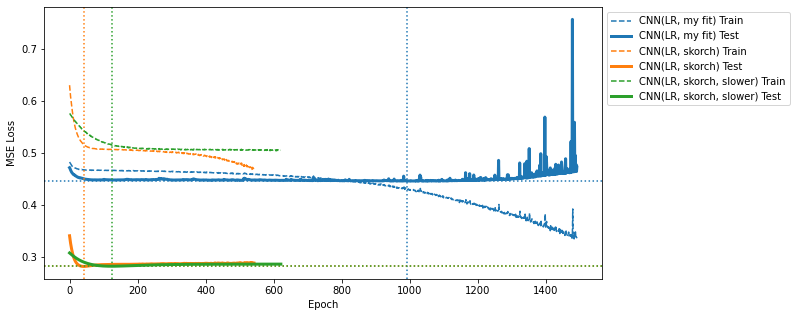

In [81]:
tu.quick_loss_plot(cnn_data_label+skorch_cnn_data_label+skorch2_cnn_data_label)

E:207 | train loss:0.319 | val loss: 0.466:   4%|▍         | 208/5000 [00:11<04:13, 18.87it/s]

EarlyStopping counter: 125 out of 500


E:332 | train loss:0.090 | val loss: 0.501:   7%|▋         | 332/5000 [00:17<04:05, 18.99it/s]

EarlyStopping counter: 250 out of 500


E:457 | train loss:0.025 | val loss: 0.481:   9%|▉         | 458/5000 [00:24<03:59, 19.00it/s]

EarlyStopping counter: 375 out of 500


E:579 | train loss:0.020 | val loss: 0.467:  12%|█▏        | 579/5000 [00:30<03:55, 18.75it/s]


EarlyStopping counter: 500 out of 500
Early stopping


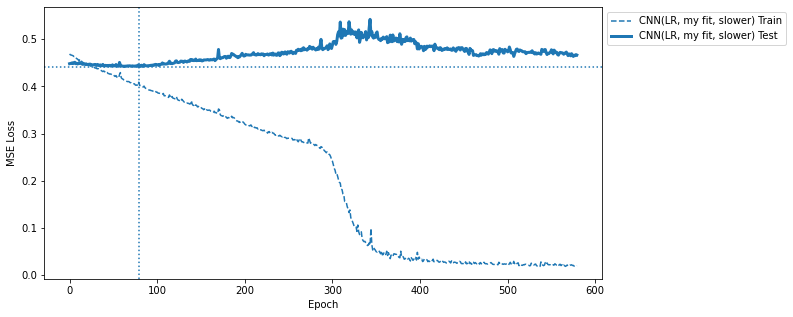

In [86]:
model_cnn2 = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
)
model_cnn2.to(DEVICE)

loss_func = torch.nn.MSELoss() 

train_losses_cnn, \
val_losses_cnn, \
epoch_stop, \
best_val_score = tu.run_model(
    lr_ohe_train_dl,
    lr_ohe_val_dl, 
    model_cnn2, 
    loss_func, 
    DEVICE,
    lr=0.0001, 
    epochs=5000, 
    opt=torch.optim.Adam(model_cnn2.parameters(), lr=0.0001),
    patience=500)

# to plot loss
cnn2_data_label = [((train_losses_cnn,val_losses_cnn),'CNN(LR, my fit, slower)',epoch_stop,best_val_score)]
tu.quick_loss_plot(cnn2_data_label)

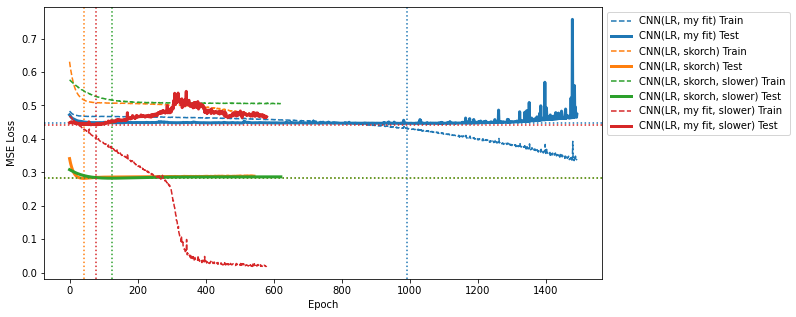

In [87]:
tu.quick_loss_plot(cnn_data_label+skorch_cnn_data_label+skorch2_cnn_data_label+cnn2_data_label)

Running 2cnn2fc adam, slow


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


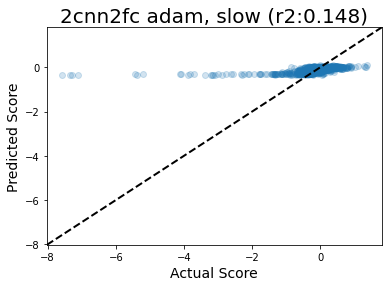

Running 2cnn2fc adam, slow


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


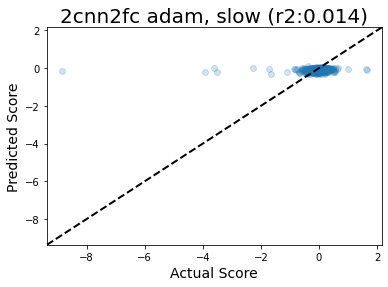

Running 2cnn2fc adam, slow


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


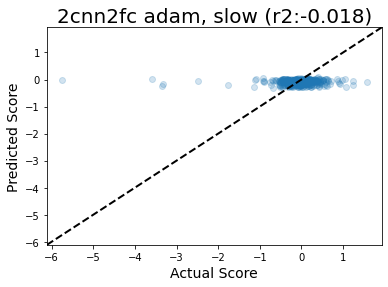

In [88]:
models = [
    #("2cnn2fc",model_cnn),
    #("2cnn2fc skorch",net_regr.module_)
    ("2cnn2fc adam, slow",model_cnn2),
]

train_dfs = tu.parity_pred_loci(models,lr_train_df,DEVICE,seq_col='upstream_region',target_col='highCu')
val_dfs = tu.parity_pred_loci(models,lr_val_df,DEVICE,seq_col='upstream_region',target_col='highCu')
test_dfs  = tu.parity_pred_loci(models,lr_test_df,DEVICE,seq_col='upstream_region',target_col='highCu')


In [89]:
# Make a skorch regressor object
patience= 500
net_regrA = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    module__seq_len=seq_len, # pass arg to pytorch model
    module__n_tasks=1,
    max_epochs=5000,
    lr=0.0001, # this is passed to the skorch fit, i think
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[EarlyStopping(patience=patience),Checkpoint(dirname='testcheck')],
    optimizer=torch.optim.Adam
)

In [90]:
net_regrA.fit(X, y)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.5081        0.2927     +  0.0834
      2        0.5064        0.2908     +  0.0844
      3        0.5069        0.2902     +  0.0846
      4        0.5065        0.2910        0.0803
      5        0.5058        0.2907        0.0724
      6        0.5054        0.2914        0.0738
      7        0.5047        0.2905        0.0672
      8        0.5039        0.2915        0.0648
      9        0.5032        0.2913        0.0641
     10        0.5030        0.2907        0.0618
     11        0.5023        0.2921        0.0624
     12        0.5004        0.2910        0.0605
     13        0.4996        0.2923        0.0592
     14        0.4988        0.2910        0.0599
     15        0.4972        0.2917        0.0591
     16        0.4959        0.2909        0.0588
     17        0.4949        0.2915        0.0595
     18        0.4933        0.2909        0.0586


    144        0.0883        0.3497        0.0587
    145        0.0904        0.3429        0.0579
    146        0.0878        0.3381        0.0580
    147        0.0867        0.3701        0.0588
    148        0.0962        0.3548        0.0579
    149        0.0855        0.3572        0.0580
    150        0.0862        0.3488        0.0580
    151        0.0877        0.3509        0.0585
    152        0.0861        0.3508        0.0578
    153        0.0834        0.3677        0.0587
    154        0.0850        0.3455        0.0579
    155        0.0815        0.3582        0.0583
    156        0.0845        0.3515        0.0584
    157        0.0787        0.3611        0.0581
    158        0.0778        0.3408        0.0579
    159        0.0798        0.3566        0.0578
    160        0.0800        0.3464        0.0585
    161        0.0769        0.3553        0.0582
    162        0.0779        0.3377        0.0585
    163        0.0796        0.3625        0.0586


    301        0.0457        0.3478        0.0604
    302        0.0455        0.3425        0.0601
    303        0.0439        0.3549        0.0610
    304        0.0451        0.3466        0.0597
    305        0.0452        0.3426        0.0591
    306        0.0426        0.3436        0.0588
    307        0.0446        0.3400        0.0591
    308        0.0467        0.3545        0.0584
    309        0.0481        0.3609        0.0584
    310        0.0454        0.3421        0.0594
    311        0.0444        0.3462        0.0594
    312        0.0463        0.3397        0.0598
    313        0.0444        0.3437        0.0600
    314        0.0458        0.3511        0.0595
    315        0.0440        0.3445        0.0597
    316        0.0459        0.3628        0.0601
    317        0.0456        0.3481        0.0594
    318        0.0411        0.3407        0.0583
    319        0.0444        0.3469        0.0594
    320        0.0443        0.3470        0.0596


    460        0.0273        0.3498        0.0589
    461        0.0283        0.3507        0.0583
    462        0.0287        0.3429        0.0603
    463        0.0279        0.3472        0.0584
    464        0.0290        0.3432        0.0587
    465        0.0284        0.3540        0.0605
    466        0.0289        0.3447        0.0603
    467        0.0266        0.3432        0.0611
    468        0.0255        0.3461        0.0607
    469        0.0274        0.3433        0.0595
    470        0.0288        0.3420        0.0598
    471        0.0263        0.3509        0.0597
    472        0.0273        0.3418        0.0586
    473        0.0268        0.3417        0.0584
    474        0.0276        0.3449        0.0592
    475        0.0268        0.3482        0.0596
    476        0.0269        0.3435        0.0588
    477        0.0280        0.3479        0.0592
    478        0.0265        0.3532        0.0590
    479        0.0276        0.3493        0.0601


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=9152, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=10, bias=True)
      (11): ReLU()
      (12): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [91]:
e,v = get_ep_val_best_from_skorch_history(net_regrA.history)
skA_train_loss = net_regrA.history[:, 'train_loss']
skA_valid_loss = net_regrA.history[:, 'valid_loss']

skorchA_cnn_data_label = [((skA_train_loss,skA_valid_loss),'CNN(LR, skorch, slower,Adam)',e,v)]


best val loss: 0.29022740942054026
epoch of best val loss: 3


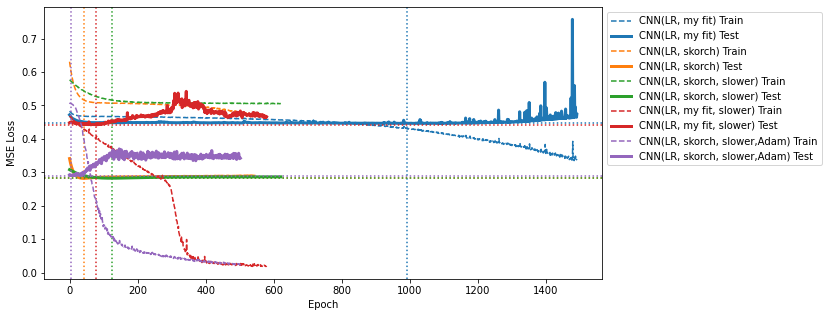

In [92]:
tu.quick_loss_plot(cnn_data_label+skorch_cnn_data_label+skorch2_cnn_data_label+cnn2_data_label+skorchA_cnn_data_label)

Running 2cnn2fc skorch, adam, slow


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


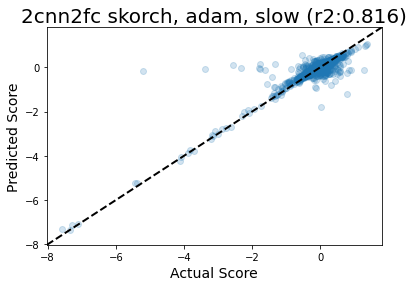

Running 2cnn2fc skorch, adam, slow


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


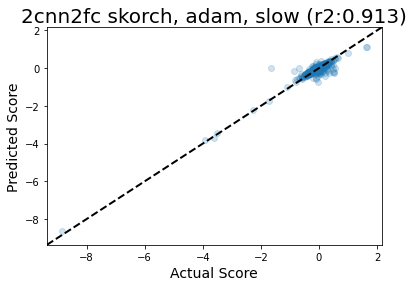

Running 2cnn2fc skorch, adam, slow


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


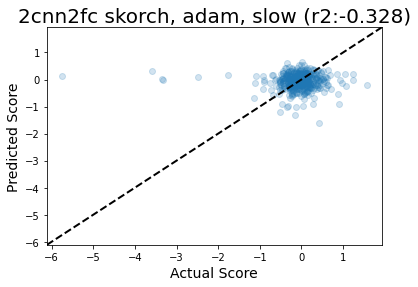

In [93]:
models = [
    #("2cnn2fc",model_cnn),
    #("2cnn2fc skorch",net_regr.module_)
    #("2cnn2fc adam, slow",model_cnn2),
    ("2cnn2fc skorch, adam, slow",net_regrA.module_),
]

train_dfs = tu.parity_pred_loci(models,lr_train_df,DEVICE,seq_col='upstream_region',target_col='highCu')
val_dfs = tu.parity_pred_loci(models,lr_val_df,DEVICE,seq_col='upstream_region',target_col='highCu')
test_dfs  = tu.parity_pred_loci(models,lr_test_df,DEVICE,seq_col='upstream_region',target_col='highCu')


In [ ]:
# ok somethingggg different is happening... explore more around this Adam area?

In [ ]:
# Old stuff

## Check prediction distributions

In [52]:
Xval, yval = make_skorch_dfs(log_val_df, seq_col='upstream_region',target_col='highCu')
Xtest, ytest = make_skorch_dfs(log_test_df, seq_col='upstream_region',target_col='highCu')



In [53]:
# y pred and pearson on training data
ypred_train_basic = net_regr.predict(X)
ypred_train_search = search.best_estimator_.predict(X)
p_train_basic = scipy.stats.pearsonr(np.array(y).flatten(),ypred_train_basic.flatten())
p_train_search = scipy.stats.pearsonr(np.array(y).flatten(),ypred_train_search.flatten())

# y pred and pearson on val data
ypred_val_basic = net_regr.predict(Xval)
ypred_val_search = search.best_estimator_.predict(Xval)
p_val_basic = scipy.stats.pearsonr(np.array(yval).flatten(),ypred_val_basic.flatten())
p_val_search = scipy.stats.pearsonr(np.array(yval).flatten(),ypred_val_search.flatten())

# y pred and pearson on test data
ypred_test_basic = net_regr.predict(Xtest)
ypred_test_search = search.best_estimator_.predict(Xtest)
p_test_basic = scipy.stats.pearsonr(np.array(ytest).flatten(),ypred_test_basic.flatten())
p_test_search = scipy.stats.pearsonr(np.array(ytest).flatten(),ypred_test_search.flatten())



In [54]:
def ytrue_pred_hist(y,ypred,title):
    plt.hist(ypred,alpha=0.2, label="Y Pred")
    plt.hist(np.array(y),alpha=0.2, label="Y True")
    plt.legend()
    plt.title(title)
    plt.show()
    

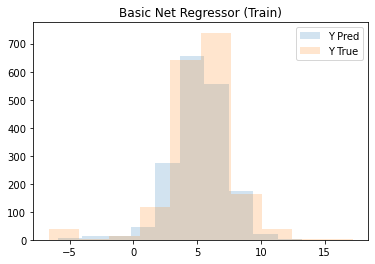

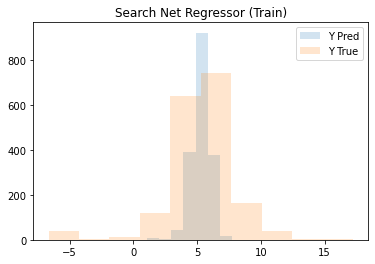

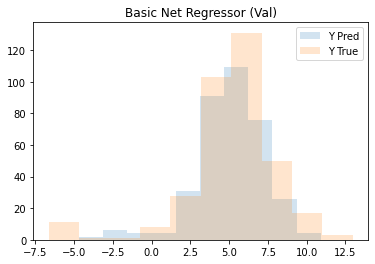

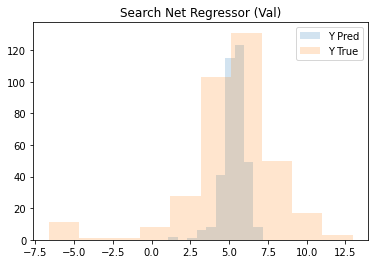

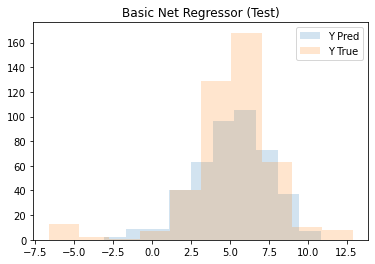

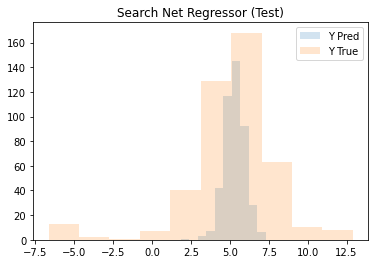

In [55]:
ytrue_pred_hist(y,ypred_train_basic,"Basic Net Regressor (Train)")
ytrue_pred_hist(y,ypred_train_search,"Search Net Regressor (Train)")

ytrue_pred_hist(yval,ypred_val_basic,"Basic Net Regressor (Val)")
ytrue_pred_hist(yval,ypred_val_search,"Search Net Regressor (Val)")

ytrue_pred_hist(ytest,ypred_test_basic,"Basic Net Regressor (Test)")
ytrue_pred_hist(ytest,ypred_test_search,"Search Net Regressor (Test)")

In [84]:
# def parity_plot(model,ytrue,ypred, pearson,rigid=False):
#     plt.scatter(ytrue, ypred, alpha=0.2)
    
#     # y=x line
#     xpoints = ypoints = plt.xlim()
#     if rigid:
#         plt.ylim(min(xpoints),max(xpoints)) 
#     plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

#     plt.xlabel("Actual Score",fontsize=14)
#     plt.ylabel("Predicted Score",fontsize=14)
#     plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
#     plt.show()



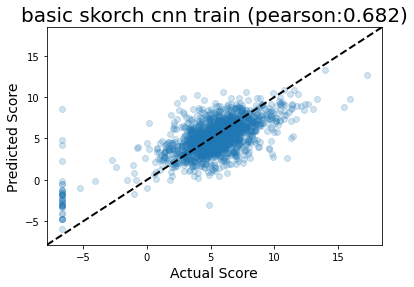

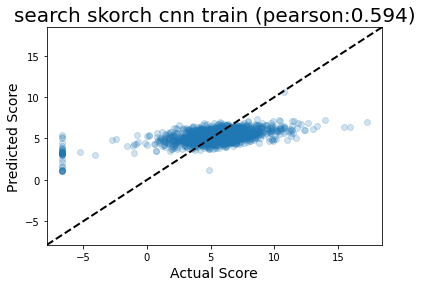

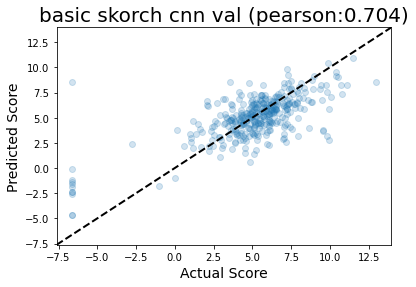

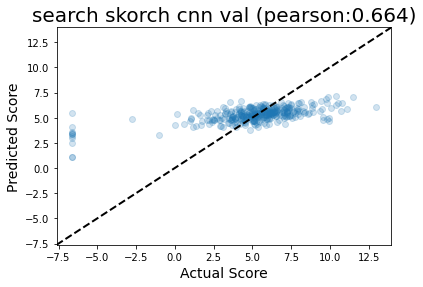

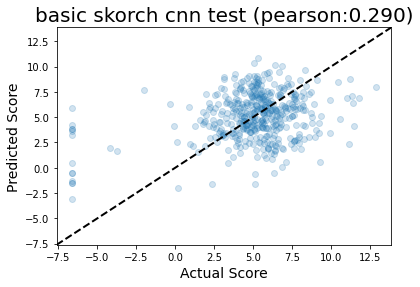

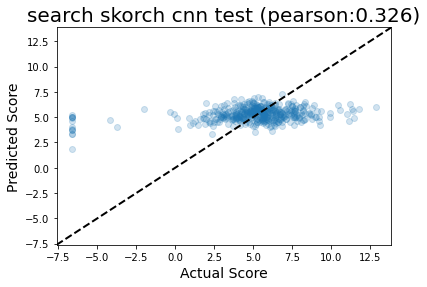

In [87]:
parity_plot("basic skorch cnn train", y, ypred_train_basic,p_train_basic[0],rigid=True)
parity_plot("search skorch cnn train", y, ypred_train_search,p_train_search[0],rigid=True)

parity_plot("basic skorch cnn val", yval, ypred_val_basic,p_val_basic[0],rigid=True)
parity_plot("search skorch cnn val", yval, ypred_val_search,p_val_search[0],rigid=True)

parity_plot("basic skorch cnn test", ytest, ypred_test_basic,p_test_basic[0],rigid=True)
parity_plot("search skorch cnn test", ytest, ypred_test_search,p_test_search[0],rigid=True)

In [51]:
b = search.best_estimator_
for i in b.module_.children():
    if type(i) == nn.Sequential:
        for child in i:
            if type(child) == nn.Conv2d:
                print(child.weight)

Parameter containing:
tensor([[[[ 3.4057e-02,  4.3642e-02, -1.9904e-01, -2.7334e-02],
          [-2.0415e-01, -1.3838e-01, -2.2525e-01,  1.6372e-01],
          [ 5.9070e-02,  1.4298e-01,  1.9506e-01, -2.2385e-01],
          [ 6.8632e-02, -2.0406e-01,  8.4021e-02, -2.0967e-01]]],


        [[[-1.1542e-01, -1.7631e-01, -6.6347e-02, -2.1405e-01],
          [ 9.5700e-02, -1.0333e-01,  1.9630e-01, -1.0735e-01],
          [-1.2648e-01,  1.3538e-01,  8.7525e-04,  1.5259e-01],
          [-1.8498e-01,  1.1219e-01,  6.2805e-02,  1.1183e-01]]],


        [[[ 1.8494e-01, -1.2967e-01, -1.4420e-01, -2.1125e-01],
          [ 1.0075e-02,  1.1691e-01, -1.2725e-03,  1.5102e-01],
          [ 1.5237e-01,  9.9624e-02, -6.9806e-02,  4.0394e-02],
          [ 2.1143e-01, -1.0865e-01, -1.8518e-01,  2.0652e-01]]],


        ...,


        [[[ 6.1595e-02, -1.4699e-01,  4.3739e-02,  2.3188e-01],
          [ 1.3863e-01, -3.9582e-02,  1.7993e-01, -8.9094e-02],
          [ 7.1283e-04, -5.9587e-02, -1.7954e-02, -2.26

In [58]:
b.score(Xtest,ytest)

0.09038980006140596

# Run skorch with a Pytorch data loader

In [202]:
net_dl = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    #lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
    iterator_train = log_ohe_train_dl,
    iterator_valid = log_ohe_val_dl
)

In [203]:
search_dl = RandomizedSearchCV(
    net_dl, 
    params, 
    n_iter=200, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=1,
    verbose=2
)

In [204]:
search_dl.fit(X, y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.0s finished


TypeError: 'DataLoader' object is not callable

The FAQ seems to say to NOT provide a Dataset if possible - skorch does Dataloader stuff under the hood? 

"skorch supports datasets as input but sklearn doesn’t. If it’s possible, you should provide your data in a non-dataset format, e.g. as a numpy array or torch tensor, extracted from your original dataset."
https://skorch.readthedocs.io/en/stable/user/FAQ.html#faq-how-do-i-use-a-pytorch-dataset-with-skorch

# Run Skorch with MT model

In [59]:
condition_file = 'data/conditions_to_include.txt'
with open(condition_file,'r') as f:
    conditions = list(x.strip() for x in f.readlines())
    
cond_dict = dict(enumerate(conditions))
cond_dict

{0: 'uMax',
 1: 'lowO2_fast_growth',
 2: 'lowCH4',
 3: 'MeOH',
 4: 'NoCu',
 5: 'medCu',
 6: 'highCu',
 7: 'lowCu',
 8: 'highO2_slow_growth',
 9: 'NO3_lowO2_slow_growth',
 10: 'WithLanthanum',
 11: 'NoLanthanum'}

In [60]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=5,
                 num_fc_nodes1=100,
                 num_fc_nodes2=10
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, num_fc_nodes1),
            nn.Linear(num_fc_nodes1, num_fc_nodes2),
        )
        # define the multi task objectives?
        self.obj0   = nn.Linear(num_fc_nodes2,1)
        self.obj1   = nn.Linear(num_fc_nodes2,1)
        self.obj2   = nn.Linear(num_fc_nodes2,1)
        self.obj3   = nn.Linear(num_fc_nodes2,1)
        self.obj4   = nn.Linear(num_fc_nodes2,1)
        self.obj5   = nn.Linear(num_fc_nodes2,1)
        self.obj6   = nn.Linear(num_fc_nodes2,1)
        self.obj7   = nn.Linear(num_fc_nodes2,1)
        self.obj8   = nn.Linear(num_fc_nodes2,1)
        self.obj9   = nn.Linear(num_fc_nodes2,1)
        self.obj10  = nn.Linear(num_fc_nodes2,1)
        self.obj11  = nn.Linear(num_fc_nodes2,1)
        

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        
        out0 = self.obj0(out).squeeze(1)
        out1 = self.obj1(out).squeeze(1)
        out2 = self.obj2(out).squeeze(1)
        out3 = self.obj3(out).squeeze(1)
        out4 = self.obj4(out).squeeze(1)
        out5 = self.obj5(out).squeeze(1)
        out6 = self.obj6(out).squeeze(1)
        out7 = self.obj7(out).squeeze(1)
        out8 = self.obj8(out).squeeze(1)
        out9 = self.obj9(out).squeeze(1)
        out10 = self.obj10(out).squeeze(1)
        out11 = self.obj11(out).squeeze(1)
        
        #print("out0", out0.shape)
        all_outs = torch.stack([out0,out1,out2,out3,out4,out5,out6,out7,out8,out9,out10,out11])
        #print("all_outs",all_outs.shape)
#         print("convert list to tensor?")
#         all_outs = torch.tensor(all_outs)
#         print(all_outs.shape)
        #print(all_outs)
#    shape fix here??
        #print("all_outs shape", all_outs.shape)
        #print("transpose?", all_outs.T.shape)
        
        #all_outs.squeeze(2)
        
        return all_outs.T

In [61]:
def make_multi_skorch_dfs(df,seq_col='seq',target_cols=conditions):
    ### EDIT THIS FOR MULTI TASK!
    
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [65]:
Xm,ym = make_multi_skorch_dfs(log_full_train_df, seq_col='upstream_region')
print("X:",X.shape)
print("y:",y.shape)

X: torch.Size([1763, 300, 4])
y: torch.Size([1763, 1])


In [66]:
mnet_regr = NeuralNetRegressor(
    DNA_CNN_Multi,
    module__seq_len=300,
    max_epochs=100,
    lr=0.0001,
    device='cuda',  # uncomment this to train with CUDA
)

In [67]:
mnet_regr.fit(Xm, ym)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       34.8529       33.7938  0.0651
      2       34.5523       33.5005  0.0627
      3       34.2513       33.2046  0.0628
      4       33.9460       32.9023  0.0620
      5       33.6326       32.5900  0.0629
      6       33.3075       32.2640  0.0620
      7       32.9666       31.9202  0.0617
      8       32.6058       31.5545  0.0624
      9       32.2207       31.1623  0.0621
     10       31.8064       30.7386  0.0621
     11       31.3577       30.2779  0.0625
     12       30.8685       29.7741  0.0629
     13       30.3325       29.2206  0.0622
     14       29.7425       28.6100  0.0634
     15       29.0908       27.9346  0.0634
     16       28.3692       27.1861  0.0627
     17       27.5692       26.3563  0.0619
     18       26.6822       25.4372  0.0620
     19       25.7005       24.4221  0.0629
     20       24.6180       23.3069  0.0622
     21       23.4316       22.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 31, kernel_size=(4, 5), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9176, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
    )
    (obj0): Linear(in_features=10, out_features=1, bias=True)
    (obj1): Linear(in_features=10, out_features=1, bias=True)
    (obj2): Linear(in_features=10, out_features=1, bias=True)
    (obj3): Linear(in_features=10, out_features=1, bias=True)
    (obj4): Linear(in_features=10, out_features=1, bias=True)
    (obj5): Linear(in_features=10, out_features=1, bias=True)
    (obj6): Linear(in_features=10, out_features=1, bias=True)
    (obj7): Linear(in_features=10, out_features=1, bias=True)
    (obj8): Linear(in_features=10, out_features=1, bias=True)
    (obj9): Linear(in_features=10, out_features=1, bias=True)
    (obj10): Linear(in_features=10, out_features=1, 

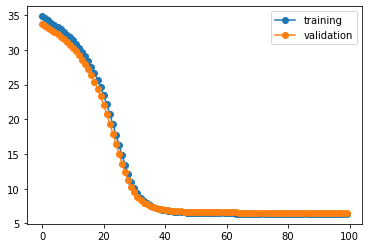

In [68]:
train_loss = mnet_regr.history[:, 'train_loss']
valid_loss = mnet_regr.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.legend()
plt.show()

In [69]:
ympred_train = mnet_regr.predict(Xm)
ympred_train.shape

(1763, 12)

### Loop through each task and look at parity plot?

In [85]:
def check_mt_pred_results(y,ypred,title):
    '''
    Check individual task predictions within MT?
    '''
    for i in cond_dict:
        task=cond_dict[i]
        subtitle = f"{task} - {title}"
        print(f"task:{task}")
        yi = y[:,i]
        ypredi = ypred[:,i]

        pr = scipy.stats.pearsonr(np.array(yi).flatten(),ypredi.flatten())
        ytrue_pred_hist(yi,ypredi,subtitle)
        parity_plot(f"skorch cnn {task}", yi, ypredi,pr[0],rigid=True)

task:uMax


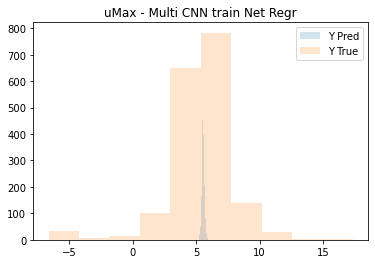

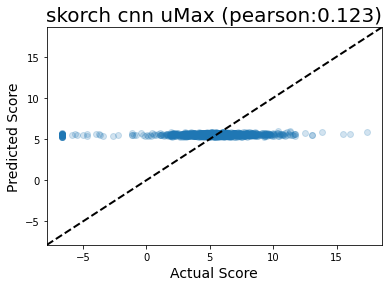

task:lowO2_fast_growth


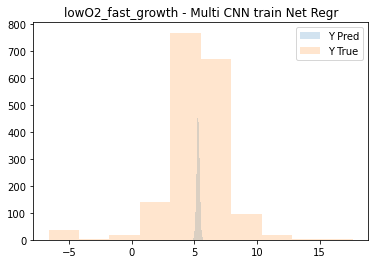

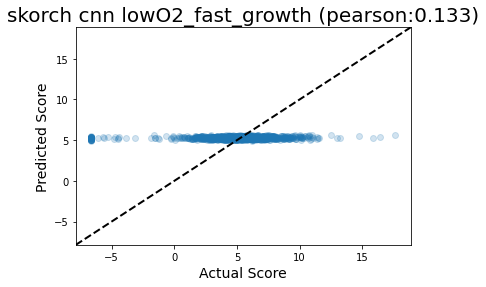

task:lowCH4


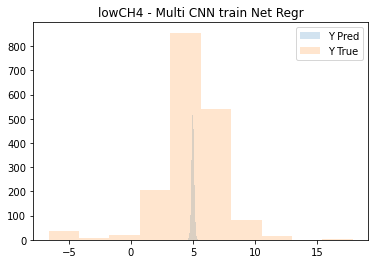

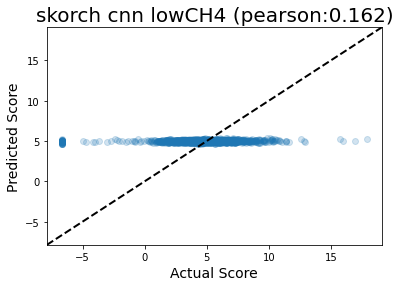

task:MeOH


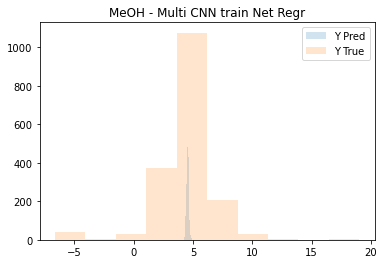

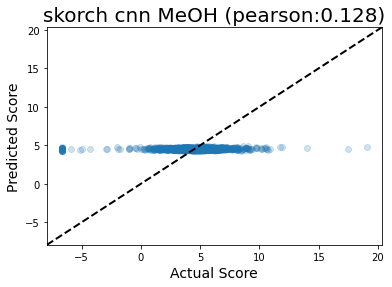

task:NoCu


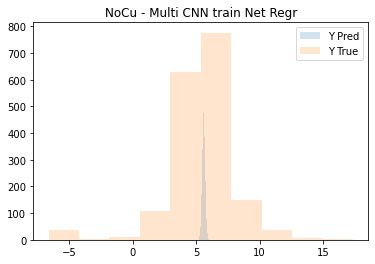

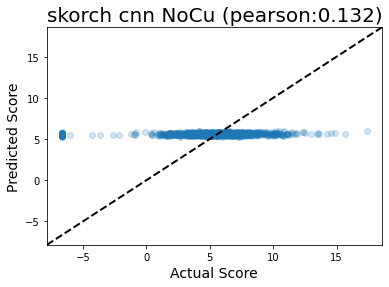

task:medCu


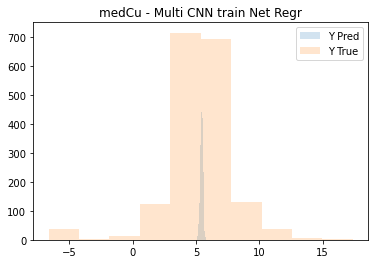

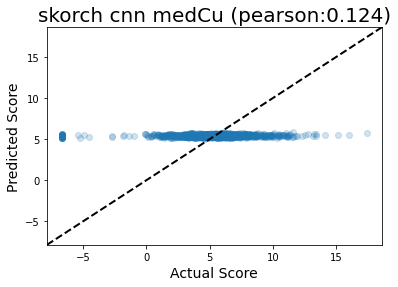

task:highCu


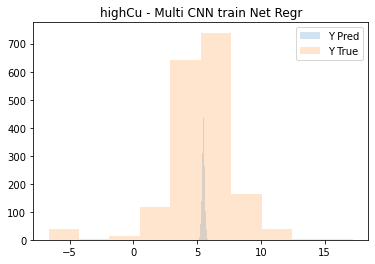

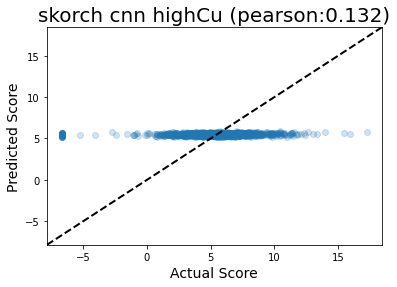

task:lowCu


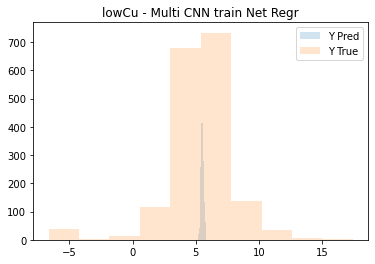

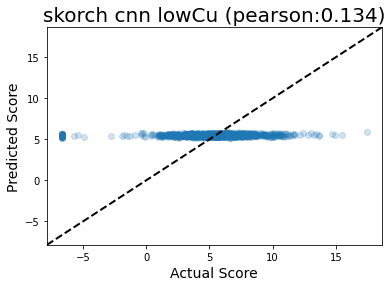

task:highO2_slow_growth


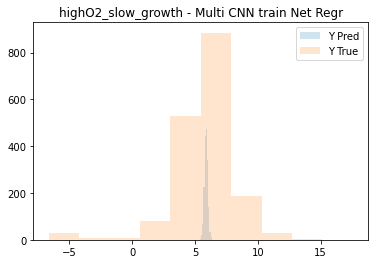

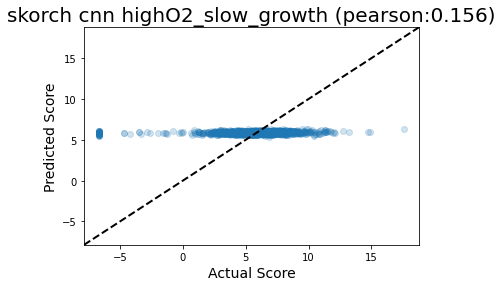

task:NO3_lowO2_slow_growth


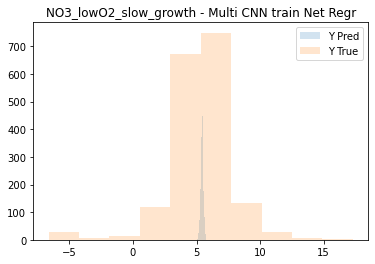

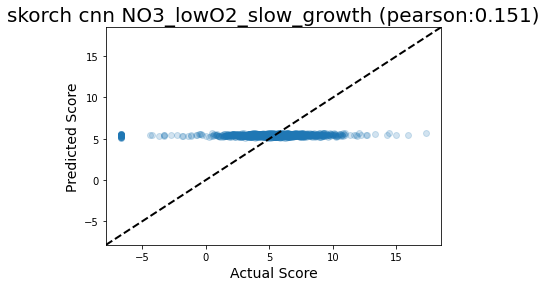

task:WithLanthanum


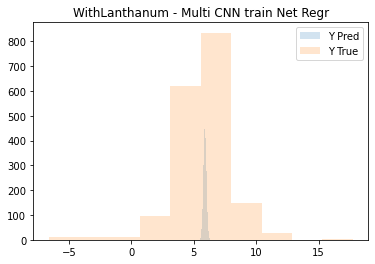

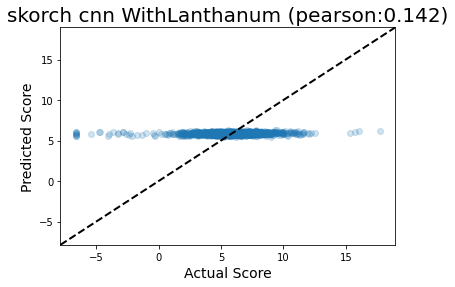

task:NoLanthanum


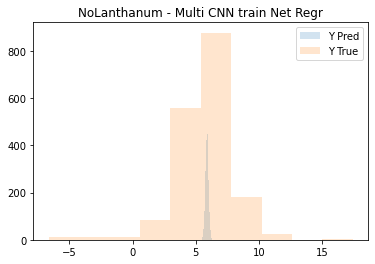

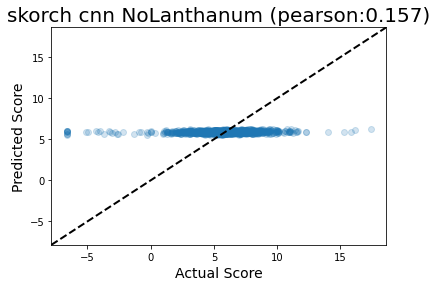

In [86]:
check_mt_pred_results(ym, ympred_train, "Multi CNN train Net Regr")

# skorch param search with MT

In [88]:
params = {
    'lr': [0.0005, 0.0001,0.00001],#loguniform(0.0001, 0.01)
    
    'module__num_filters': [16,32,64,128], # uniform(8,128), #
    'module__kernel_size': [4,8,16,32],
    'module__num_fc_nodes1': [10, 25, 50,100], #randint(10,100), #
    'optimizer':[torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer__nesterov': [False, True],
}

mnet_search = NeuralNetRegressor(
    DNA_CNN_Multi,
    module__seq_len=300,
    max_epochs=500,
    #lr=0.0001,
    device='cuda',  # uncomment this to train with CUDA
)

m_search = RandomizedSearchCV(
    mnet_search, 
    params, 
    n_iter=500, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=5,#cv, 
    random_state=1,
    verbose=2
)

In [89]:
m_search.fit(Xm, ym)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 86.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 147.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 227.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 328.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 448.6min


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       34.2929       32.3014  0.0699
      2       32.4298       30.6530  0.0684


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 565.9min finished


      3       30.7913       29.1553  0.0686
      4       29.2710       27.7340  0.0655
      5       27.8080       26.3470  0.0656
      6       26.3686       24.9726  0.0654
      7       24.9369       23.6026  0.0643
      8       23.5092       22.2382  0.0644
      9       22.0897       20.8868  0.0639
     10       20.6881       19.5592  0.0632
     11       19.3170       18.2679  0.0637
     12       17.9898       17.0258  0.0634
     13       16.7197       15.8443  0.0626
     14       15.5183       14.7336  0.0627
     15       14.3952       13.7014  0.0635
     16       13.3575       12.7532  0.0629
     17       12.4099       11.8919  0.0630
     18       11.5542       11.1183  0.0627
     19       10.7899       10.4307  0.0634
     20       10.1143        9.8256  0.0631
     21        9.5229        9.2981  0.0626
     22        9.0098        8.8422  0.0625
     23        8.5684        8.4512  0.0622
     24        8.1914        8.1181  0.0623
     25        7.8716        7.8

    136        5.8347        6.1929  0.0617
    137        5.8298        6.1904  0.0616
    138        5.8250        6.1880  0.0615
    139        5.8201        6.1856  0.0620
    140        5.8153        6.1832  0.0617
    141        5.8104        6.1807  0.0618
    142        5.8055        6.1783  0.0617
    143        5.8007        6.1759  0.0618
    144        5.7958        6.1735  0.0622
    145        5.7909        6.1710  0.0622
    146        5.7860        6.1686  0.0627
    147        5.7811        6.1662  0.0623
    148        5.7762        6.1638  0.0619
    149        5.7713        6.1613  0.0619
    150        5.7664        6.1589  0.0622
    151        5.7615        6.1565  0.0628
    152        5.7565        6.1541  0.0626
    153        5.7516        6.1517  0.0620
    154        5.7467        6.1492  0.0620
    155        5.7417        6.1468  0.0622
    156        5.7368        6.1444  0.0620
    157        5.7318        6.1420  0.0620
    158        5.7269        6.1

    269        5.1448        5.8799  0.0618
    270        5.1393        5.8777  0.0618
    271        5.1338        5.8755  0.0624
    272        5.1283        5.8732  0.0617
    273        5.1227        5.8710  0.0619
    274        5.1172        5.8688  0.0618
    275        5.1117        5.8666  0.0616
    276        5.1061        5.8644  0.0617
    277        5.1005        5.8622  0.0617
    278        5.0950        5.8600  0.0619
    279        5.0894        5.8578  0.0620
    280        5.0839        5.8556  0.0626
    281        5.0783        5.8534  0.0620
    282        5.0727        5.8512  0.0622
    283        5.0671        5.8490  0.0623
    284        5.0616        5.8468  0.0617
    285        5.0560        5.8447  0.0618
    286        5.0504        5.8425  0.0617
    287        5.0448        5.8403  0.0619
    288        5.0392        5.8382  0.0623
    289        5.0336        5.8360  0.0620
    290        5.0280        5.8338  0.0619
    291        5.0224        5.8

    402        4.3896        5.6356  0.0624
    403        4.3840        5.6344  0.0625
    404        4.3784        5.6333  0.0623
    405        4.3728        5.6321  0.0621
    406        4.3672        5.6309  0.0621
    407        4.3616        5.6298  0.0624
    408        4.3560        5.6287  0.0627
    409        4.3505        5.6276  0.0625
    410        4.3449        5.6265  0.0626
    411        4.3393        5.6254  0.0625
    412        4.3338        5.6243  0.0626
    413        4.3282        5.6233  0.0625
    414        4.3227        5.6222  0.0632
    415        4.3172        5.6212  0.0634
    416        4.3117        5.6202  0.0637
    417        4.3061        5.6192  0.0636
    418        4.3006        5.6182  0.0642
    419        4.2951        5.6173  0.0633
    420        4.2897        5.6163  0.0630
    421        4.2842        5.6154  0.0633
    422        4.2787        5.6145  0.0628
    423        4.2732        5.6136  0.0627
    424        4.2678        5.6

RandomizedSearchCV(cv=5,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.DNA_CNN_Multi'>,
  module__seq_len=300,
),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'lr': [0.0005, 0.0001, 1e-05],
                                        'module__kernel_size': [4, 8, 16, 32],
                                        'module__num_fc_nodes1': [10, 25, 50,
                                                                  100],
                                        'module__num_filters': [16, 32, 64,
                                                                128],
                                        'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.adagrad.Adagrad'>,
                                                      <class '

In [90]:
m_search.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=38016, out_features=25, bias=True)
      (3): Linear(in_features=25, out_features=10, bias=True)
    )
    (obj0): Linear(in_features=10, out_features=1, bias=True)
    (obj1): Linear(in_features=10, out_features=1, bias=True)
    (obj2): Linear(in_features=10, out_features=1, bias=True)
    (obj3): Linear(in_features=10, out_features=1, bias=True)
    (obj4): Linear(in_features=10, out_features=1, bias=True)
    (obj5): Linear(in_features=10, out_features=1, bias=True)
    (obj6): Linear(in_features=10, out_features=1, bias=True)
    (obj7): Linear(in_features=10, out_features=1, bias=True)
    (obj8): Linear(in_features=10, out_features=1, bias=True)
    (obj9): Linear(in_features=10, out_features=1, bias=True)
    (obj10): Linear(in_features=10, out_features=1, 

In [91]:
m_search.best_params_

{'optimizer': torch.optim.sgd.SGD,
 'module__num_filters': 128,
 'module__num_fc_nodes1': 25,
 'module__kernel_size': 4,
 'lr': 0.0001}

In [92]:
mres_df = pd.DataFrame(m_search.cv_results_)
mres_df['opt_name'] = mres_df['param_optimizer'].apply(lambda x: x.__name__)
mres_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        59.104487      0.685902         0.010845        0.001480   
1        59.337368      2.253942         0.013646        0.002544   
2        62.643943      0.526686         0.014259        0.001357   
3        57.970003      2.599069         0.011775        0.001051   
4        40.366428      4.052095         0.012646        0.002078   
..             ...           ...              ...             ...   
495      54.819225      1.421057         0.013606        0.001281   
496      56.441145      0.595706         0.011243        0.000335   
497      43.649200      5.467568         0.015853        0.005174   
498      77.238276      5.039324         0.017579        0.003002   
499      46.837101      8.112849         0.009816        0.002224   

                           param_optimizer param_module__num_filters  \
0          <class 'torch.optim.adam.Adam'>                        16   
1          <class 'torch.optim.adam.Adam'>                        64   
2          <class 'torch.optim.adam.Adam'>                       128   
3          <class 'torch.optim.adam.Adam'>                        32   
4            <class 'torch.optim.sgd.SGD'>                        32   
..                                     ...                       ...   
495  <class 'torch.optim.rmsprop.RMSprop'>                       128   
496        <class 'torch.optim.adam.Adam'>                        16   
497          <class 'torch.optim.sgd.SGD'>                        32   
498        <class 'torch.optim.adam.Adam'>                       128   
499  <class 'torch.optim.adagrad.Adagrad'>                        32   

    param_module__num_fc_nodes1 param_module__kernel_size param_lr  \
0                            10                        32   0.0005   
1                            50                        16  0.00001   
2                            25                         8   0.0001   
3                           100                         4   0.0001   
4                            25                         4   0.0001   
..                          ...                       ...      ...   
495                          10                         8   0.0005   
496                         100                         4  0.00001   
497                          10                         8  0.00001   
498                         100                        16   0.0005   
499                          25                         8   0.0001   

                                                params  split0_test_score  \
0    {'optimizer': <class 'torch.optim.adam.Adam'>,...         -18.853952   
1    {'optimizer': <class 'torch.optim.adam.Adam'>,...          -5.946605   
2    {'optimizer': <class 'torch.optim.adam.Adam'>,...         -17.657255   
3    {'optimizer': <class 'torch.optim.adam.Adam'>,...         -18.295582   
4    {'optimizer': <class 'torch.optim.sgd.SGD'>, '...          -6.104009   
..                                                 ...                ...   
495  {'optimizer': <class 'torch.optim.rmsprop.RMSp...         -19.959888   
496  {'optimizer': <class 'torch.optim.adam.Adam'>,...          -6.131781   
497  {'optimizer': <class 'torch.optim.sgd.SGD'>, '...          -7.034853   
498  {'optimizer': <class 'torch.optim.adam.Adam'>,...         -21.778761   
499  {'optimizer': <class 'torch.optim.adagrad.Adag...          -8.518679   

     split1_test_score  split2_test_score  split3_test_score  \
0           -23.230394         -21.319815         -22.497879   
1            -5.320988          -7.279854          -5.753273   
2           -21.508598         -20.662313         -21.507624   
3           -19.663145         -19.988087         -18.631847   
4            -4.963671          -7.213747          -5.209205   
..                 ...                ...                ...   
495         -24.360632         -22.448183         -22.932302   
496          -4.998219          -

In [93]:
sm_mres_df = mres_df[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [94]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [95]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)

In [96]:
ymsearch_pred_train = m_search.best_estimator_.predict(Xm)

task:uMax


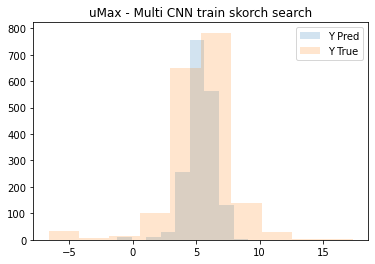

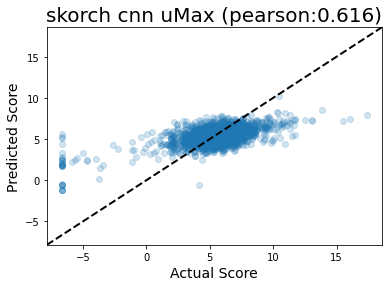

task:lowO2_fast_growth


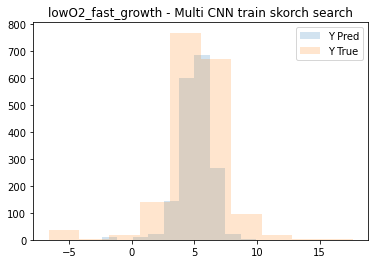

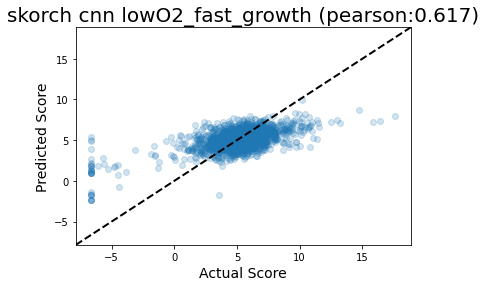

task:lowCH4


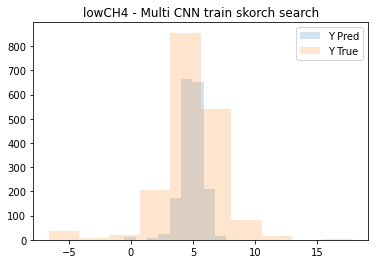

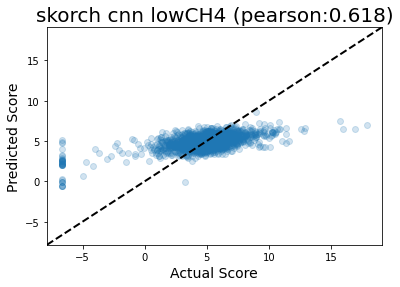

task:MeOH


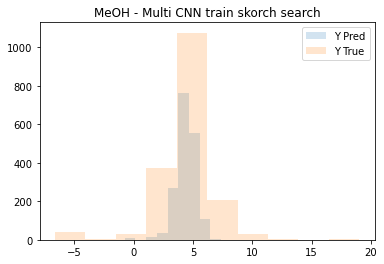

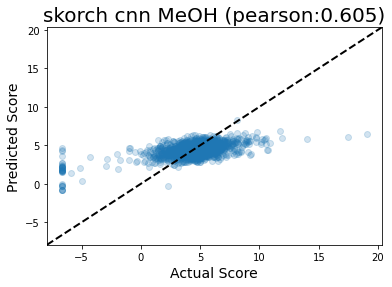

task:NoCu


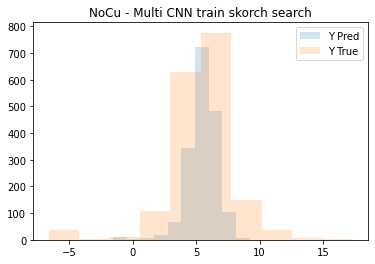

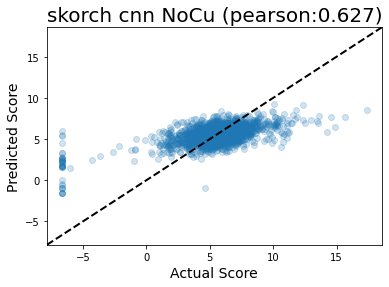

task:medCu


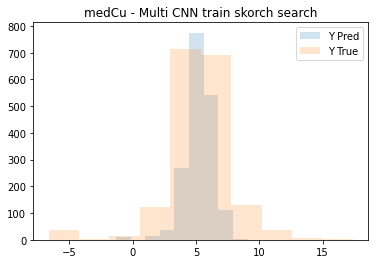

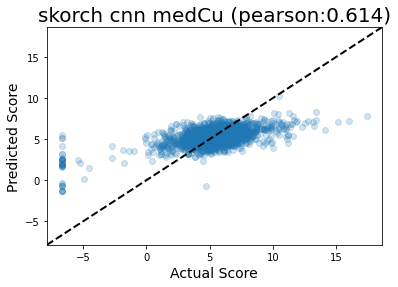

task:highCu


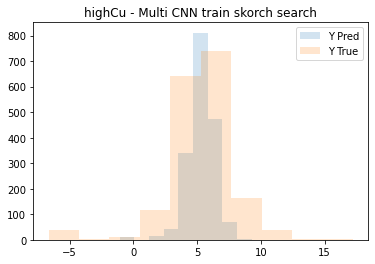

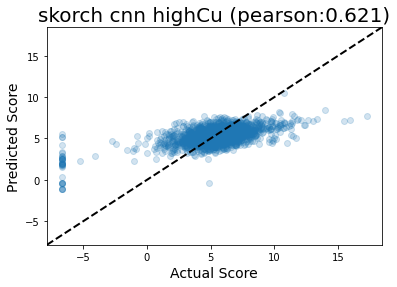

task:lowCu


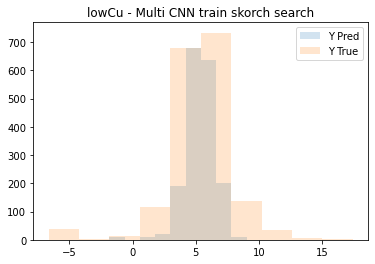

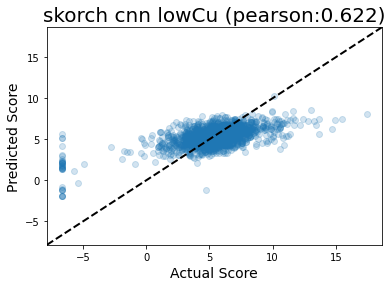

task:highO2_slow_growth


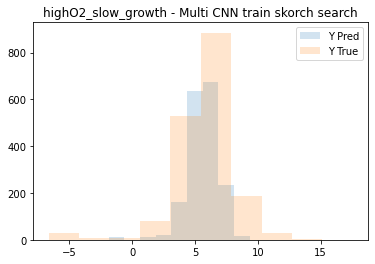

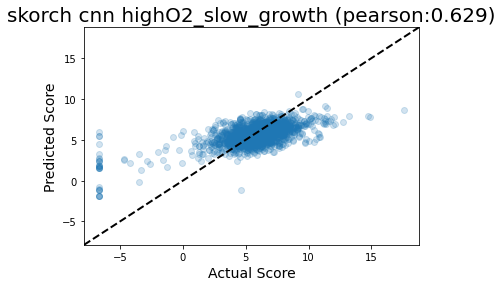

task:NO3_lowO2_slow_growth


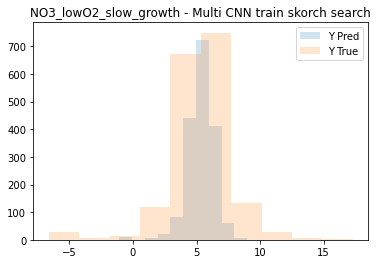

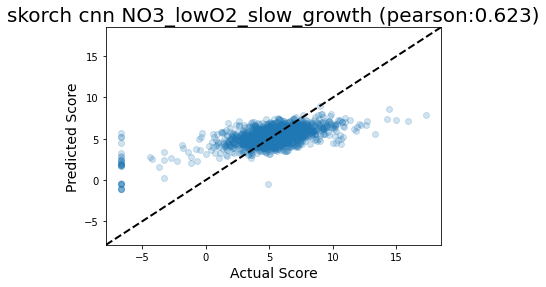

task:WithLanthanum


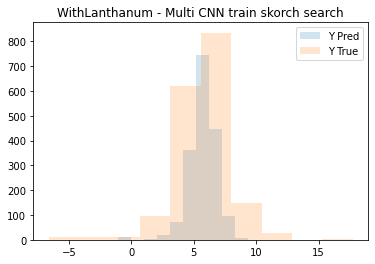

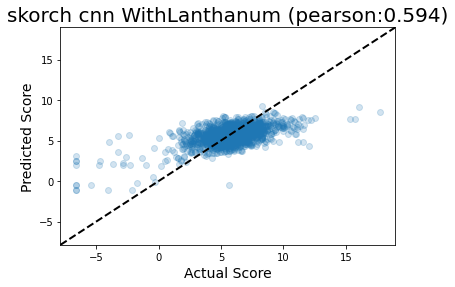

task:NoLanthanum


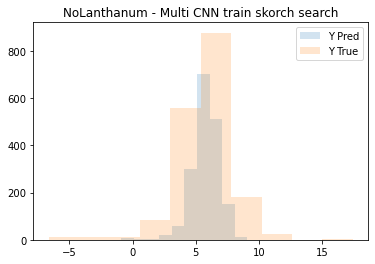

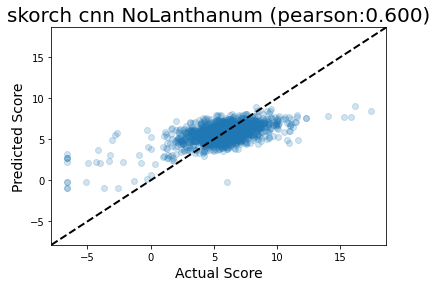

In [97]:
check_mt_pred_results(ym, ymsearch_pred_train,"Multi CNN train skorch search")

In [99]:
Xmtest,ymtest = make_multi_skorch_dfs(log_test_df, seq_col='upstream_region')
print("X m test:",Xmtest.shape)
print("y m test:",ymtest.shape)

X m test: torch.Size([441, 300, 4])
y m test: torch.Size([441, 12])


In [100]:
ymsearch_pred_test = m_search.best_estimator_.predict(Xmtest)

task:uMax


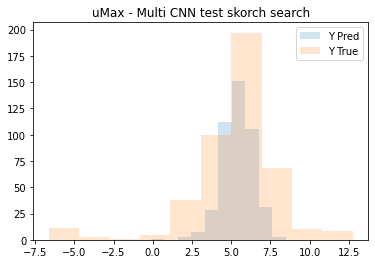

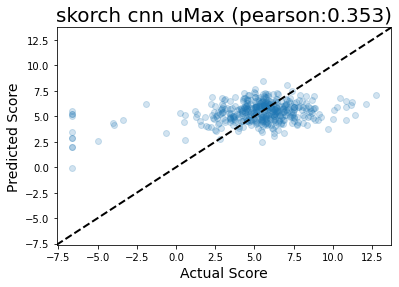

task:lowO2_fast_growth


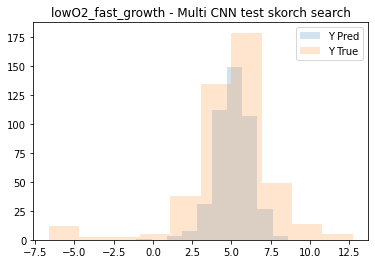

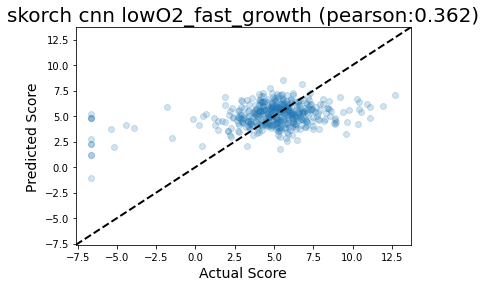

task:lowCH4


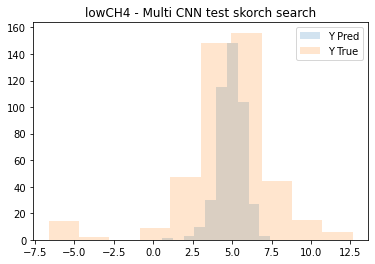

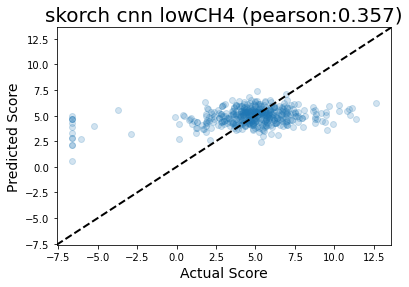

task:MeOH


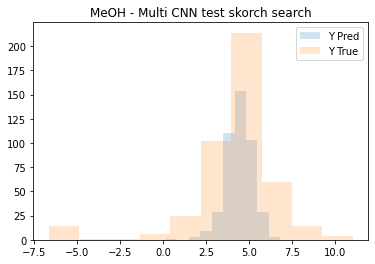

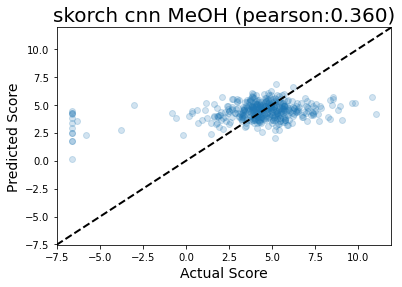

task:NoCu


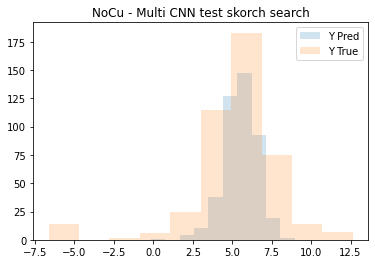

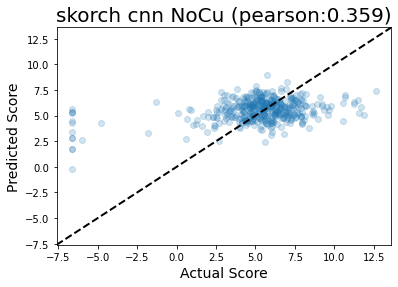

task:medCu


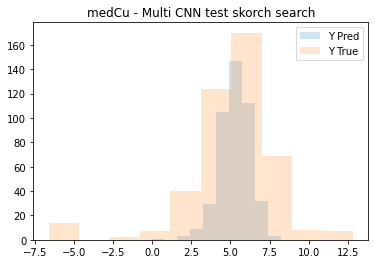

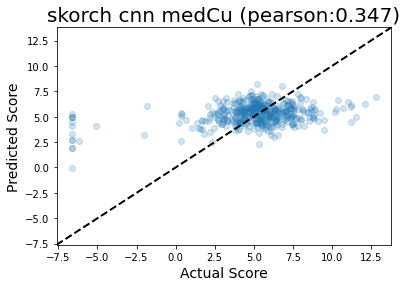

task:highCu


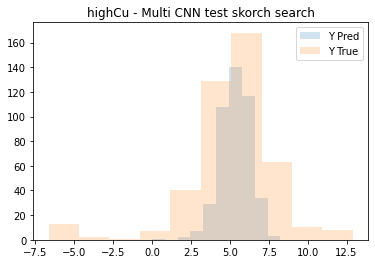

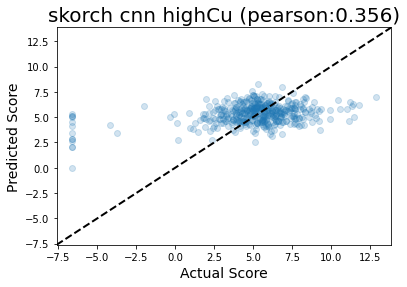

task:lowCu


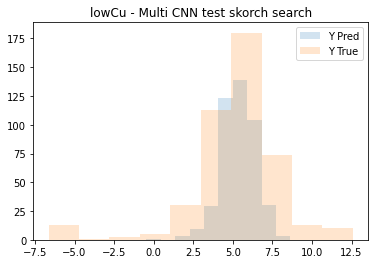

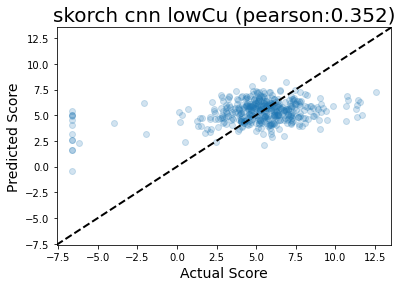

task:highO2_slow_growth


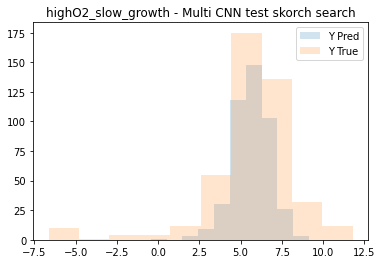

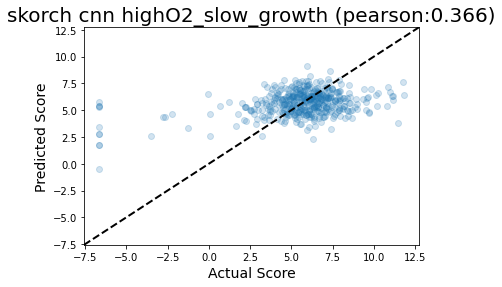

task:NO3_lowO2_slow_growth


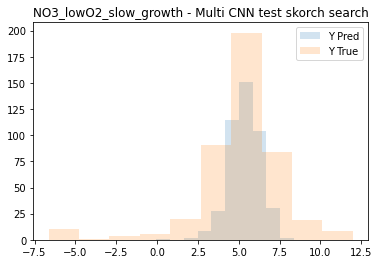

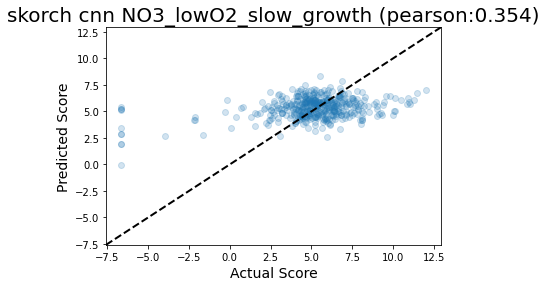

task:WithLanthanum


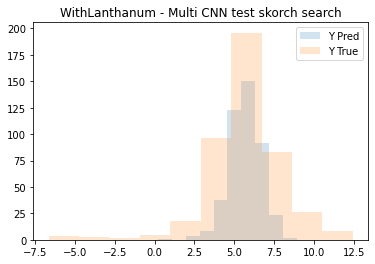

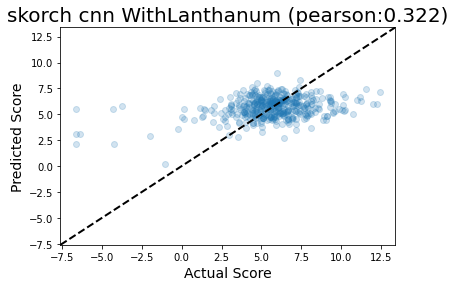

task:NoLanthanum


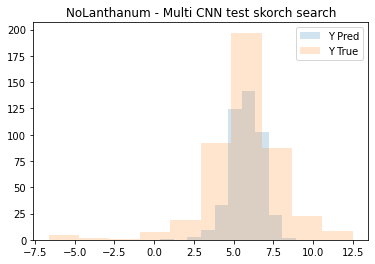

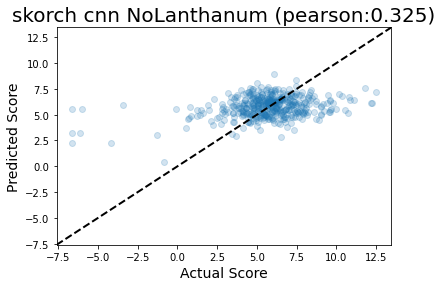

In [101]:
check_mt_pred_results(ymtest, ymsearch_pred_test,"Multi CNN test skorch search")

In [102]:
mres_df.to_csv("multi_skorch_search_res_df.tsv",sep='\t', index=False)

In [8]:
test = pd.read_csv('multi_skorch_search_res_df.tsv',sep='\t')

In [9]:
test

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        59.104487      0.685902         0.010845        0.001480   
1        59.337368      2.253942         0.013646        0.002544   
2        62.643943      0.526686         0.014259        0.001357   
3        57.970003      2.599069         0.011775        0.001051   
4        40.366428      4.052095         0.012646        0.002078   
..             ...           ...              ...             ...   
495      54.819225      1.421057         0.013606        0.001281   
496      56.441145      0.595706         0.011243        0.000335   
497      43.649200      5.467568         0.015853        0.005174   
498      77.238276      5.039324         0.017579        0.003002   
499      46.837101      8.112849         0.009816        0.002224   

                           param_optimizer  param_module__num_filters  \
0          <class 'torch.optim.adam.Adam'>                         16   
1          <class 'torch.optim.adam.Adam'>                         64   
2          <class 'torch.optim.adam.Adam'>                        128   
3          <class 'torch.optim.adam.Adam'>                         32   
4            <class 'torch.optim.sgd.SGD'>                         32   
..                                     ...                        ...   
495  <class 'torch.optim.rmsprop.RMSprop'>                        128   
496        <class 'torch.optim.adam.Adam'>                         16   
497          <class 'torch.optim.sgd.SGD'>                         32   
498        <class 'torch.optim.adam.Adam'>                        128   
499  <class 'torch.optim.adagrad.Adagrad'>                         32   

     param_module__num_fc_nodes1  param_module__kernel_size  param_lr  \
0                             10                         32   0.00050   
1                             50                         16   0.00001   
2                             25                          8   0.00010   
3                            100                          4   0.00010   
4                             25                          4   0.00010   
..                           ...                        ...       ...   
495                           10                          8   0.00050   
496                          100                          4   0.00001   
497                           10                          8   0.00001   
498                          100                         16   0.00050   
499                           25                          8   0.00010   

                                                params  split0_test_score  \
0    {'optimizer': <class 'torch.optim.adam.Adam'>,...         -18.853952   
1    {'optimizer': <class 'torch.optim.adam.Adam'>,...          -5.946605   
2    {'optimizer': <class 'torch.optim.adam.Adam'>,...         -17.657255   
3    {'optimizer': <class 'torch.optim.adam.Adam'>,...         -18.295582   
4    {'optimizer': <class 'torch.optim.sgd.SGD'>, '...          -6.104009   
..                                                 ...                ...   
495  {'optimizer': <class 'torch.optim.rmsprop.RMSp...         -19.959888   
496  {'optimizer': <class 'torch.optim.adam.Adam'>,...          -6.131781   
497  {'optimizer': <class 'torch.optim.sgd.SGD'>, '...          -7.034853   
498  {'optimizer': <class 'torch.optim.adam.Adam'>,...         -21.778761   
499  {'optimizer': <class 'torch.optim.adagrad.Adag...          -8.518679   

     split1_test_score  split2_test_score  split3_test_score  \
0           -23.230394         -21.319815         -22.497879   
1            -5.320988          -7.279854          -5.753273   
2           -21.508598         -20.662313         -21.507624   
3           -19.663145         -19.988087         -18.631847   
4            -4.963671          -7.213747          -5.209205   
..                 ...                ...                ...   
495         -24.360632         -22.448183        

In [10]:
sm_mres_df = test[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [11]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [12]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)